# CIFAR10 classification using tinygrad

[tinygrad](https://tinygrad.org/) is an end-to-end deep learning stack inspired by PyTorch, JAX, and TVM.

GitHub repo: https://github.com/tinygrad/tinygrad

## Configuration

Imports

In [1]:
from functools import partial
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from tinygrad import Tensor, nn, dtypes, TinyJit, Variable
from tinygrad.helpers import trange, Context, BEAM, WINO

Configuration

In [2]:
NUM_CLASSES = 10
IMAGE_SIZE = 32

BATCH_SIZE = 32
EPOCHS = 2000
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-3

## Model

In [3]:
class NormAct:
    def __init__(self, channels):
        self.norm = nn.BatchNorm(channels)

    def __call__(self, x):
        return self.norm(x).relu()

In [4]:
class ResidualBlock:
    def __init__(self, channels, stride=1, p_drop=0.):
        self.p_drop = p_drop
        
        if stride > 1:
            self.shortcut_conv = nn.Conv2d(channels, channels, stride, stride=stride, groups=channels, bias=False)
        else:
            self.shortcut_conv = lambda x: x
            
        self.residual = [
            NormAct(channels),
            nn.Conv2d(channels, channels, 2 + stride, stride=stride, padding=1, groups=channels, bias=False),
            NormAct(channels),
            nn.Conv2d(channels, channels, 1, bias=False)
        ]

        self.γ = Tensor.zeros(1)

    def __call__(self, x):
        out = self.shortcut_conv(x).dropout(self.p_drop) + self.γ * x.sequential(self.residual)
        return out

In [5]:
class Head:
    def __init__(self, channels, classes, p_drop=0.):
        self.p_drop = p_drop
        self.norm = NormAct(channels)
        self.linear = nn.Linear(channels, classes)

    def __call__(self, x):
        x = self.norm(x).mean((2, 3)).dropout(self.p_drop)
        x = self.linear(x)
        return x

In [6]:
def Stem(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)

In [7]:
class Net:
    def __init__(self, classes, width=32, in_channels=3, res_p_drop=0., head_p_drop=0.):
        strides = [1, 2, 1, 2, 1, 2, 1]
        self.layers = [
            Stem(in_channels, width),
            *[ResidualBlock(width, stride=stride, p_drop=res_p_drop) for stride in strides],
            Head(width, classes, p_drop=head_p_drop)
        ]
    
    def __call__(self, x):
        return x.sequential(self.layers)

In [8]:
def reset_parameters(state_dict):
    for name, param in state_dict.items():
        if "norm" in name:
            if "weight" in name:
                param.assign(Tensor.ones(*param.shape))
            elif "bias" in name:
                param.assign(Tensor.zeros(*param.shape))
        elif "γ" in name:
            param.assign(Tensor.zeros(*param.shape))
        else:
            if "weight" in name:
                param.assign(Tensor.glorot_uniform(*param.shape))
            elif "bias" in name:
                param.assign(Tensor.zeros(*param.shape))

In [9]:
model = Net(NUM_CLASSES, width=96, res_p_drop=0.1, head_p_drop=0.1)

In [10]:
state_dict = nn.state.get_state_dict(model)

In [11]:
reset_parameters(state_dict)

In [12]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in nn.state.get_parameters(model)
                                              if p.requires_grad is None or p.requires_grad)))

Number of parameters: 80,177


## Data

In [13]:
def plot_tensor_image(X):
    img = (X * 255).cast(dtypes.uint8).numpy()
    img = np.moveaxis(img, 0, -1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(img)
    fig.show()

In [14]:
def reflection_pad(X, padding):
    X = X[..., :, 1:padding + 1].flip(-1).cat(X, X[..., :, -(padding + 1):-1].flip(-1), dim=-1)
    X = X[..., 1:padding + 1, :].flip(-2).cat(X, X[..., -(padding + 1):-1, :].flip(-2), dim=-2)
    return X

In [15]:
train_transform = [
    lambda x: x.float() / 255.0,
    partial(reflection_pad, padding=4),
    lambda x: x.cast(dtypes.default_float)
]

In [16]:
val_transform = [
    lambda x: x.float() / 255.0,
    lambda x: x.cast(dtypes.default_float)
]

In [17]:
X_train, Y_train, X_test, Y_test = nn.datasets.cifar()

In [18]:
X_train, X_test = X_train.sequential(train_transform), X_test.sequential(val_transform)

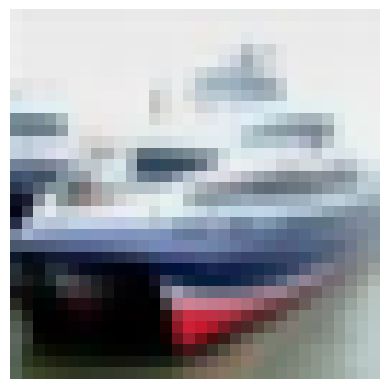

In [19]:
plot_tensor_image(X_test[1])

## Data loading

In [20]:
def flip_LR(X, prob=0.5):
    X = (Tensor.rand(X.shape[0], 1, 1, 1) < prob).where(X.flip(-1), X)
    return X

In [21]:
def random_crop(X, crop_size):
    b, c, h, w = X.shape
    low_x = Tensor.randint(b, low = 0, high = w - crop_size).reshape(b, 1, 1, 1)
    low_y = Tensor.randint(b, low = 0, high = h - crop_size).reshape(b, 1, 1, 1)

    idx_x = Tensor.arange(crop_size, dtype = dtypes.int32).reshape((1, 1, 1, crop_size))
    idx_y = Tensor.arange(crop_size, dtype = dtypes.int32).reshape((1, 1, crop_size, 1))

    idx_x = (low_x + idx_x).expand(-1, c, h, -1)
    idx_y = (low_y + idx_y).expand(-1, c, crop_size, crop_size)
    X = X.gather(-1, idx_x).gather(-2, idx_y)
    return X

In [22]:
def random_brightness(X, low=0.7, high=1.3):
    factor = Tensor.uniform(X.shape[0], 1, 1, 1, low=low, high=high)
    X = (X * factor).clamp(0., 1.)
    return X

In [23]:
@TinyJit
def augmentations(X):
    X = flip_LR(X)
    X = random_crop(X, crop_size=IMAGE_SIZE)
    X = random_brightness(X, low=0.7, high = 1.3)
    return X

In [24]:
def fetch_batches(X_in, Y_in, batch_size, is_train):
    X, Y = X_in, Y_in
    data_size = X.shape[0]
    if is_train:
        perms = Tensor.randperm(data_size, device=X.device)
        X, Y = X[perms], Y[perms]
        X = augmentations(X)

    full_batches = (data_size // batch_size) * batch_size
    i_var = Variable("i", 0, full_batches - batch_size)
    for i in range(0, full_batches, batch_size):
        i_var_b = i_var.bind(i)
        X_batch, Y_batch = X[i_var_b:i_var_b + batch_size], Y[i_var_b:i_var_b + batch_size]
        yield X_batch, Y_batch

## Training

### Loss

In [25]:
def loss_fn(out, Y):
    loss = out.sparse_categorical_crossentropy(Y)
    return loss

### Scheduler

In [26]:
class LR_Scheduler:
    def __init__(self, optimizer):
        self.optimizer = optimizer
        self.epoch_counter = Tensor([0], requires_grad=False, device=self.optimizer.device)
    
    def get_lr(self):
        pass
    
    def schedule_step(self):
        return [self.epoch_counter.assign(self.epoch_counter + 1), self.optimizer.lr.assign(self.get_lr())]
    
    def step(self):
        Tensor.realize(*self.schedule_step())

In [27]:
class OneCycleLR(LR_Scheduler):
    def __init__(self, optimizer, max_lr, total_steps,
                 pct_start=0.3, div_factor=25.0, final_div_factor=10000.0):
        super().__init__(optimizer)
        self.initial_lr = max_lr / div_factor
        self.max_lr = max_lr
        self.min_lr = self.initial_lr / final_div_factor
        self.increase_steps = total_steps * pct_start
        self.decrease_steps = total_steps - self.increase_steps
        self.optimizer.lr.assign(self.get_lr()).realize() # update the initial LR

    @staticmethod
    def _annealing_linear(start, end, pct):
        return pct * (end - start) + start
    
    def get_lr(self):
        is_increasing = self.epoch_counter < self.increase_steps
        lr = is_increasing.where(
            self._annealing_linear(
                self.initial_lr,
                self.max_lr,
                self.epoch_counter / self.increase_steps
            ),
            self._annealing_linear(
                self.max_lr,
                self.min_lr,
                (self.epoch_counter - self.increase_steps) / self.decrease_steps
            )
        )
        lr = lr.cast(self.optimizer.lr.dtype)
        return lr

### Training functions

In [28]:
def iterate(step_fn, batcher):
    num_samples = 0
    total_loss = 0.
    num_correct = 0
    for x, y in batcher:
        loss, out = step_fn(x, y)
        pred = out.argmax(axis=-1)
        correct = (pred == y)
        loss, correct = loss.numpy(), correct.numpy()
        num_samples += correct.shape[0]
        total_loss += loss
        num_correct += np.sum(correct)
    
    avg_loss = total_loss / num_samples
    acc = num_correct / num_samples
    metrics = {"loss": avg_loss, "acc": acc}
    return metrics

In [29]:
def train(model, loss_fn, optimizer, batcher, batch_scheduler):
    @TinyJit
    @Tensor.train()
    def train_step(x, y):
        out = model(x)
        loss = loss_fn(out, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_scheduler.step()
        return loss.realize(), out.realize()

    with Context(BEAM=BEAM.value, WINO=WINO.value):
        metrics = iterate(train_step, batcher)
    return metrics

In [30]:
def evaluate(model, loss_fn, batcher):
    @TinyJit
    def eval_step(x, y):
        out = model(x)
        loss = loss_fn(out, y)
        return loss.realize(), out.realize()

    metrics = iterate(eval_step, batcher)
    return metrics

In [31]:
def update_history(history, metrics, name):
    for key, val in metrics.items():
        history[name + ' ' + key].append(val)

In [32]:
def history_plot_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    plt.show()

### Start training

In [33]:
num_train_samples = X_train.shape[0]

In [34]:
num_steps_per_epoch = num_train_samples // BATCH_SIZE

In [35]:
total_train_steps = num_steps_per_epoch * EPOCHS

In [36]:
optimizer = nn.optim.AdamW(nn.state.get_parameters(model), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [37]:
lr_scheduler = OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=total_train_steps)

In [38]:
history = defaultdict(list)
pbar = trange(EPOCHS)
for epoch in pbar:
    train_batcher = fetch_batches(X_train, Y_train, BATCH_SIZE, is_train=True)
    train_metrics = train(model, loss_fn, optimizer, train_batcher, lr_scheduler)
    update_history(history, train_metrics, "train")
    
    val_batcher = fetch_batches(X_test, Y_test, BATCH_SIZE, is_train=False)
    val_metrics = evaluate(model, loss_fn, val_batcher)
    update_history(history, val_metrics, "val")
    pbar.set_description(f"acc={train_metrics['acc']:.3f}, val acc={val_metrics['acc']:.3f}")

  0%|                                                  | 0/2000 [00:00<?, ?it/s]

acc=0.383, val acc=0.550:   0%|             | 1/2000 [00:47<26:19:59,  0.02it/s]

acc=0.551, val acc=0.626:   0%|             | 2/2000 [01:26<23:55:11,  0.02it/s]

acc=0.611, val acc=0.675:   0%|             | 3/2000 [02:00<22:15:44,  0.02it/s]

acc=0.648, val acc=0.704:   0%|             | 4/2000 [02:30<20:54:38,  0.03it/s]

acc=0.677, val acc=0.714:   0%|             | 5/2000 [03:01<20:05:50,  0.03it/s]

acc=0.703, val acc=0.730:   0%|             | 6/2000 [03:31<19:32:58,  0.03it/s]

acc=0.725, val acc=0.766:   0%|             | 7/2000 [04:02<19:11:59,  0.03it/s]

acc=0.738, val acc=0.775:   0%|             | 8/2000 [04:33<18:53:48,  0.03it/s]

acc=0.753, val acc=0.786:   0%|             | 9/2000 [05:03<18:39:01,  0.03it/s]

acc=0.766, val acc=0.791:   0%|            | 10/2000 [05:33<18:27:09,  0.03it/s]

acc=0.776, val acc=0.795:   1%|            | 11/2000 [06:04<18:19:00,  0.03it/s]

acc=0.782, val acc=0.810:   1%|            | 12/2000 [06:34<18:10:36,  0.03it/s]

acc=0.791, val acc=0.818:   1%|            | 13/2000 [07:05<18:03:46,  0.03it/s]

acc=0.798, val acc=0.819:   1%|            | 14/2000 [07:35<17:57:35,  0.03it/s]

acc=0.805, val acc=0.824:   1%|            | 15/2000 [08:06<17:52:16,  0.03it/s]

acc=0.813, val acc=0.825:   1%|            | 16/2000 [08:36<17:48:18,  0.03it/s]

acc=0.817, val acc=0.832:   1%|            | 17/2000 [09:07<17:44:12,  0.03it/s]

acc=0.822, val acc=0.839:   1%|            | 18/2000 [09:37<17:40:32,  0.03it/s]

acc=0.826, val acc=0.840:   1%|            | 19/2000 [10:08<17:37:04,  0.03it/s]

acc=0.827, val acc=0.834:   1%|            | 20/2000 [10:39<17:34:32,  0.03it/s]

acc=0.832, val acc=0.844:   1%|▏           | 21/2000 [11:09<17:31:39,  0.03it/s]

acc=0.834, val acc=0.844:   1%|▏           | 22/2000 [11:39<17:28:52,  0.03it/s]

acc=0.837, val acc=0.848:   1%|▏           | 23/2000 [12:10<17:26:17,  0.03it/s]

acc=0.840, val acc=0.850:   1%|▏           | 24/2000 [12:40<17:23:49,  0.03it/s]

acc=0.844, val acc=0.853:   1%|▏           | 25/2000 [13:11<17:22:15,  0.03it/s]

acc=0.847, val acc=0.853:   1%|▏           | 26/2000 [13:41<17:20:07,  0.03it/s]

acc=0.849, val acc=0.855:   1%|▏           | 27/2000 [14:12<17:17:57,  0.03it/s]

acc=0.854, val acc=0.853:   1%|▏           | 28/2000 [14:42<17:15:56,  0.03it/s]

acc=0.852, val acc=0.854:   1%|▏           | 29/2000 [15:13<17:14:29,  0.03it/s]

acc=0.856, val acc=0.858:   2%|▏           | 30/2000 [15:43<17:12:47,  0.03it/s]

acc=0.858, val acc=0.864:   2%|▏           | 31/2000 [16:14<17:11:15,  0.03it/s]

acc=0.856, val acc=0.862:   2%|▏           | 32/2000 [16:44<17:09:42,  0.03it/s]

acc=0.859, val acc=0.849:   2%|▏           | 33/2000 [17:15<17:08:39,  0.03it/s]

acc=0.861, val acc=0.849:   2%|▏           | 34/2000 [17:45<17:07:07,  0.03it/s]

acc=0.863, val acc=0.869:   2%|▏           | 35/2000 [18:16<17:05:43,  0.03it/s]

acc=0.866, val acc=0.868:   2%|▏           | 36/2000 [18:46<17:04:20,  0.03it/s]

acc=0.867, val acc=0.864:   2%|▏           | 37/2000 [19:16<17:02:58,  0.03it/s]

acc=0.868, val acc=0.869:   2%|▏           | 38/2000 [19:47<17:02:10,  0.03it/s]

acc=0.868, val acc=0.869:   2%|▏           | 39/2000 [20:18<17:01:00,  0.03it/s]

acc=0.868, val acc=0.877:   2%|▏           | 40/2000 [20:48<16:59:46,  0.03it/s]

acc=0.872, val acc=0.858:   2%|▏           | 41/2000 [21:19<16:58:32,  0.03it/s]

acc=0.872, val acc=0.873:   2%|▎           | 42/2000 [21:49<16:57:37,  0.03it/s]

acc=0.873, val acc=0.874:   2%|▎           | 43/2000 [22:20<16:56:32,  0.03it/s]

acc=0.877, val acc=0.874:   2%|▎           | 44/2000 [22:50<16:55:26,  0.03it/s]

acc=0.877, val acc=0.867:   2%|▎           | 45/2000 [23:20<16:54:20,  0.03it/s]

acc=0.878, val acc=0.879:   2%|▎           | 46/2000 [23:51<16:53:19,  0.03it/s]

acc=0.880, val acc=0.881:   2%|▎           | 47/2000 [24:22<16:52:36,  0.03it/s]

acc=0.881, val acc=0.874:   2%|▎           | 48/2000 [24:52<16:51:33,  0.03it/s]

acc=0.881, val acc=0.878:   2%|▎           | 49/2000 [25:22<16:50:37,  0.03it/s]

acc=0.881, val acc=0.883:   2%|▎           | 50/2000 [25:53<16:49:40,  0.03it/s]

acc=0.880, val acc=0.878:   3%|▎           | 51/2000 [26:24<16:48:56,  0.03it/s]

acc=0.884, val acc=0.878:   3%|▎           | 52/2000 [26:54<16:47:56,  0.03it/s]

acc=0.882, val acc=0.867:   3%|▎           | 53/2000 [27:24<16:47:02,  0.03it/s]

acc=0.885, val acc=0.867:   3%|▎           | 54/2000 [27:55<16:46:10,  0.03it/s]

acc=0.888, val acc=0.883:   3%|▎           | 55/2000 [28:25<16:45:28,  0.03it/s]

acc=0.887, val acc=0.884:   3%|▎           | 56/2000 [28:56<16:44:35,  0.03it/s]

acc=0.890, val acc=0.885:   3%|▎           | 57/2000 [29:26<16:43:42,  0.03it/s]

acc=0.889, val acc=0.884:   3%|▎           | 58/2000 [29:57<16:42:50,  0.03it/s]

acc=0.888, val acc=0.883:   3%|▎           | 59/2000 [30:27<16:42:01,  0.03it/s]

acc=0.888, val acc=0.879:   3%|▎           | 60/2000 [30:58<16:41:31,  0.03it/s]

acc=0.890, val acc=0.878:   3%|▎           | 61/2000 [31:28<16:40:44,  0.03it/s]

acc=0.891, val acc=0.882:   3%|▎           | 62/2000 [31:59<16:39:54,  0.03it/s]

acc=0.892, val acc=0.882:   3%|▍           | 63/2000 [32:29<16:39:08,  0.03it/s]

acc=0.892, val acc=0.886:   3%|▍           | 64/2000 [33:00<16:38:20,  0.03it/s]

acc=0.892, val acc=0.881:   3%|▍           | 65/2000 [33:30<16:37:44,  0.03it/s]

acc=0.891, val acc=0.883:   3%|▍           | 66/2000 [34:01<16:36:55,  0.03it/s]

acc=0.893, val acc=0.888:   3%|▍           | 67/2000 [34:31<16:36:08,  0.03it/s]

acc=0.894, val acc=0.884:   3%|▍           | 68/2000 [35:01<16:35:19,  0.03it/s]

acc=0.894, val acc=0.886:   3%|▍           | 69/2000 [35:32<16:34:46,  0.03it/s]

acc=0.895, val acc=0.885:   4%|▍           | 70/2000 [36:03<16:34:01,  0.03it/s]

acc=0.895, val acc=0.889:   4%|▍           | 71/2000 [36:33<16:33:17,  0.03it/s]

acc=0.896, val acc=0.878:   4%|▍           | 72/2000 [37:03<16:32:30,  0.03it/s]

acc=0.897, val acc=0.874:   4%|▍           | 73/2000 [37:34<16:31:45,  0.03it/s]

acc=0.896, val acc=0.890:   4%|▍           | 74/2000 [38:05<16:31:13,  0.03it/s]

acc=0.899, val acc=0.893:   4%|▍           | 75/2000 [38:35<16:30:31,  0.03it/s]

acc=0.898, val acc=0.886:   4%|▍           | 76/2000 [39:05<16:29:48,  0.03it/s]

acc=0.898, val acc=0.889:   4%|▍           | 77/2000 [39:36<16:29:07,  0.03it/s]

acc=0.898, val acc=0.890:   4%|▍           | 78/2000 [40:07<16:28:34,  0.03it/s]

acc=0.901, val acc=0.888:   4%|▍           | 79/2000 [40:37<16:27:50,  0.03it/s]

acc=0.900, val acc=0.888:   4%|▍           | 80/2000 [41:07<16:27:09,  0.03it/s]

acc=0.902, val acc=0.889:   4%|▍           | 81/2000 [41:38<16:26:28,  0.03it/s]

acc=0.901, val acc=0.886:   4%|▍           | 82/2000 [42:08<16:25:47,  0.03it/s]

acc=0.901, val acc=0.885:   4%|▍           | 83/2000 [42:39<16:25:15,  0.03it/s]

acc=0.900, val acc=0.891:   4%|▌           | 84/2000 [43:09<16:24:35,  0.03it/s]

acc=0.904, val acc=0.893:   4%|▌           | 85/2000 [43:40<16:23:58,  0.03it/s]

acc=0.902, val acc=0.887:   4%|▌           | 86/2000 [44:11<16:23:20,  0.03it/s]

acc=0.903, val acc=0.889:   4%|▌           | 87/2000 [44:41<16:22:40,  0.03it/s]

acc=0.904, val acc=0.890:   4%|▌           | 88/2000 [45:12<16:22:12,  0.03it/s]

acc=0.903, val acc=0.891:   4%|▌           | 89/2000 [45:42<16:21:32,  0.03it/s]

acc=0.905, val acc=0.890:   4%|▌           | 90/2000 [46:13<16:20:53,  0.03it/s]

acc=0.904, val acc=0.895:   5%|▌           | 91/2000 [46:43<16:20:16,  0.03it/s]

acc=0.905, val acc=0.894:   5%|▌           | 92/2000 [47:14<16:19:47,  0.03it/s]

acc=0.905, val acc=0.894:   5%|▌           | 93/2000 [47:45<16:19:08,  0.03it/s]

acc=0.904, val acc=0.887:   5%|▌           | 94/2000 [48:15<16:18:28,  0.03it/s]

acc=0.907, val acc=0.885:   5%|▌           | 95/2000 [48:45<16:17:52,  0.03it/s]

acc=0.908, val acc=0.893:   5%|▌           | 96/2000 [49:16<16:17:14,  0.03it/s]

acc=0.907, val acc=0.894:   5%|▌           | 97/2000 [49:47<16:16:42,  0.03it/s]

acc=0.905, val acc=0.895:   5%|▌           | 98/2000 [50:17<16:16:03,  0.03it/s]

acc=0.909, val acc=0.889:   5%|▌           | 99/2000 [50:47<16:15:24,  0.03it/s]

acc=0.908, val acc=0.892:   5%|▌          | 100/2000 [51:18<16:14:46,  0.03it/s]

acc=0.908, val acc=0.886:   5%|▌          | 101/2000 [51:48<16:14:07,  0.03it/s]

acc=0.909, val acc=0.898:   5%|▌          | 102/2000 [52:19<16:13:37,  0.03it/s]

acc=0.910, val acc=0.894:   5%|▌          | 103/2000 [52:49<16:13:00,  0.03it/s]

acc=0.908, val acc=0.896:   5%|▌          | 104/2000 [53:20<16:12:22,  0.03it/s]

acc=0.910, val acc=0.888:   5%|▌          | 105/2000 [53:50<16:11:43,  0.03it/s]

acc=0.908, val acc=0.889:   5%|▌          | 106/2000 [54:21<16:11:12,  0.03it/s]

acc=0.912, val acc=0.897:   5%|▌          | 107/2000 [54:51<16:10:34,  0.03it/s]

acc=0.909, val acc=0.885:   5%|▌          | 108/2000 [55:21<16:09:55,  0.03it/s]

acc=0.910, val acc=0.893:   5%|▌          | 109/2000 [55:52<16:09:18,  0.03it/s]

acc=0.913, val acc=0.895:   6%|▌          | 110/2000 [56:22<16:08:40,  0.03it/s]

acc=0.911, val acc=0.894:   6%|▌          | 111/2000 [56:53<16:08:11,  0.03it/s]

acc=0.912, val acc=0.891:   6%|▌          | 112/2000 [57:23<16:07:34,  0.03it/s]

acc=0.911, val acc=0.897:   6%|▌          | 113/2000 [57:54<16:06:57,  0.03it/s]

acc=0.910, val acc=0.892:   6%|▋          | 114/2000 [58:24<16:06:21,  0.03it/s]

acc=0.911, val acc=0.897:   6%|▋          | 115/2000 [58:55<16:05:46,  0.03it/s]

acc=0.913, val acc=0.897:   6%|▋          | 116/2000 [59:26<16:05:19,  0.03it/s]

acc=0.912, val acc=0.891:   6%|▋          | 117/2000 [59:56<16:04:41,  0.03it/s]

acc=0.911, val acc=0.894:   6%|▌        | 118/2000 [1:00:26<16:04:05,  0.03it/s]

acc=0.914, val acc=0.893:   6%|▌        | 119/2000 [1:00:57<16:03:32,  0.03it/s]

acc=0.915, val acc=0.894:   6%|▌        | 120/2000 [1:01:27<16:02:55,  0.03it/s]

acc=0.913, val acc=0.891:   6%|▌        | 121/2000 [1:01:58<16:02:25,  0.03it/s]

acc=0.912, val acc=0.890:   6%|▌        | 122/2000 [1:02:28<16:01:48,  0.03it/s]

acc=0.915, val acc=0.895:   6%|▌        | 123/2000 [1:02:59<16:01:13,  0.03it/s]

acc=0.914, val acc=0.900:   6%|▌        | 124/2000 [1:03:29<16:00:37,  0.03it/s]

acc=0.915, val acc=0.894:   6%|▌        | 125/2000 [1:04:00<16:00:09,  0.03it/s]

acc=0.915, val acc=0.892:   6%|▌        | 126/2000 [1:04:31<15:59:34,  0.03it/s]

acc=0.915, val acc=0.886:   6%|▌        | 127/2000 [1:05:01<15:58:58,  0.03it/s]

acc=0.915, val acc=0.898:   6%|▌        | 128/2000 [1:05:31<15:58:21,  0.03it/s]

acc=0.916, val acc=0.887:   6%|▌        | 129/2000 [1:06:02<15:57:45,  0.03it/s]

acc=0.916, val acc=0.887:   6%|▌        | 130/2000 [1:06:33<15:57:17,  0.03it/s]

acc=0.917, val acc=0.893:   7%|▌        | 131/2000 [1:07:03<15:56:43,  0.03it/s]

acc=0.916, val acc=0.890:   7%|▌        | 132/2000 [1:07:34<15:56:10,  0.03it/s]

acc=0.918, val acc=0.896:   7%|▌        | 133/2000 [1:08:04<15:55:36,  0.03it/s]

acc=0.916, val acc=0.894:   7%|▌        | 134/2000 [1:08:34<15:55:02,  0.03it/s]

acc=0.916, val acc=0.891:   7%|▌        | 135/2000 [1:09:05<15:54:35,  0.03it/s]

acc=0.916, val acc=0.891:   7%|▌        | 136/2000 [1:09:36<15:54:00,  0.03it/s]

acc=0.917, val acc=0.899:   7%|▌        | 137/2000 [1:10:06<15:53:24,  0.03it/s]

acc=0.917, val acc=0.892:   7%|▌        | 138/2000 [1:10:36<15:52:48,  0.03it/s]

acc=0.916, val acc=0.895:   7%|▋        | 139/2000 [1:11:07<15:52:12,  0.03it/s]

acc=0.917, val acc=0.896:   7%|▋        | 140/2000 [1:11:38<15:51:44,  0.03it/s]

acc=0.918, val acc=0.891:   7%|▋        | 141/2000 [1:12:08<15:51:10,  0.03it/s]

acc=0.920, val acc=0.891:   7%|▋        | 142/2000 [1:12:38<15:50:33,  0.03it/s]

acc=0.919, val acc=0.894:   7%|▋        | 143/2000 [1:13:09<15:49:58,  0.03it/s]

acc=0.916, val acc=0.894:   7%|▋        | 144/2000 [1:13:39<15:49:24,  0.03it/s]

acc=0.918, val acc=0.893:   7%|▋        | 145/2000 [1:14:10<15:48:55,  0.03it/s]

acc=0.918, val acc=0.895:   7%|▋        | 146/2000 [1:14:40<15:48:21,  0.03it/s]

acc=0.918, val acc=0.896:   7%|▋        | 147/2000 [1:15:11<15:47:46,  0.03it/s]

acc=0.920, val acc=0.896:   7%|▋        | 148/2000 [1:15:41<15:47:12,  0.03it/s]

acc=0.918, val acc=0.896:   7%|▋        | 149/2000 [1:16:12<15:46:38,  0.03it/s]

acc=0.920, val acc=0.896:   8%|▋        | 150/2000 [1:16:42<15:46:09,  0.03it/s]

acc=0.919, val acc=0.894:   8%|▋        | 151/2000 [1:17:13<15:45:34,  0.03it/s]

acc=0.918, val acc=0.892:   8%|▋        | 152/2000 [1:17:43<15:44:59,  0.03it/s]

acc=0.919, val acc=0.895:   8%|▋        | 153/2000 [1:18:13<15:44:24,  0.03it/s]

acc=0.919, val acc=0.902:   8%|▋        | 154/2000 [1:18:44<15:43:56,  0.03it/s]

acc=0.921, val acc=0.897:   8%|▋        | 155/2000 [1:19:15<15:43:21,  0.03it/s]

acc=0.920, val acc=0.897:   8%|▋        | 156/2000 [1:19:45<15:42:46,  0.03it/s]

acc=0.921, val acc=0.897:   8%|▋        | 157/2000 [1:20:15<15:42:11,  0.03it/s]

acc=0.920, val acc=0.897:   8%|▋        | 158/2000 [1:20:46<15:41:37,  0.03it/s]

acc=0.920, val acc=0.891:   8%|▋        | 159/2000 [1:21:17<15:41:09,  0.03it/s]

acc=0.918, val acc=0.893:   8%|▋        | 160/2000 [1:21:47<15:40:35,  0.03it/s]

acc=0.921, val acc=0.896:   8%|▋        | 161/2000 [1:22:17<15:40:01,  0.03it/s]

acc=0.920, val acc=0.896:   8%|▋        | 162/2000 [1:22:48<15:39:26,  0.03it/s]

acc=0.922, val acc=0.892:   8%|▋        | 163/2000 [1:23:18<15:38:52,  0.03it/s]

acc=0.920, val acc=0.891:   8%|▋        | 164/2000 [1:23:49<15:38:24,  0.03it/s]

acc=0.918, val acc=0.895:   8%|▋        | 165/2000 [1:24:19<15:37:51,  0.03it/s]

acc=0.922, val acc=0.895:   8%|▋        | 166/2000 [1:24:50<15:37:18,  0.03it/s]

acc=0.921, val acc=0.894:   8%|▊        | 167/2000 [1:25:20<15:36:45,  0.03it/s]

acc=0.921, val acc=0.894:   8%|▊        | 168/2000 [1:25:51<15:36:12,  0.03it/s]

acc=0.922, val acc=0.894:   8%|▊        | 169/2000 [1:26:22<15:35:43,  0.03it/s]

acc=0.922, val acc=0.898:   8%|▊        | 170/2000 [1:26:52<15:35:11,  0.03it/s]

acc=0.922, val acc=0.901:   9%|▊        | 171/2000 [1:27:22<15:34:38,  0.03it/s]

acc=0.922, val acc=0.900:   9%|▊        | 172/2000 [1:27:53<15:34:04,  0.03it/s]

acc=0.924, val acc=0.897:   9%|▊        | 173/2000 [1:28:23<15:33:30,  0.03it/s]

acc=0.921, val acc=0.897:   9%|▊        | 174/2000 [1:28:54<15:33:01,  0.03it/s]

acc=0.924, val acc=0.893:   9%|▊        | 175/2000 [1:29:24<15:32:28,  0.03it/s]

acc=0.922, val acc=0.894:   9%|▊        | 176/2000 [1:29:55<15:31:54,  0.03it/s]

acc=0.922, val acc=0.898:   9%|▊        | 177/2000 [1:30:25<15:31:21,  0.03it/s]

acc=0.923, val acc=0.895:   9%|▊        | 178/2000 [1:30:56<15:30:49,  0.03it/s]

acc=0.923, val acc=0.903:   9%|▊        | 179/2000 [1:31:26<15:30:16,  0.03it/s]

acc=0.922, val acc=0.902:   9%|▊        | 180/2000 [1:31:57<15:29:48,  0.03it/s]

acc=0.923, val acc=0.895:   9%|▊        | 181/2000 [1:32:27<15:29:15,  0.03it/s]

acc=0.923, val acc=0.900:   9%|▊        | 182/2000 [1:32:58<15:28:42,  0.03it/s]

acc=0.923, val acc=0.902:   9%|▊        | 183/2000 [1:33:28<15:28:09,  0.03it/s]

acc=0.922, val acc=0.895:   9%|▊        | 184/2000 [1:33:59<15:27:35,  0.03it/s]

acc=0.923, val acc=0.897:   9%|▊        | 185/2000 [1:34:29<15:27:06,  0.03it/s]

acc=0.922, val acc=0.898:   9%|▊        | 186/2000 [1:35:00<15:26:33,  0.03it/s]

acc=0.924, val acc=0.898:   9%|▊        | 187/2000 [1:35:30<15:26:00,  0.03it/s]

acc=0.925, val acc=0.898:   9%|▊        | 188/2000 [1:36:01<15:25:26,  0.03it/s]

acc=0.924, val acc=0.894:   9%|▊        | 189/2000 [1:36:31<15:24:54,  0.03it/s]

acc=0.926, val acc=0.898:  10%|▊        | 190/2000 [1:37:02<15:24:27,  0.03it/s]

acc=0.924, val acc=0.898:  10%|▊        | 191/2000 [1:37:32<15:23:54,  0.03it/s]

acc=0.924, val acc=0.897:  10%|▊        | 192/2000 [1:38:03<15:23:21,  0.03it/s]

acc=0.924, val acc=0.900:  10%|▊        | 193/2000 [1:38:33<15:22:50,  0.03it/s]

acc=0.925, val acc=0.901:  10%|▊        | 194/2000 [1:39:04<15:22:17,  0.03it/s]

acc=0.926, val acc=0.899:  10%|▉        | 195/2000 [1:39:35<15:21:50,  0.03it/s]

acc=0.924, val acc=0.897:  10%|▉        | 196/2000 [1:40:05<15:21:18,  0.03it/s]

acc=0.925, val acc=0.898:  10%|▉        | 197/2000 [1:40:36<15:20:46,  0.03it/s]

acc=0.927, val acc=0.900:  10%|▉        | 198/2000 [1:41:06<15:20:14,  0.03it/s]

acc=0.924, val acc=0.896:  10%|▉        | 199/2000 [1:41:37<15:19:41,  0.03it/s]

acc=0.925, val acc=0.900:  10%|▉        | 200/2000 [1:42:08<15:19:14,  0.03it/s]

acc=0.926, val acc=0.906:  10%|▉        | 201/2000 [1:42:38<15:18:42,  0.03it/s]

acc=0.924, val acc=0.898:  10%|▉        | 202/2000 [1:43:09<15:18:11,  0.03it/s]

acc=0.923, val acc=0.899:  10%|▉        | 203/2000 [1:43:39<15:17:40,  0.03it/s]

acc=0.924, val acc=0.901:  10%|▉        | 204/2000 [1:44:10<15:17:09,  0.03it/s]

acc=0.926, val acc=0.900:  10%|▉        | 205/2000 [1:44:41<15:16:40,  0.03it/s]

acc=0.926, val acc=0.901:  10%|▉        | 206/2000 [1:45:11<15:16:07,  0.03it/s]

acc=0.924, val acc=0.897:  10%|▉        | 207/2000 [1:45:42<15:15:34,  0.03it/s]

acc=0.926, val acc=0.903:  10%|▉        | 208/2000 [1:46:12<15:15:02,  0.03it/s]

acc=0.925, val acc=0.900:  10%|▉        | 209/2000 [1:46:43<15:14:30,  0.03it/s]

acc=0.924, val acc=0.900:  10%|▉        | 210/2000 [1:47:13<15:14:02,  0.03it/s]

acc=0.925, val acc=0.900:  11%|▉        | 211/2000 [1:47:44<15:13:29,  0.03it/s]

acc=0.926, val acc=0.901:  11%|▉        | 212/2000 [1:48:14<15:12:56,  0.03it/s]

acc=0.925, val acc=0.898:  11%|▉        | 213/2000 [1:48:45<15:12:23,  0.03it/s]

acc=0.926, val acc=0.899:  11%|▉        | 214/2000 [1:49:15<15:11:51,  0.03it/s]

acc=0.926, val acc=0.901:  11%|▉        | 215/2000 [1:49:46<15:11:19,  0.03it/s]

acc=0.926, val acc=0.904:  11%|▉        | 216/2000 [1:50:16<15:10:50,  0.03it/s]

acc=0.927, val acc=0.898:  11%|▉        | 217/2000 [1:50:47<15:10:17,  0.03it/s]

acc=0.925, val acc=0.900:  11%|▉        | 218/2000 [1:51:17<15:09:44,  0.03it/s]

acc=0.926, val acc=0.900:  11%|▉        | 219/2000 [1:51:47<15:09:12,  0.03it/s]

acc=0.926, val acc=0.896:  11%|▉        | 220/2000 [1:52:18<15:08:39,  0.03it/s]

acc=0.927, val acc=0.899:  11%|▉        | 221/2000 [1:52:49<15:08:11,  0.03it/s]

acc=0.925, val acc=0.900:  11%|▉        | 222/2000 [1:53:19<15:07:39,  0.03it/s]

acc=0.926, val acc=0.904:  11%|█        | 223/2000 [1:53:50<15:07:07,  0.03it/s]

acc=0.928, val acc=0.897:  11%|█        | 224/2000 [1:54:20<15:06:34,  0.03it/s]

acc=0.927, val acc=0.902:  11%|█        | 225/2000 [1:54:50<15:06:01,  0.03it/s]

acc=0.926, val acc=0.902:  11%|█        | 226/2000 [1:55:21<15:05:32,  0.03it/s]

acc=0.927, val acc=0.901:  11%|█        | 227/2000 [1:55:52<15:05:00,  0.03it/s]

acc=0.927, val acc=0.894:  11%|█        | 228/2000 [1:56:22<15:04:28,  0.03it/s]

acc=0.927, val acc=0.896:  11%|█        | 229/2000 [1:56:52<15:03:55,  0.03it/s]

acc=0.928, val acc=0.893:  12%|█        | 230/2000 [1:57:23<15:03:23,  0.03it/s]

acc=0.927, val acc=0.902:  12%|█        | 231/2000 [1:57:54<15:02:54,  0.03it/s]

acc=0.927, val acc=0.896:  12%|█        | 232/2000 [1:58:24<15:02:22,  0.03it/s]

acc=0.927, val acc=0.894:  12%|█        | 233/2000 [1:58:55<15:01:50,  0.03it/s]

acc=0.926, val acc=0.896:  12%|█        | 234/2000 [1:59:25<15:01:19,  0.03it/s]

acc=0.926, val acc=0.894:  12%|█        | 235/2000 [1:59:56<15:00:48,  0.03it/s]

acc=0.926, val acc=0.900:  12%|█        | 236/2000 [2:00:27<15:00:20,  0.03it/s]

acc=0.927, val acc=0.898:  12%|█        | 237/2000 [2:00:57<14:59:47,  0.03it/s]

acc=0.927, val acc=0.898:  12%|█        | 238/2000 [2:01:27<14:59:15,  0.03it/s]

acc=0.928, val acc=0.896:  12%|█        | 239/2000 [2:01:58<14:58:43,  0.03it/s]

acc=0.929, val acc=0.902:  12%|█        | 240/2000 [2:02:28<14:58:10,  0.03it/s]

acc=0.928, val acc=0.900:  12%|█        | 241/2000 [2:02:59<14:57:38,  0.03it/s]

acc=0.927, val acc=0.904:  12%|█        | 242/2000 [2:03:29<14:57:09,  0.03it/s]

acc=0.926, val acc=0.899:  12%|█        | 243/2000 [2:04:00<14:56:37,  0.03it/s]

acc=0.927, val acc=0.896:  12%|█        | 244/2000 [2:04:30<14:56:05,  0.03it/s]

acc=0.928, val acc=0.895:  12%|█        | 245/2000 [2:05:01<14:55:33,  0.03it/s]

acc=0.928, val acc=0.900:  12%|█        | 246/2000 [2:05:31<14:55:02,  0.03it/s]

acc=0.927, val acc=0.898:  12%|█        | 247/2000 [2:06:02<14:54:33,  0.03it/s]

acc=0.927, val acc=0.898:  12%|█        | 248/2000 [2:06:33<14:54:01,  0.03it/s]

acc=0.926, val acc=0.895:  12%|█        | 249/2000 [2:07:03<14:53:29,  0.03it/s]

acc=0.928, val acc=0.902:  12%|█▏       | 250/2000 [2:07:33<14:52:57,  0.03it/s]

acc=0.929, val acc=0.899:  13%|█▏       | 251/2000 [2:08:04<14:52:26,  0.03it/s]

acc=0.928, val acc=0.899:  13%|█▏       | 252/2000 [2:08:34<14:51:53,  0.03it/s]

acc=0.929, val acc=0.899:  13%|█▏       | 253/2000 [2:09:05<14:51:25,  0.03it/s]

acc=0.927, val acc=0.901:  13%|█▏       | 254/2000 [2:09:36<14:50:52,  0.03it/s]

acc=0.927, val acc=0.897:  13%|█▏       | 255/2000 [2:10:06<14:50:19,  0.03it/s]

acc=0.929, val acc=0.901:  13%|█▏       | 256/2000 [2:10:36<14:49:47,  0.03it/s]

acc=0.928, val acc=0.898:  13%|█▏       | 257/2000 [2:11:07<14:49:15,  0.03it/s]

acc=0.930, val acc=0.896:  13%|█▏       | 258/2000 [2:11:38<14:48:47,  0.03it/s]

acc=0.928, val acc=0.898:  13%|█▏       | 259/2000 [2:12:08<14:48:15,  0.03it/s]

acc=0.928, val acc=0.892:  13%|█▏       | 260/2000 [2:12:38<14:47:43,  0.03it/s]

acc=0.929, val acc=0.902:  13%|█▏       | 261/2000 [2:13:09<14:47:11,  0.03it/s]

acc=0.929, val acc=0.897:  13%|█▏       | 262/2000 [2:13:39<14:46:39,  0.03it/s]

acc=0.926, val acc=0.900:  13%|█▏       | 263/2000 [2:14:10<14:46:08,  0.03it/s]

acc=0.927, val acc=0.895:  13%|█▏       | 264/2000 [2:14:41<14:45:40,  0.03it/s]

acc=0.928, val acc=0.899:  13%|█▏       | 265/2000 [2:15:11<14:45:08,  0.03it/s]

acc=0.929, val acc=0.899:  13%|█▏       | 266/2000 [2:15:42<14:44:37,  0.03it/s]

acc=0.928, val acc=0.898:  13%|█▏       | 267/2000 [2:16:12<14:44:05,  0.03it/s]

acc=0.926, val acc=0.895:  13%|█▏       | 268/2000 [2:16:42<14:43:32,  0.03it/s]

acc=0.928, val acc=0.898:  13%|█▏       | 269/2000 [2:17:13<14:43:04,  0.03it/s]

acc=0.929, val acc=0.894:  14%|█▏       | 270/2000 [2:17:44<14:42:32,  0.03it/s]

acc=0.929, val acc=0.898:  14%|█▏       | 271/2000 [2:18:14<14:42:01,  0.03it/s]

acc=0.928, val acc=0.899:  14%|█▏       | 272/2000 [2:18:45<14:41:29,  0.03it/s]

acc=0.928, val acc=0.896:  14%|█▏       | 273/2000 [2:19:15<14:40:58,  0.03it/s]

acc=0.928, val acc=0.896:  14%|█▏       | 274/2000 [2:19:46<14:40:27,  0.03it/s]

acc=0.927, val acc=0.901:  14%|█▏       | 275/2000 [2:20:17<14:40:00,  0.03it/s]

acc=0.928, val acc=0.899:  14%|█▏       | 276/2000 [2:20:47<14:39:29,  0.03it/s]

acc=0.929, val acc=0.903:  14%|█▏       | 277/2000 [2:21:18<14:38:58,  0.03it/s]

acc=0.929, val acc=0.899:  14%|█▎       | 278/2000 [2:21:48<14:38:26,  0.03it/s]

acc=0.927, val acc=0.900:  14%|█▎       | 279/2000 [2:22:19<14:37:55,  0.03it/s]

acc=0.926, val acc=0.899:  14%|█▎       | 280/2000 [2:22:50<14:37:28,  0.03it/s]

acc=0.929, val acc=0.903:  14%|█▎       | 281/2000 [2:23:21<14:36:57,  0.03it/s]

acc=0.927, val acc=0.900:  14%|█▎       | 282/2000 [2:23:51<14:36:25,  0.03it/s]

acc=0.928, val acc=0.899:  14%|█▎       | 283/2000 [2:24:22<14:35:53,  0.03it/s]

acc=0.928, val acc=0.896:  14%|█▎       | 284/2000 [2:24:52<14:35:22,  0.03it/s]

acc=0.928, val acc=0.898:  14%|█▎       | 285/2000 [2:25:23<14:34:51,  0.03it/s]

acc=0.928, val acc=0.900:  14%|█▎       | 286/2000 [2:25:54<14:34:24,  0.03it/s]

acc=0.928, val acc=0.902:  14%|█▎       | 287/2000 [2:26:24<14:33:53,  0.03it/s]

acc=0.928, val acc=0.900:  14%|█▎       | 288/2000 [2:26:55<14:33:21,  0.03it/s]

acc=0.929, val acc=0.901:  14%|█▎       | 289/2000 [2:27:25<14:32:49,  0.03it/s]

acc=0.930, val acc=0.906:  14%|█▎       | 290/2000 [2:27:55<14:32:17,  0.03it/s]

acc=0.929, val acc=0.897:  15%|█▎       | 291/2000 [2:28:26<14:31:49,  0.03it/s]

acc=0.929, val acc=0.898:  15%|█▎       | 292/2000 [2:28:57<14:31:17,  0.03it/s]

acc=0.927, val acc=0.897:  15%|█▎       | 293/2000 [2:29:27<14:30:46,  0.03it/s]

acc=0.928, val acc=0.899:  15%|█▎       | 294/2000 [2:29:58<14:30:15,  0.03it/s]

acc=0.929, val acc=0.901:  15%|█▎       | 295/2000 [2:30:28<14:29:44,  0.03it/s]

acc=0.929, val acc=0.900:  15%|█▎       | 296/2000 [2:30:59<14:29:13,  0.03it/s]

acc=0.929, val acc=0.903:  15%|█▎       | 297/2000 [2:31:30<14:28:44,  0.03it/s]

acc=0.928, val acc=0.901:  15%|█▎       | 298/2000 [2:32:00<14:28:12,  0.03it/s]

acc=0.930, val acc=0.901:  15%|█▎       | 299/2000 [2:32:31<14:27:41,  0.03it/s]

acc=0.928, val acc=0.896:  15%|█▎       | 300/2000 [2:33:01<14:27:09,  0.03it/s]

acc=0.929, val acc=0.901:  15%|█▎       | 301/2000 [2:33:32<14:26:37,  0.03it/s]

acc=0.929, val acc=0.901:  15%|█▎       | 302/2000 [2:34:03<14:26:09,  0.03it/s]

acc=0.930, val acc=0.900:  15%|█▎       | 303/2000 [2:34:33<14:25:37,  0.03it/s]

acc=0.929, val acc=0.897:  15%|█▎       | 304/2000 [2:35:03<14:25:06,  0.03it/s]

acc=0.927, val acc=0.897:  15%|█▎       | 305/2000 [2:35:34<14:24:34,  0.03it/s]

acc=0.928, val acc=0.901:  15%|█▍       | 306/2000 [2:36:04<14:24:02,  0.03it/s]

acc=0.928, val acc=0.895:  15%|█▍       | 307/2000 [2:36:35<14:23:31,  0.03it/s]

acc=0.928, val acc=0.902:  15%|█▍       | 308/2000 [2:37:06<14:23:03,  0.03it/s]

acc=0.927, val acc=0.899:  15%|█▍       | 309/2000 [2:37:36<14:22:32,  0.03it/s]

acc=0.929, val acc=0.902:  16%|█▍       | 310/2000 [2:38:07<14:22:01,  0.03it/s]

acc=0.928, val acc=0.901:  16%|█▍       | 311/2000 [2:38:37<14:21:30,  0.03it/s]

acc=0.930, val acc=0.905:  16%|█▍       | 312/2000 [2:39:08<14:20:59,  0.03it/s]

acc=0.928, val acc=0.900:  16%|█▍       | 313/2000 [2:39:38<14:20:27,  0.03it/s]

acc=0.929, val acc=0.903:  16%|█▍       | 314/2000 [2:40:09<14:19:59,  0.03it/s]

acc=0.928, val acc=0.900:  16%|█▍       | 315/2000 [2:40:40<14:19:28,  0.03it/s]

acc=0.929, val acc=0.897:  16%|█▍       | 316/2000 [2:41:10<14:18:57,  0.03it/s]

acc=0.929, val acc=0.896:  16%|█▍       | 317/2000 [2:41:41<14:18:25,  0.03it/s]

acc=0.930, val acc=0.899:  16%|█▍       | 318/2000 [2:42:11<14:17:54,  0.03it/s]

acc=0.931, val acc=0.901:  16%|█▍       | 319/2000 [2:42:42<14:17:26,  0.03it/s]

acc=0.930, val acc=0.897:  16%|█▍       | 320/2000 [2:43:13<14:16:55,  0.03it/s]

acc=0.930, val acc=0.900:  16%|█▍       | 321/2000 [2:43:43<14:16:24,  0.03it/s]

acc=0.927, val acc=0.900:  16%|█▍       | 322/2000 [2:44:14<14:15:53,  0.03it/s]

acc=0.930, val acc=0.898:  16%|█▍       | 323/2000 [2:44:44<14:15:21,  0.03it/s]

acc=0.928, val acc=0.898:  16%|█▍       | 324/2000 [2:45:15<14:14:49,  0.03it/s]

acc=0.930, val acc=0.889:  16%|█▍       | 325/2000 [2:45:46<14:14:21,  0.03it/s]

acc=0.929, val acc=0.890:  16%|█▍       | 326/2000 [2:46:16<14:13:49,  0.03it/s]

acc=0.928, val acc=0.898:  16%|█▍       | 327/2000 [2:46:47<14:13:18,  0.03it/s]

acc=0.929, val acc=0.905:  16%|█▍       | 328/2000 [2:47:17<14:12:47,  0.03it/s]

acc=0.929, val acc=0.894:  16%|█▍       | 329/2000 [2:47:48<14:12:17,  0.03it/s]

acc=0.929, val acc=0.904:  16%|█▍       | 330/2000 [2:48:18<14:11:45,  0.03it/s]

acc=0.928, val acc=0.893:  17%|█▍       | 331/2000 [2:48:49<14:11:17,  0.03it/s]

acc=0.928, val acc=0.904:  17%|█▍       | 332/2000 [2:49:20<14:10:45,  0.03it/s]

acc=0.929, val acc=0.888:  17%|█▍       | 333/2000 [2:49:50<14:10:15,  0.03it/s]

acc=0.930, val acc=0.902:  17%|█▌       | 334/2000 [2:50:21<14:09:43,  0.03it/s]

acc=0.928, val acc=0.902:  17%|█▌       | 335/2000 [2:50:51<14:09:12,  0.03it/s]

acc=0.928, val acc=0.894:  17%|█▌       | 336/2000 [2:51:22<14:08:41,  0.03it/s]

acc=0.930, val acc=0.905:  17%|█▌       | 337/2000 [2:51:53<14:08:13,  0.03it/s]

acc=0.928, val acc=0.899:  17%|█▌       | 338/2000 [2:52:23<14:07:42,  0.03it/s]

acc=0.931, val acc=0.893:  17%|█▌       | 339/2000 [2:52:54<14:07:11,  0.03it/s]

acc=0.929, val acc=0.898:  17%|█▌       | 340/2000 [2:53:24<14:06:40,  0.03it/s]

acc=0.929, val acc=0.899:  17%|█▌       | 341/2000 [2:53:55<14:06:10,  0.03it/s]

acc=0.931, val acc=0.901:  17%|█▌       | 342/2000 [2:54:26<14:05:39,  0.03it/s]

acc=0.929, val acc=0.894:  17%|█▌       | 343/2000 [2:54:57<14:05:10,  0.03it/s]

acc=0.930, val acc=0.891:  17%|█▌       | 344/2000 [2:55:27<14:04:39,  0.03it/s]

acc=0.928, val acc=0.896:  17%|█▌       | 345/2000 [2:55:57<14:04:07,  0.03it/s]

acc=0.927, val acc=0.899:  17%|█▌       | 346/2000 [2:56:28<14:03:36,  0.03it/s]

acc=0.928, val acc=0.895:  17%|█▌       | 347/2000 [2:56:58<14:03:04,  0.03it/s]

acc=0.930, val acc=0.900:  17%|█▌       | 348/2000 [2:57:29<14:02:36,  0.03it/s]

acc=0.929, val acc=0.900:  17%|█▌       | 349/2000 [2:58:00<14:02:05,  0.03it/s]

acc=0.927, val acc=0.904:  18%|█▌       | 350/2000 [2:58:30<14:01:34,  0.03it/s]

acc=0.927, val acc=0.899:  18%|█▌       | 351/2000 [2:59:01<14:01:02,  0.03it/s]

acc=0.928, val acc=0.903:  18%|█▌       | 352/2000 [2:59:31<14:00:31,  0.03it/s]

acc=0.930, val acc=0.900:  18%|█▌       | 353/2000 [3:00:02<13:59:59,  0.03it/s]

acc=0.929, val acc=0.898:  18%|█▌       | 354/2000 [3:00:33<13:59:30,  0.03it/s]

acc=0.930, val acc=0.908:  18%|█▌       | 355/2000 [3:01:03<13:58:59,  0.03it/s]

acc=0.929, val acc=0.901:  18%|█▌       | 356/2000 [3:01:34<13:58:28,  0.03it/s]

acc=0.929, val acc=0.899:  18%|█▌       | 357/2000 [3:02:04<13:57:57,  0.03it/s]

acc=0.928, val acc=0.901:  18%|█▌       | 358/2000 [3:02:35<13:57:26,  0.03it/s]

acc=0.928, val acc=0.902:  18%|█▌       | 359/2000 [3:03:05<13:56:55,  0.03it/s]

acc=0.931, val acc=0.900:  18%|█▌       | 360/2000 [3:03:36<13:56:26,  0.03it/s]

acc=0.928, val acc=0.902:  18%|█▌       | 361/2000 [3:04:07<13:55:56,  0.03it/s]

acc=0.929, val acc=0.902:  18%|█▋       | 362/2000 [3:04:37<13:55:24,  0.03it/s]

acc=0.929, val acc=0.890:  18%|█▋       | 363/2000 [3:05:08<13:54:53,  0.03it/s]

acc=0.927, val acc=0.901:  18%|█▋       | 364/2000 [3:05:38<13:54:22,  0.03it/s]

acc=0.928, val acc=0.906:  18%|█▋       | 365/2000 [3:06:09<13:53:51,  0.03it/s]

acc=0.930, val acc=0.899:  18%|█▋       | 366/2000 [3:06:40<13:53:24,  0.03it/s]

acc=0.930, val acc=0.901:  18%|█▋       | 367/2000 [3:07:11<13:52:53,  0.03it/s]

acc=0.927, val acc=0.897:  18%|█▋       | 368/2000 [3:07:41<13:52:23,  0.03it/s]

acc=0.929, val acc=0.898:  18%|█▋       | 369/2000 [3:08:12<13:51:52,  0.03it/s]

acc=0.929, val acc=0.902:  18%|█▋       | 370/2000 [3:08:42<13:51:21,  0.03it/s]

acc=0.931, val acc=0.897:  19%|█▋       | 371/2000 [3:09:13<13:50:50,  0.03it/s]

acc=0.927, val acc=0.898:  19%|█▋       | 372/2000 [3:09:44<13:50:21,  0.03it/s]

acc=0.929, val acc=0.900:  19%|█▋       | 373/2000 [3:10:14<13:49:50,  0.03it/s]

acc=0.929, val acc=0.897:  19%|█▋       | 374/2000 [3:10:45<13:49:19,  0.03it/s]

acc=0.928, val acc=0.901:  19%|█▋       | 375/2000 [3:11:15<13:48:48,  0.03it/s]

acc=0.929, val acc=0.895:  19%|█▋       | 376/2000 [3:11:46<13:48:17,  0.03it/s]

acc=0.927, val acc=0.900:  19%|█▋       | 377/2000 [3:12:16<13:47:46,  0.03it/s]

acc=0.928, val acc=0.901:  19%|█▋       | 378/2000 [3:12:47<13:47:18,  0.03it/s]

acc=0.928, val acc=0.903:  19%|█▋       | 379/2000 [3:13:18<13:46:46,  0.03it/s]

acc=0.929, val acc=0.902:  19%|█▋       | 380/2000 [3:13:48<13:46:15,  0.03it/s]

acc=0.928, val acc=0.897:  19%|█▋       | 381/2000 [3:14:19<13:45:44,  0.03it/s]

acc=0.930, val acc=0.898:  19%|█▋       | 382/2000 [3:14:49<13:45:13,  0.03it/s]

acc=0.931, val acc=0.903:  19%|█▋       | 383/2000 [3:15:20<13:44:42,  0.03it/s]

acc=0.929, val acc=0.902:  19%|█▋       | 384/2000 [3:15:51<13:44:14,  0.03it/s]

acc=0.927, val acc=0.899:  19%|█▋       | 385/2000 [3:16:22<13:43:43,  0.03it/s]

acc=0.930, val acc=0.899:  19%|█▋       | 386/2000 [3:16:52<13:43:12,  0.03it/s]

acc=0.927, val acc=0.902:  19%|█▋       | 387/2000 [3:17:22<13:42:41,  0.03it/s]

acc=0.929, val acc=0.897:  19%|█▋       | 388/2000 [3:17:53<13:42:09,  0.03it/s]

acc=0.928, val acc=0.901:  19%|█▊       | 389/2000 [3:18:23<13:41:38,  0.03it/s]

acc=0.929, val acc=0.901:  20%|█▊       | 390/2000 [3:18:54<13:41:09,  0.03it/s]

acc=0.927, val acc=0.899:  20%|█▊       | 391/2000 [3:19:25<13:40:38,  0.03it/s]

acc=0.928, val acc=0.897:  20%|█▊       | 392/2000 [3:19:55<13:40:07,  0.03it/s]

acc=0.928, val acc=0.892:  20%|█▊       | 393/2000 [3:20:26<13:39:36,  0.03it/s]

acc=0.928, val acc=0.903:  20%|█▊       | 394/2000 [3:20:56<13:39:05,  0.03it/s]

acc=0.928, val acc=0.902:  20%|█▊       | 395/2000 [3:21:27<13:38:34,  0.03it/s]

acc=0.928, val acc=0.896:  20%|█▊       | 396/2000 [3:21:58<13:38:06,  0.03it/s]

acc=0.928, val acc=0.904:  20%|█▊       | 397/2000 [3:22:29<13:37:35,  0.03it/s]

acc=0.926, val acc=0.904:  20%|█▊       | 398/2000 [3:22:59<13:37:04,  0.03it/s]

acc=0.928, val acc=0.901:  20%|█▊       | 399/2000 [3:23:30<13:36:33,  0.03it/s]

acc=0.927, val acc=0.897:  20%|█▊       | 400/2000 [3:24:00<13:36:02,  0.03it/s]

acc=0.928, val acc=0.896:  20%|█▊       | 401/2000 [3:24:30<13:35:30,  0.03it/s]

acc=0.929, val acc=0.898:  20%|█▊       | 402/2000 [3:25:02<13:35:02,  0.03it/s]

acc=0.928, val acc=0.901:  20%|█▊       | 403/2000 [3:25:32<13:34:30,  0.03it/s]

acc=0.926, val acc=0.899:  20%|█▊       | 404/2000 [3:26:02<13:33:59,  0.03it/s]

acc=0.927, val acc=0.897:  20%|█▊       | 405/2000 [3:26:33<13:33:28,  0.03it/s]

acc=0.927, val acc=0.896:  20%|█▊       | 406/2000 [3:27:03<13:32:57,  0.03it/s]

acc=0.929, val acc=0.900:  20%|█▊       | 407/2000 [3:27:34<13:32:26,  0.03it/s]

acc=0.927, val acc=0.902:  20%|█▊       | 408/2000 [3:28:05<13:31:57,  0.03it/s]

acc=0.928, val acc=0.903:  20%|█▊       | 409/2000 [3:28:35<13:31:26,  0.03it/s]

acc=0.928, val acc=0.901:  20%|█▊       | 410/2000 [3:29:06<13:30:55,  0.03it/s]

acc=0.929, val acc=0.894:  21%|█▊       | 411/2000 [3:29:36<13:30:23,  0.03it/s]

acc=0.928, val acc=0.893:  21%|█▊       | 412/2000 [3:30:07<13:29:52,  0.03it/s]

acc=0.928, val acc=0.897:  21%|█▊       | 413/2000 [3:30:37<13:29:21,  0.03it/s]

acc=0.926, val acc=0.899:  21%|█▊       | 414/2000 [3:31:07<13:28:50,  0.03it/s]

acc=0.926, val acc=0.899:  21%|█▊       | 415/2000 [3:31:39<13:28:21,  0.03it/s]

acc=0.929, val acc=0.897:  21%|█▊       | 416/2000 [3:32:09<13:27:50,  0.03it/s]

acc=0.927, val acc=0.897:  21%|█▉       | 417/2000 [3:32:39<13:27:19,  0.03it/s]

acc=0.928, val acc=0.901:  21%|█▉       | 418/2000 [3:33:10<13:26:48,  0.03it/s]

acc=0.928, val acc=0.896:  21%|█▉       | 419/2000 [3:33:41<13:26:17,  0.03it/s]

acc=0.928, val acc=0.903:  21%|█▉       | 420/2000 [3:34:11<13:25:47,  0.03it/s]

acc=0.928, val acc=0.898:  21%|█▉       | 421/2000 [3:34:42<13:25:18,  0.03it/s]

acc=0.928, val acc=0.890:  21%|█▉       | 422/2000 [3:35:13<13:24:47,  0.03it/s]

acc=0.927, val acc=0.901:  21%|█▉       | 423/2000 [3:35:44<13:24:16,  0.03it/s]

acc=0.926, val acc=0.894:  21%|█▉       | 424/2000 [3:36:14<13:23:45,  0.03it/s]

acc=0.929, val acc=0.901:  21%|█▉       | 425/2000 [3:36:44<13:23:14,  0.03it/s]

acc=0.927, val acc=0.899:  21%|█▉       | 426/2000 [3:37:15<13:22:44,  0.03it/s]

acc=0.927, val acc=0.897:  21%|█▉       | 427/2000 [3:37:46<13:22:15,  0.03it/s]

acc=0.927, val acc=0.900:  21%|█▉       | 428/2000 [3:38:17<13:21:45,  0.03it/s]

acc=0.926, val acc=0.896:  21%|█▉       | 429/2000 [3:38:47<13:21:14,  0.03it/s]

acc=0.925, val acc=0.903:  22%|█▉       | 430/2000 [3:39:18<13:20:44,  0.03it/s]

acc=0.927, val acc=0.897:  22%|█▉       | 431/2000 [3:39:49<13:20:13,  0.03it/s]

acc=0.928, val acc=0.893:  22%|█▉       | 432/2000 [3:40:19<13:19:42,  0.03it/s]

acc=0.929, val acc=0.899:  22%|█▉       | 433/2000 [3:40:50<13:19:13,  0.03it/s]

acc=0.928, val acc=0.898:  22%|█▉       | 434/2000 [3:41:21<13:18:43,  0.03it/s]

acc=0.927, val acc=0.898:  22%|█▉       | 435/2000 [3:41:51<13:18:11,  0.03it/s]

acc=0.927, val acc=0.902:  22%|█▉       | 436/2000 [3:42:22<13:17:40,  0.03it/s]

acc=0.926, val acc=0.893:  22%|█▉       | 437/2000 [3:42:52<13:17:09,  0.03it/s]

acc=0.926, val acc=0.898:  22%|█▉       | 438/2000 [3:43:23<13:16:38,  0.03it/s]

acc=0.927, val acc=0.901:  22%|█▉       | 439/2000 [3:43:53<13:16:07,  0.03it/s]

acc=0.928, val acc=0.900:  22%|█▉       | 440/2000 [3:44:24<13:15:38,  0.03it/s]

acc=0.928, val acc=0.892:  22%|█▉       | 441/2000 [3:44:55<13:15:08,  0.03it/s]

acc=0.928, val acc=0.896:  22%|█▉       | 442/2000 [3:45:25<13:14:37,  0.03it/s]

acc=0.927, val acc=0.901:  22%|█▉       | 443/2000 [3:45:56<13:14:06,  0.03it/s]

acc=0.928, val acc=0.900:  22%|█▉       | 444/2000 [3:46:27<13:13:36,  0.03it/s]

acc=0.929, val acc=0.901:  22%|██       | 445/2000 [3:46:57<13:13:06,  0.03it/s]

acc=0.927, val acc=0.904:  22%|██       | 446/2000 [3:47:29<13:12:38,  0.03it/s]

acc=0.927, val acc=0.905:  22%|██       | 447/2000 [3:47:59<13:12:07,  0.03it/s]

acc=0.926, val acc=0.897:  22%|██       | 448/2000 [3:48:30<13:11:36,  0.03it/s]

acc=0.928, val acc=0.897:  22%|██       | 449/2000 [3:49:01<13:11:06,  0.03it/s]

acc=0.928, val acc=0.901:  22%|██       | 450/2000 [3:49:31<13:10:36,  0.03it/s]

acc=0.926, val acc=0.901:  23%|██       | 451/2000 [3:50:02<13:10:05,  0.03it/s]

acc=0.926, val acc=0.896:  23%|██       | 452/2000 [3:50:33<13:09:35,  0.03it/s]

acc=0.927, val acc=0.896:  23%|██       | 453/2000 [3:51:04<13:09:06,  0.03it/s]

acc=0.928, val acc=0.894:  23%|██       | 454/2000 [3:51:34<13:08:36,  0.03it/s]

acc=0.927, val acc=0.896:  23%|██       | 455/2000 [3:52:05<13:08:05,  0.03it/s]

acc=0.927, val acc=0.900:  23%|██       | 456/2000 [3:52:35<13:07:34,  0.03it/s]

acc=0.927, val acc=0.894:  23%|██       | 457/2000 [3:53:06<13:07:03,  0.03it/s]

acc=0.927, val acc=0.898:  23%|██       | 458/2000 [3:53:36<13:06:32,  0.03it/s]

acc=0.927, val acc=0.890:  23%|██       | 459/2000 [3:54:08<13:06:04,  0.03it/s]

acc=0.926, val acc=0.889:  23%|██       | 460/2000 [3:54:38<13:05:32,  0.03it/s]

acc=0.929, val acc=0.891:  23%|██       | 461/2000 [3:55:09<13:05:01,  0.03it/s]

acc=0.926, val acc=0.902:  23%|██       | 462/2000 [3:55:39<13:04:30,  0.03it/s]

acc=0.927, val acc=0.900:  23%|██       | 463/2000 [3:56:10<13:03:59,  0.03it/s]

acc=0.925, val acc=0.898:  23%|██       | 464/2000 [3:56:40<13:03:28,  0.03it/s]

acc=0.925, val acc=0.899:  23%|██       | 465/2000 [3:57:11<13:03:00,  0.03it/s]

acc=0.927, val acc=0.897:  23%|██       | 466/2000 [3:57:42<13:02:29,  0.03it/s]

acc=0.927, val acc=0.896:  23%|██       | 467/2000 [3:58:12<13:01:58,  0.03it/s]

acc=0.926, val acc=0.905:  23%|██       | 468/2000 [3:58:43<13:01:27,  0.03it/s]

acc=0.926, val acc=0.901:  23%|██       | 469/2000 [3:59:14<13:00:57,  0.03it/s]

acc=0.927, val acc=0.899:  24%|██       | 470/2000 [3:59:44<13:00:26,  0.03it/s]

acc=0.927, val acc=0.894:  24%|██       | 471/2000 [4:00:15<12:59:55,  0.03it/s]

acc=0.924, val acc=0.898:  24%|██       | 472/2000 [4:00:46<12:59:26,  0.03it/s]

acc=0.927, val acc=0.899:  24%|██▏      | 473/2000 [4:01:16<12:58:55,  0.03it/s]

acc=0.927, val acc=0.894:  24%|██▏      | 474/2000 [4:01:47<12:58:25,  0.03it/s]

acc=0.925, val acc=0.905:  24%|██▏      | 475/2000 [4:02:17<12:57:54,  0.03it/s]

acc=0.925, val acc=0.901:  24%|██▏      | 476/2000 [4:02:48<12:57:23,  0.03it/s]

acc=0.925, val acc=0.897:  24%|██▏      | 477/2000 [4:03:18<12:56:52,  0.03it/s]

acc=0.927, val acc=0.892:  24%|██▏      | 478/2000 [4:03:50<12:56:23,  0.03it/s]

acc=0.926, val acc=0.894:  24%|██▏      | 479/2000 [4:04:20<12:55:52,  0.03it/s]

acc=0.926, val acc=0.893:  24%|██▏      | 480/2000 [4:04:50<12:55:21,  0.03it/s]

acc=0.925, val acc=0.900:  24%|██▏      | 481/2000 [4:05:21<12:54:50,  0.03it/s]

acc=0.926, val acc=0.891:  24%|██▏      | 482/2000 [4:05:51<12:54:19,  0.03it/s]

acc=0.926, val acc=0.894:  24%|██▏      | 483/2000 [4:06:22<12:53:48,  0.03it/s]

acc=0.926, val acc=0.896:  24%|██▏      | 484/2000 [4:06:52<12:53:17,  0.03it/s]

acc=0.926, val acc=0.889:  24%|██▏      | 485/2000 [4:07:24<12:52:49,  0.03it/s]

acc=0.924, val acc=0.903:  24%|██▏      | 486/2000 [4:07:54<12:52:18,  0.03it/s]

acc=0.925, val acc=0.893:  24%|██▏      | 487/2000 [4:08:25<12:51:47,  0.03it/s]

acc=0.927, val acc=0.900:  24%|██▏      | 488/2000 [4:08:55<12:51:16,  0.03it/s]

acc=0.925, val acc=0.902:  24%|██▏      | 489/2000 [4:09:26<12:50:46,  0.03it/s]

acc=0.926, val acc=0.901:  24%|██▏      | 490/2000 [4:09:57<12:50:15,  0.03it/s]

acc=0.926, val acc=0.903:  25%|██▏      | 491/2000 [4:10:28<12:49:47,  0.03it/s]

acc=0.926, val acc=0.903:  25%|██▏      | 492/2000 [4:10:59<12:49:17,  0.03it/s]

acc=0.924, val acc=0.900:  25%|██▏      | 493/2000 [4:11:29<12:48:46,  0.03it/s]

acc=0.927, val acc=0.902:  25%|██▏      | 494/2000 [4:12:00<12:48:15,  0.03it/s]

acc=0.924, val acc=0.898:  25%|██▏      | 495/2000 [4:12:30<12:47:44,  0.03it/s]

acc=0.926, val acc=0.900:  25%|██▏      | 496/2000 [4:13:01<12:47:13,  0.03it/s]

acc=0.927, val acc=0.895:  25%|██▏      | 497/2000 [4:13:32<12:46:43,  0.03it/s]

acc=0.925, val acc=0.896:  25%|██▏      | 498/2000 [4:14:03<12:46:14,  0.03it/s]

acc=0.928, val acc=0.899:  25%|██▏      | 499/2000 [4:14:34<12:45:44,  0.03it/s]

acc=0.928, val acc=0.897:  25%|██▎      | 500/2000 [4:15:04<12:45:14,  0.03it/s]

acc=0.925, val acc=0.899:  25%|██▎      | 501/2000 [4:15:35<12:44:43,  0.03it/s]

acc=0.925, val acc=0.901:  25%|██▎      | 502/2000 [4:16:05<12:44:12,  0.03it/s]

acc=0.927, val acc=0.904:  25%|██▎      | 503/2000 [4:16:36<12:43:41,  0.03it/s]

acc=0.924, val acc=0.903:  25%|██▎      | 504/2000 [4:17:06<12:43:11,  0.03it/s]

acc=0.926, val acc=0.900:  25%|██▎      | 505/2000 [4:17:38<12:42:42,  0.03it/s]

acc=0.923, val acc=0.892:  25%|██▎      | 506/2000 [4:18:08<12:42:11,  0.03it/s]

acc=0.926, val acc=0.895:  25%|██▎      | 507/2000 [4:18:39<12:41:40,  0.03it/s]

acc=0.924, val acc=0.898:  25%|██▎      | 508/2000 [4:19:09<12:41:09,  0.03it/s]

acc=0.923, val acc=0.888:  25%|██▎      | 509/2000 [4:19:40<12:40:39,  0.03it/s]

acc=0.924, val acc=0.892:  26%|██▎      | 510/2000 [4:20:11<12:40:08,  0.03it/s]

acc=0.926, val acc=0.899:  26%|██▎      | 511/2000 [4:20:42<12:39:40,  0.03it/s]

acc=0.927, val acc=0.899:  26%|██▎      | 512/2000 [4:21:12<12:39:09,  0.03it/s]

acc=0.924, val acc=0.900:  26%|██▎      | 513/2000 [4:21:43<12:38:38,  0.03it/s]

acc=0.926, val acc=0.899:  26%|██▎      | 514/2000 [4:22:13<12:38:07,  0.03it/s]

acc=0.925, val acc=0.891:  26%|██▎      | 515/2000 [4:22:44<12:37:37,  0.03it/s]

acc=0.925, val acc=0.895:  26%|██▎      | 516/2000 [4:23:15<12:37:06,  0.03it/s]

acc=0.926, val acc=0.900:  26%|██▎      | 517/2000 [4:23:45<12:36:35,  0.03it/s]

acc=0.925, val acc=0.900:  26%|██▎      | 518/2000 [4:24:16<12:36:06,  0.03it/s]

acc=0.922, val acc=0.900:  26%|██▎      | 519/2000 [4:24:47<12:35:35,  0.03it/s]

acc=0.925, val acc=0.896:  26%|██▎      | 520/2000 [4:25:18<12:35:05,  0.03it/s]

acc=0.925, val acc=0.892:  26%|██▎      | 521/2000 [4:25:48<12:34:34,  0.03it/s]

acc=0.925, val acc=0.901:  26%|██▎      | 522/2000 [4:26:19<12:34:04,  0.03it/s]

acc=0.924, val acc=0.891:  26%|██▎      | 523/2000 [4:26:49<12:33:33,  0.03it/s]

acc=0.925, val acc=0.897:  26%|██▎      | 524/2000 [4:27:20<12:33:02,  0.03it/s]

acc=0.922, val acc=0.887:  26%|██▎      | 525/2000 [4:27:51<12:32:33,  0.03it/s]

acc=0.926, val acc=0.890:  26%|██▎      | 526/2000 [4:28:22<12:32:02,  0.03it/s]

acc=0.922, val acc=0.899:  26%|██▎      | 527/2000 [4:28:52<12:31:31,  0.03it/s]

acc=0.924, val acc=0.896:  26%|██▍      | 528/2000 [4:29:23<12:31:00,  0.03it/s]

acc=0.924, val acc=0.896:  26%|██▍      | 529/2000 [4:29:53<12:30:29,  0.03it/s]

acc=0.923, val acc=0.892:  26%|██▍      | 530/2000 [4:30:24<12:29:58,  0.03it/s]

acc=0.924, val acc=0.900:  27%|██▍      | 531/2000 [4:30:55<12:29:30,  0.03it/s]

acc=0.923, val acc=0.895:  27%|██▍      | 532/2000 [4:31:25<12:28:59,  0.03it/s]

acc=0.925, val acc=0.894:  27%|██▍      | 533/2000 [4:31:56<12:28:28,  0.03it/s]

acc=0.925, val acc=0.899:  27%|██▍      | 534/2000 [4:32:26<12:27:57,  0.03it/s]

acc=0.925, val acc=0.898:  27%|██▍      | 535/2000 [4:32:57<12:27:26,  0.03it/s]

acc=0.923, val acc=0.889:  27%|██▍      | 536/2000 [4:33:28<12:26:56,  0.03it/s]

acc=0.923, val acc=0.897:  27%|██▍      | 537/2000 [4:33:58<12:26:25,  0.03it/s]

acc=0.925, val acc=0.892:  27%|██▍      | 538/2000 [4:34:30<12:25:56,  0.03it/s]

acc=0.925, val acc=0.888:  27%|██▍      | 539/2000 [4:35:00<12:25:25,  0.03it/s]

acc=0.925, val acc=0.894:  27%|██▍      | 540/2000 [4:35:31<12:24:55,  0.03it/s]

acc=0.924, val acc=0.899:  27%|██▍      | 541/2000 [4:36:01<12:24:24,  0.03it/s]

acc=0.924, val acc=0.895:  27%|██▍      | 542/2000 [4:36:32<12:23:53,  0.03it/s]

acc=0.924, val acc=0.896:  27%|██▍      | 543/2000 [4:37:02<12:23:22,  0.03it/s]

acc=0.925, val acc=0.900:  27%|██▍      | 544/2000 [4:37:33<12:22:52,  0.03it/s]

acc=0.922, val acc=0.896:  27%|██▍      | 545/2000 [4:38:04<12:22:23,  0.03it/s]

acc=0.926, val acc=0.897:  27%|██▍      | 546/2000 [4:38:35<12:21:52,  0.03it/s]

acc=0.922, val acc=0.898:  27%|██▍      | 547/2000 [4:39:05<12:21:22,  0.03it/s]

acc=0.925, val acc=0.892:  27%|██▍      | 548/2000 [4:39:36<12:20:51,  0.03it/s]

acc=0.924, val acc=0.893:  27%|██▍      | 549/2000 [4:40:07<12:20:20,  0.03it/s]

acc=0.925, val acc=0.897:  28%|██▍      | 550/2000 [4:40:37<12:19:50,  0.03it/s]

acc=0.922, val acc=0.897:  28%|██▍      | 551/2000 [4:41:08<12:19:20,  0.03it/s]

acc=0.924, val acc=0.901:  28%|██▍      | 552/2000 [4:41:39<12:18:51,  0.03it/s]

acc=0.925, val acc=0.894:  28%|██▍      | 553/2000 [4:42:10<12:18:21,  0.03it/s]

acc=0.923, val acc=0.899:  28%|██▍      | 554/2000 [4:42:41<12:17:50,  0.03it/s]

acc=0.925, val acc=0.900:  28%|██▍      | 555/2000 [4:43:11<12:17:19,  0.03it/s]

acc=0.923, val acc=0.892:  28%|██▌      | 556/2000 [4:43:42<12:16:49,  0.03it/s]

acc=0.923, val acc=0.901:  28%|██▌      | 557/2000 [4:44:13<12:16:18,  0.03it/s]

acc=0.924, val acc=0.901:  28%|██▌      | 558/2000 [4:44:44<12:15:49,  0.03it/s]

acc=0.924, val acc=0.898:  28%|██▌      | 559/2000 [4:45:14<12:15:19,  0.03it/s]

acc=0.924, val acc=0.898:  28%|██▌      | 560/2000 [4:45:45<12:14:48,  0.03it/s]

acc=0.922, val acc=0.891:  28%|██▌      | 561/2000 [4:46:16<12:14:18,  0.03it/s]

acc=0.924, val acc=0.890:  28%|██▌      | 562/2000 [4:46:46<12:13:47,  0.03it/s]

acc=0.924, val acc=0.900:  28%|██▌      | 563/2000 [4:47:17<12:13:16,  0.03it/s]

acc=0.924, val acc=0.901:  28%|██▌      | 564/2000 [4:47:48<12:12:46,  0.03it/s]

acc=0.924, val acc=0.904:  28%|██▌      | 565/2000 [4:48:19<12:12:17,  0.03it/s]

acc=0.924, val acc=0.895:  28%|██▌      | 566/2000 [4:48:50<12:11:46,  0.03it/s]

acc=0.922, val acc=0.902:  28%|██▌      | 567/2000 [4:49:20<12:11:16,  0.03it/s]

acc=0.923, val acc=0.900:  28%|██▌      | 568/2000 [4:49:51<12:10:45,  0.03it/s]

acc=0.922, val acc=0.892:  28%|██▌      | 569/2000 [4:50:21<12:10:14,  0.03it/s]

acc=0.923, val acc=0.897:  28%|██▌      | 570/2000 [4:50:52<12:09:43,  0.03it/s]

acc=0.923, val acc=0.905:  29%|██▌      | 571/2000 [4:51:22<12:09:13,  0.03it/s]

acc=0.923, val acc=0.891:  29%|██▌      | 572/2000 [4:51:54<12:08:44,  0.03it/s]

acc=0.924, val acc=0.885:  29%|██▌      | 573/2000 [4:52:24<12:08:13,  0.03it/s]

acc=0.924, val acc=0.896:  29%|██▌      | 574/2000 [4:52:55<12:07:42,  0.03it/s]

acc=0.923, val acc=0.890:  29%|██▌      | 575/2000 [4:53:25<12:07:12,  0.03it/s]

acc=0.922, val acc=0.892:  29%|██▌      | 576/2000 [4:53:56<12:06:41,  0.03it/s]

acc=0.923, val acc=0.904:  29%|██▌      | 577/2000 [4:54:26<12:06:10,  0.03it/s]

acc=0.924, val acc=0.896:  29%|██▌      | 578/2000 [4:54:57<12:05:39,  0.03it/s]

acc=0.926, val acc=0.899:  29%|██▌      | 579/2000 [4:55:28<12:05:10,  0.03it/s]

acc=0.922, val acc=0.901:  29%|██▌      | 580/2000 [4:55:59<12:04:39,  0.03it/s]

acc=0.924, val acc=0.896:  29%|██▌      | 581/2000 [4:56:30<12:04:09,  0.03it/s]

acc=0.923, val acc=0.895:  29%|██▌      | 582/2000 [4:57:00<12:03:38,  0.03it/s]

acc=0.923, val acc=0.902:  29%|██▌      | 583/2000 [4:57:31<12:03:07,  0.03it/s]

acc=0.924, val acc=0.901:  29%|██▋      | 584/2000 [4:58:01<12:02:37,  0.03it/s]

acc=0.924, val acc=0.892:  29%|██▋      | 585/2000 [4:58:32<12:02:06,  0.03it/s]

acc=0.922, val acc=0.893:  29%|██▋      | 586/2000 [4:59:04<12:01:38,  0.03it/s]

acc=0.923, val acc=0.901:  29%|██▋      | 587/2000 [4:59:34<12:01:08,  0.03it/s]

acc=0.923, val acc=0.899:  29%|██▋      | 588/2000 [5:00:05<12:00:38,  0.03it/s]

acc=0.920, val acc=0.900:  29%|██▋      | 589/2000 [5:00:36<12:00:07,  0.03it/s]

acc=0.924, val acc=0.892:  30%|██▋      | 590/2000 [5:01:06<11:59:36,  0.03it/s]

acc=0.925, val acc=0.893:  30%|██▋      | 591/2000 [5:01:37<11:59:06,  0.03it/s]

acc=0.922, val acc=0.898:  30%|██▋      | 592/2000 [5:02:08<11:58:35,  0.03it/s]

acc=0.922, val acc=0.899:  30%|██▋      | 593/2000 [5:02:39<11:58:06,  0.03it/s]

acc=0.920, val acc=0.897:  30%|██▋      | 594/2000 [5:03:10<11:57:36,  0.03it/s]

acc=0.924, val acc=0.902:  30%|██▋      | 595/2000 [5:03:40<11:57:05,  0.03it/s]

acc=0.922, val acc=0.897:  30%|██▋      | 596/2000 [5:04:11<11:56:35,  0.03it/s]

acc=0.924, val acc=0.894:  30%|██▋      | 597/2000 [5:04:42<11:56:04,  0.03it/s]

acc=0.923, val acc=0.902:  30%|██▋      | 598/2000 [5:05:12<11:55:34,  0.03it/s]

acc=0.924, val acc=0.892:  30%|██▋      | 599/2000 [5:05:43<11:55:03,  0.03it/s]

acc=0.921, val acc=0.892:  30%|██▋      | 600/2000 [5:06:14<11:54:34,  0.03it/s]

acc=0.923, val acc=0.900:  30%|██▋      | 601/2000 [5:06:45<11:54:04,  0.03it/s]

acc=0.922, val acc=0.900:  30%|██▋      | 602/2000 [5:07:16<11:53:33,  0.03it/s]

acc=0.924, val acc=0.892:  30%|██▋      | 603/2000 [5:07:46<11:53:02,  0.03it/s]

acc=0.924, val acc=0.898:  30%|██▋      | 604/2000 [5:08:17<11:52:31,  0.03it/s]

acc=0.923, val acc=0.889:  30%|██▋      | 605/2000 [5:08:47<11:52:01,  0.03it/s]

acc=0.923, val acc=0.881:  30%|██▋      | 606/2000 [5:09:18<11:51:30,  0.03it/s]

acc=0.924, val acc=0.897:  30%|██▋      | 607/2000 [5:09:49<11:51:02,  0.03it/s]

acc=0.923, val acc=0.882:  30%|██▋      | 608/2000 [5:10:20<11:50:31,  0.03it/s]

acc=0.924, val acc=0.889:  30%|██▋      | 609/2000 [5:10:51<11:50:00,  0.03it/s]

acc=0.925, val acc=0.896:  30%|██▋      | 610/2000 [5:11:21<11:49:29,  0.03it/s]

acc=0.923, val acc=0.901:  31%|██▋      | 611/2000 [5:11:52<11:48:59,  0.03it/s]

acc=0.922, val acc=0.899:  31%|██▊      | 612/2000 [5:12:23<11:48:28,  0.03it/s]

acc=0.925, val acc=0.897:  31%|██▊      | 613/2000 [5:12:53<11:47:58,  0.03it/s]

acc=0.922, val acc=0.896:  31%|██▊      | 614/2000 [5:13:25<11:47:29,  0.03it/s]

acc=0.925, val acc=0.888:  31%|██▊      | 615/2000 [5:13:56<11:46:59,  0.03it/s]

acc=0.925, val acc=0.897:  31%|██▊      | 616/2000 [5:14:26<11:46:28,  0.03it/s]

acc=0.921, val acc=0.904:  31%|██▊      | 617/2000 [5:14:57<11:45:58,  0.03it/s]

acc=0.925, val acc=0.895:  31%|██▊      | 618/2000 [5:15:27<11:45:27,  0.03it/s]

acc=0.923, val acc=0.893:  31%|██▊      | 619/2000 [5:15:58<11:44:57,  0.03it/s]

acc=0.925, val acc=0.894:  31%|██▊      | 620/2000 [5:16:29<11:44:26,  0.03it/s]

acc=0.924, val acc=0.898:  31%|██▊      | 621/2000 [5:17:00<11:43:57,  0.03it/s]

acc=0.926, val acc=0.899:  31%|██▊      | 622/2000 [5:17:31<11:43:26,  0.03it/s]

acc=0.925, val acc=0.900:  31%|██▊      | 623/2000 [5:18:01<11:42:56,  0.03it/s]

acc=0.924, val acc=0.898:  31%|██▊      | 624/2000 [5:18:32<11:42:25,  0.03it/s]

acc=0.923, val acc=0.887:  31%|██▊      | 625/2000 [5:19:03<11:41:54,  0.03it/s]

acc=0.925, val acc=0.907:  31%|██▊      | 626/2000 [5:19:33<11:41:24,  0.03it/s]

acc=0.925, val acc=0.902:  31%|██▊      | 627/2000 [5:20:04<11:40:53,  0.03it/s]

acc=0.926, val acc=0.899:  31%|██▊      | 628/2000 [5:20:36<11:40:25,  0.03it/s]

acc=0.925, val acc=0.890:  31%|██▊      | 629/2000 [5:21:06<11:39:54,  0.03it/s]

acc=0.926, val acc=0.905:  32%|██▊      | 630/2000 [5:21:37<11:39:24,  0.03it/s]

acc=0.925, val acc=0.899:  32%|██▊      | 631/2000 [5:22:07<11:38:53,  0.03it/s]

acc=0.926, val acc=0.897:  32%|██▊      | 632/2000 [5:22:38<11:38:22,  0.03it/s]

acc=0.926, val acc=0.890:  32%|██▊      | 633/2000 [5:23:09<11:37:52,  0.03it/s]

acc=0.925, val acc=0.898:  32%|██▊      | 634/2000 [5:23:40<11:37:22,  0.03it/s]

acc=0.924, val acc=0.896:  32%|██▊      | 635/2000 [5:24:11<11:36:53,  0.03it/s]

acc=0.926, val acc=0.906:  32%|██▊      | 636/2000 [5:24:42<11:36:23,  0.03it/s]

acc=0.926, val acc=0.898:  32%|██▊      | 637/2000 [5:25:13<11:35:52,  0.03it/s]

acc=0.926, val acc=0.898:  32%|██▊      | 638/2000 [5:25:43<11:35:21,  0.03it/s]

acc=0.926, val acc=0.898:  32%|██▉      | 639/2000 [5:26:14<11:34:50,  0.03it/s]

acc=0.926, val acc=0.897:  32%|██▉      | 640/2000 [5:26:44<11:34:20,  0.03it/s]

acc=0.925, val acc=0.905:  32%|██▉      | 641/2000 [5:27:15<11:33:49,  0.03it/s]

acc=0.924, val acc=0.888:  32%|██▉      | 642/2000 [5:27:46<11:33:19,  0.03it/s]

acc=0.925, val acc=0.903:  32%|██▉      | 643/2000 [5:28:17<11:32:50,  0.03it/s]

acc=0.925, val acc=0.906:  32%|██▉      | 644/2000 [5:28:48<11:32:20,  0.03it/s]

acc=0.927, val acc=0.897:  32%|██▉      | 645/2000 [5:29:19<11:31:50,  0.03it/s]

acc=0.927, val acc=0.896:  32%|██▉      | 646/2000 [5:29:49<11:31:19,  0.03it/s]

acc=0.924, val acc=0.902:  32%|██▉      | 647/2000 [5:30:20<11:30:48,  0.03it/s]

acc=0.926, val acc=0.899:  32%|██▉      | 648/2000 [5:30:51<11:30:18,  0.03it/s]

acc=0.928, val acc=0.888:  32%|██▉      | 649/2000 [5:31:21<11:29:47,  0.03it/s]

acc=0.926, val acc=0.898:  32%|██▉      | 650/2000 [5:31:53<11:29:18,  0.03it/s]

acc=0.927, val acc=0.894:  33%|██▉      | 651/2000 [5:32:24<11:28:48,  0.03it/s]

acc=0.926, val acc=0.899:  33%|██▉      | 652/2000 [5:32:55<11:28:18,  0.03it/s]

acc=0.925, val acc=0.891:  33%|██▉      | 653/2000 [5:33:25<11:27:47,  0.03it/s]

acc=0.927, val acc=0.895:  33%|██▉      | 654/2000 [5:33:56<11:27:17,  0.03it/s]

acc=0.926, val acc=0.895:  33%|██▉      | 655/2000 [5:34:27<11:26:46,  0.03it/s]

acc=0.927, val acc=0.898:  33%|██▉      | 656/2000 [5:34:57<11:26:16,  0.03it/s]

acc=0.928, val acc=0.897:  33%|██▉      | 657/2000 [5:35:29<11:25:47,  0.03it/s]

acc=0.929, val acc=0.901:  33%|██▉      | 658/2000 [5:35:59<11:25:16,  0.03it/s]

acc=0.928, val acc=0.905:  33%|██▉      | 659/2000 [5:36:30<11:24:45,  0.03it/s]

acc=0.928, val acc=0.904:  33%|██▉      | 660/2000 [5:37:01<11:24:15,  0.03it/s]

acc=0.927, val acc=0.888:  33%|██▉      | 661/2000 [5:37:32<11:23:44,  0.03it/s]

acc=0.927, val acc=0.887:  33%|██▉      | 662/2000 [5:38:02<11:23:14,  0.03it/s]

acc=0.929, val acc=0.903:  33%|██▉      | 663/2000 [5:38:33<11:22:43,  0.03it/s]

acc=0.927, val acc=0.904:  33%|██▉      | 664/2000 [5:39:04<11:22:15,  0.03it/s]

acc=0.928, val acc=0.897:  33%|██▉      | 665/2000 [5:39:35<11:21:44,  0.03it/s]

acc=0.928, val acc=0.905:  33%|██▉      | 666/2000 [5:40:06<11:21:14,  0.03it/s]

acc=0.926, val acc=0.900:  33%|███      | 667/2000 [5:40:37<11:20:43,  0.03it/s]

acc=0.927, val acc=0.893:  33%|███      | 668/2000 [5:41:08<11:20:13,  0.03it/s]

acc=0.927, val acc=0.898:  33%|███      | 669/2000 [5:41:38<11:19:43,  0.03it/s]

acc=0.928, val acc=0.899:  34%|███      | 670/2000 [5:42:09<11:19:13,  0.03it/s]

acc=0.929, val acc=0.895:  34%|███      | 671/2000 [5:42:40<11:18:42,  0.03it/s]

acc=0.928, val acc=0.896:  34%|███      | 672/2000 [5:43:12<11:18:13,  0.03it/s]

acc=0.929, val acc=0.906:  34%|███      | 673/2000 [5:43:42<11:17:43,  0.03it/s]

acc=0.929, val acc=0.898:  34%|███      | 674/2000 [5:44:13<11:17:13,  0.03it/s]

acc=0.928, val acc=0.896:  34%|███      | 675/2000 [5:44:44<11:16:42,  0.03it/s]

acc=0.927, val acc=0.896:  34%|███      | 676/2000 [5:45:15<11:16:12,  0.03it/s]

acc=0.928, val acc=0.897:  34%|███      | 677/2000 [5:45:45<11:15:41,  0.03it/s]

acc=0.928, val acc=0.897:  34%|███      | 678/2000 [5:46:16<11:15:11,  0.03it/s]

acc=0.930, val acc=0.899:  34%|███      | 679/2000 [5:46:48<11:14:42,  0.03it/s]

acc=0.929, val acc=0.903:  34%|███      | 680/2000 [5:47:18<11:14:11,  0.03it/s]

acc=0.927, val acc=0.899:  34%|███      | 681/2000 [5:47:49<11:13:40,  0.03it/s]

acc=0.929, val acc=0.885:  34%|███      | 682/2000 [5:48:20<11:13:10,  0.03it/s]

acc=0.929, val acc=0.903:  34%|███      | 683/2000 [5:48:50<11:12:39,  0.03it/s]

acc=0.930, val acc=0.894:  34%|███      | 684/2000 [5:49:21<11:12:09,  0.03it/s]

acc=0.929, val acc=0.905:  34%|███      | 685/2000 [5:49:52<11:11:38,  0.03it/s]

acc=0.928, val acc=0.899:  34%|███      | 686/2000 [5:50:22<11:11:07,  0.03it/s]

acc=0.928, val acc=0.906:  34%|███      | 687/2000 [5:50:54<11:10:38,  0.03it/s]

acc=0.930, val acc=0.902:  34%|███      | 688/2000 [5:51:24<11:10:08,  0.03it/s]

acc=0.931, val acc=0.904:  34%|███      | 689/2000 [5:51:55<11:09:37,  0.03it/s]

acc=0.929, val acc=0.910:  34%|███      | 690/2000 [5:52:26<11:09:07,  0.03it/s]

acc=0.929, val acc=0.902:  35%|███      | 691/2000 [5:52:56<11:08:36,  0.03it/s]

acc=0.929, val acc=0.899:  35%|███      | 692/2000 [5:53:27<11:08:06,  0.03it/s]

acc=0.930, val acc=0.895:  35%|███      | 693/2000 [5:53:58<11:07:35,  0.03it/s]

acc=0.931, val acc=0.902:  35%|███      | 694/2000 [5:54:29<11:07:06,  0.03it/s]

acc=0.929, val acc=0.882:  35%|███▏     | 695/2000 [5:55:00<11:06:36,  0.03it/s]

acc=0.929, val acc=0.900:  35%|███▏     | 696/2000 [5:55:31<11:06:05,  0.03it/s]

acc=0.930, val acc=0.905:  35%|███▏     | 697/2000 [5:56:01<11:05:34,  0.03it/s]

acc=0.929, val acc=0.904:  35%|███▏     | 698/2000 [5:56:32<11:05:04,  0.03it/s]

acc=0.929, val acc=0.900:  35%|███▏     | 699/2000 [5:57:03<11:04:33,  0.03it/s]

acc=0.930, val acc=0.902:  35%|███▏     | 700/2000 [5:57:34<11:04:03,  0.03it/s]

acc=0.929, val acc=0.897:  35%|███▏     | 701/2000 [5:58:04<11:03:32,  0.03it/s]

acc=0.930, val acc=0.898:  35%|███▏     | 702/2000 [5:58:36<11:03:03,  0.03it/s]

acc=0.928, val acc=0.892:  35%|███▏     | 703/2000 [5:59:06<11:02:32,  0.03it/s]

acc=0.929, val acc=0.900:  35%|███▏     | 704/2000 [5:59:37<11:02:02,  0.03it/s]

acc=0.931, val acc=0.893:  35%|███▏     | 705/2000 [6:00:08<11:01:31,  0.03it/s]

acc=0.930, val acc=0.898:  35%|███▏     | 706/2000 [6:00:39<11:01:01,  0.03it/s]

acc=0.930, val acc=0.890:  35%|███▏     | 707/2000 [6:01:09<11:00:31,  0.03it/s]

acc=0.931, val acc=0.894:  35%|███▏     | 708/2000 [6:01:40<11:00:00,  0.03it/s]

acc=0.929, val acc=0.898:  35%|███▏     | 709/2000 [6:02:12<10:59:31,  0.03it/s]

acc=0.930, val acc=0.899:  36%|███▏     | 710/2000 [6:02:42<10:59:01,  0.03it/s]

acc=0.930, val acc=0.897:  36%|███▏     | 711/2000 [6:03:13<10:58:30,  0.03it/s]

acc=0.931, val acc=0.906:  36%|███▏     | 712/2000 [6:03:44<10:58:00,  0.03it/s]

acc=0.932, val acc=0.893:  36%|███▏     | 713/2000 [6:04:15<10:57:29,  0.03it/s]

acc=0.930, val acc=0.903:  36%|███▏     | 714/2000 [6:04:45<10:56:58,  0.03it/s]

acc=0.930, val acc=0.907:  36%|███▏     | 715/2000 [6:05:16<10:56:28,  0.03it/s]

acc=0.930, val acc=0.902:  36%|███▏     | 716/2000 [6:05:46<10:55:57,  0.03it/s]

acc=0.932, val acc=0.901:  36%|███▏     | 717/2000 [6:06:18<10:55:28,  0.03it/s]

acc=0.931, val acc=0.901:  36%|███▏     | 718/2000 [6:06:49<10:54:57,  0.03it/s]

acc=0.930, val acc=0.902:  36%|███▏     | 719/2000 [6:07:19<10:54:27,  0.03it/s]

acc=0.930, val acc=0.904:  36%|███▏     | 720/2000 [6:07:50<10:53:56,  0.03it/s]

acc=0.931, val acc=0.900:  36%|███▏     | 721/2000 [6:08:21<10:53:26,  0.03it/s]

acc=0.932, val acc=0.903:  36%|███▏     | 722/2000 [6:08:51<10:52:55,  0.03it/s]

acc=0.931, val acc=0.901:  36%|███▎     | 723/2000 [6:09:22<10:52:24,  0.03it/s]

acc=0.931, val acc=0.896:  36%|███▎     | 724/2000 [6:09:54<10:51:55,  0.03it/s]

acc=0.932, val acc=0.899:  36%|███▎     | 725/2000 [6:10:24<10:51:25,  0.03it/s]

acc=0.930, val acc=0.905:  36%|███▎     | 726/2000 [6:10:55<10:50:54,  0.03it/s]

acc=0.932, val acc=0.882:  36%|███▎     | 727/2000 [6:11:26<10:50:24,  0.03it/s]

acc=0.933, val acc=0.898:  36%|███▎     | 728/2000 [6:11:57<10:49:53,  0.03it/s]

acc=0.931, val acc=0.902:  36%|███▎     | 729/2000 [6:12:27<10:49:22,  0.03it/s]

acc=0.933, val acc=0.895:  36%|███▎     | 730/2000 [6:12:58<10:48:52,  0.03it/s]

acc=0.931, val acc=0.906:  37%|███▎     | 731/2000 [6:13:28<10:48:21,  0.03it/s]

acc=0.931, val acc=0.902:  37%|███▎     | 732/2000 [6:14:00<10:47:52,  0.03it/s]

acc=0.931, val acc=0.900:  37%|███▎     | 733/2000 [6:14:31<10:47:21,  0.03it/s]

acc=0.931, val acc=0.907:  37%|███▎     | 734/2000 [6:15:02<10:46:51,  0.03it/s]

acc=0.932, val acc=0.906:  37%|███▎     | 735/2000 [6:15:32<10:46:21,  0.03it/s]

acc=0.931, val acc=0.890:  37%|███▎     | 736/2000 [6:16:03<10:45:50,  0.03it/s]

acc=0.932, val acc=0.900:  37%|███▎     | 737/2000 [6:16:34<10:45:20,  0.03it/s]

acc=0.930, val acc=0.907:  37%|███▎     | 738/2000 [6:17:05<10:44:49,  0.03it/s]

acc=0.931, val acc=0.903:  37%|███▎     | 739/2000 [6:17:36<10:44:19,  0.03it/s]

acc=0.931, val acc=0.901:  37%|███▎     | 740/2000 [6:18:07<10:43:50,  0.03it/s]

acc=0.933, val acc=0.901:  37%|███▎     | 741/2000 [6:18:38<10:43:20,  0.03it/s]

acc=0.932, val acc=0.905:  37%|███▎     | 742/2000 [6:19:09<10:42:49,  0.03it/s]

acc=0.932, val acc=0.905:  37%|███▎     | 743/2000 [6:19:40<10:42:19,  0.03it/s]

acc=0.932, val acc=0.905:  37%|███▎     | 744/2000 [6:20:10<10:41:48,  0.03it/s]

acc=0.932, val acc=0.897:  37%|███▎     | 745/2000 [6:20:41<10:41:18,  0.03it/s]

acc=0.932, val acc=0.894:  37%|███▎     | 746/2000 [6:21:12<10:40:47,  0.03it/s]

acc=0.933, val acc=0.894:  37%|███▎     | 747/2000 [6:21:44<10:40:18,  0.03it/s]

acc=0.934, val acc=0.903:  37%|███▎     | 748/2000 [6:22:14<10:39:48,  0.03it/s]

acc=0.933, val acc=0.900:  37%|███▎     | 749/2000 [6:22:45<10:39:17,  0.03it/s]

acc=0.933, val acc=0.898:  38%|███▍     | 750/2000 [6:23:16<10:38:47,  0.03it/s]

acc=0.932, val acc=0.900:  38%|███▍     | 751/2000 [6:23:47<10:38:16,  0.03it/s]

acc=0.933, val acc=0.901:  38%|███▍     | 752/2000 [6:24:17<10:37:46,  0.03it/s]

acc=0.933, val acc=0.903:  38%|███▍     | 753/2000 [6:24:48<10:37:15,  0.03it/s]

acc=0.933, val acc=0.906:  38%|███▍     | 754/2000 [6:25:19<10:36:44,  0.03it/s]

acc=0.932, val acc=0.900:  38%|███▍     | 755/2000 [6:25:50<10:36:16,  0.03it/s]

acc=0.934, val acc=0.903:  38%|███▍     | 756/2000 [6:26:21<10:35:45,  0.03it/s]

acc=0.932, val acc=0.906:  38%|███▍     | 757/2000 [6:26:52<10:35:15,  0.03it/s]

acc=0.931, val acc=0.901:  38%|███▍     | 758/2000 [6:27:23<10:34:44,  0.03it/s]

acc=0.931, val acc=0.900:  38%|███▍     | 759/2000 [6:27:54<10:34:14,  0.03it/s]

acc=0.933, val acc=0.904:  38%|███▍     | 760/2000 [6:28:24<10:33:43,  0.03it/s]

acc=0.932, val acc=0.897:  38%|███▍     | 761/2000 [6:28:55<10:33:13,  0.03it/s]

acc=0.935, val acc=0.913:  38%|███▍     | 762/2000 [6:29:26<10:32:42,  0.03it/s]

acc=0.931, val acc=0.904:  38%|███▍     | 763/2000 [6:29:57<10:32:13,  0.03it/s]

acc=0.934, val acc=0.907:  38%|███▍     | 764/2000 [6:30:28<10:31:42,  0.03it/s]

acc=0.933, val acc=0.899:  38%|███▍     | 765/2000 [6:30:59<10:31:12,  0.03it/s]

acc=0.933, val acc=0.905:  38%|███▍     | 766/2000 [6:31:29<10:30:41,  0.03it/s]

acc=0.935, val acc=0.898:  38%|███▍     | 767/2000 [6:32:00<10:30:10,  0.03it/s]

acc=0.933, val acc=0.900:  38%|███▍     | 768/2000 [6:32:31<10:29:40,  0.03it/s]

acc=0.935, val acc=0.910:  38%|███▍     | 769/2000 [6:33:02<10:29:09,  0.03it/s]

acc=0.933, val acc=0.900:  38%|███▍     | 770/2000 [6:33:32<10:28:39,  0.03it/s]

acc=0.932, val acc=0.904:  39%|███▍     | 771/2000 [6:34:04<10:28:09,  0.03it/s]

acc=0.934, val acc=0.900:  39%|███▍     | 772/2000 [6:34:35<10:27:39,  0.03it/s]

acc=0.934, val acc=0.901:  39%|███▍     | 773/2000 [6:35:05<10:27:08,  0.03it/s]

acc=0.933, val acc=0.907:  39%|███▍     | 774/2000 [6:35:36<10:26:38,  0.03it/s]

acc=0.935, val acc=0.898:  39%|███▍     | 775/2000 [6:36:07<10:26:07,  0.03it/s]

acc=0.934, val acc=0.899:  39%|███▍     | 776/2000 [6:36:38<10:25:37,  0.03it/s]

acc=0.934, val acc=0.905:  39%|███▍     | 777/2000 [6:37:08<10:25:06,  0.03it/s]

acc=0.934, val acc=0.901:  39%|███▌     | 778/2000 [6:37:40<10:24:37,  0.03it/s]

acc=0.932, val acc=0.901:  39%|███▌     | 779/2000 [6:38:11<10:24:07,  0.03it/s]

acc=0.936, val acc=0.907:  39%|███▌     | 780/2000 [6:38:42<10:23:37,  0.03it/s]

acc=0.935, val acc=0.905:  39%|███▌     | 781/2000 [6:39:13<10:23:06,  0.03it/s]

acc=0.935, val acc=0.900:  39%|███▌     | 782/2000 [6:39:44<10:22:36,  0.03it/s]

acc=0.934, val acc=0.908:  39%|███▌     | 783/2000 [6:40:14<10:22:05,  0.03it/s]

acc=0.933, val acc=0.901:  39%|███▌     | 784/2000 [6:40:45<10:21:35,  0.03it/s]

acc=0.934, val acc=0.905:  39%|███▌     | 785/2000 [6:41:16<10:21:05,  0.03it/s]

acc=0.934, val acc=0.901:  39%|███▌     | 786/2000 [6:41:48<10:20:36,  0.03it/s]

acc=0.935, val acc=0.903:  39%|███▌     | 787/2000 [6:42:19<10:20:05,  0.03it/s]

acc=0.935, val acc=0.895:  39%|███▌     | 788/2000 [6:42:50<10:19:35,  0.03it/s]

acc=0.934, val acc=0.902:  39%|███▌     | 789/2000 [6:43:20<10:19:04,  0.03it/s]

acc=0.934, val acc=0.907:  40%|███▌     | 790/2000 [6:43:51<10:18:34,  0.03it/s]

acc=0.935, val acc=0.899:  40%|███▌     | 791/2000 [6:44:22<10:18:03,  0.03it/s]

acc=0.935, val acc=0.899:  40%|███▌     | 792/2000 [6:44:53<10:17:33,  0.03it/s]

acc=0.935, val acc=0.898:  40%|███▌     | 793/2000 [6:45:24<10:17:02,  0.03it/s]

acc=0.935, val acc=0.906:  40%|███▌     | 794/2000 [6:45:55<10:16:33,  0.03it/s]

acc=0.934, val acc=0.901:  40%|███▌     | 795/2000 [6:46:26<10:16:03,  0.03it/s]

acc=0.934, val acc=0.904:  40%|███▌     | 796/2000 [6:46:57<10:15:32,  0.03it/s]

acc=0.934, val acc=0.900:  40%|███▌     | 797/2000 [6:47:28<10:15:02,  0.03it/s]

acc=0.935, val acc=0.906:  40%|███▌     | 798/2000 [6:47:59<10:14:31,  0.03it/s]

acc=0.934, val acc=0.903:  40%|███▌     | 799/2000 [6:48:29<10:14:01,  0.03it/s]

acc=0.934, val acc=0.900:  40%|███▌     | 800/2000 [6:49:00<10:13:31,  0.03it/s]

acc=0.932, val acc=0.901:  40%|███▌     | 801/2000 [6:49:31<10:13:00,  0.03it/s]

acc=0.936, val acc=0.899:  40%|███▌     | 802/2000 [6:50:03<10:12:31,  0.03it/s]

acc=0.935, val acc=0.901:  40%|███▌     | 803/2000 [6:50:33<10:12:00,  0.03it/s]

acc=0.936, val acc=0.901:  40%|███▌     | 804/2000 [6:51:04<10:11:30,  0.03it/s]

acc=0.934, val acc=0.907:  40%|███▌     | 805/2000 [6:51:35<10:10:59,  0.03it/s]

acc=0.934, val acc=0.903:  40%|███▋     | 806/2000 [6:52:06<10:10:29,  0.03it/s]

acc=0.937, val acc=0.903:  40%|███▋     | 807/2000 [6:52:37<10:09:58,  0.03it/s]

acc=0.936, val acc=0.910:  40%|███▋     | 808/2000 [6:53:07<10:09:28,  0.03it/s]

acc=0.937, val acc=0.903:  40%|███▋     | 809/2000 [6:53:38<10:08:57,  0.03it/s]

acc=0.934, val acc=0.901:  40%|███▋     | 810/2000 [6:54:10<10:08:28,  0.03it/s]

acc=0.935, val acc=0.904:  41%|███▋     | 811/2000 [6:54:41<10:07:58,  0.03it/s]

acc=0.937, val acc=0.902:  41%|███▋     | 812/2000 [6:55:11<10:07:27,  0.03it/s]

acc=0.936, val acc=0.906:  41%|███▋     | 813/2000 [6:55:42<10:06:56,  0.03it/s]

acc=0.935, val acc=0.903:  41%|███▋     | 814/2000 [6:56:13<10:06:26,  0.03it/s]

acc=0.934, val acc=0.907:  41%|███▋     | 815/2000 [6:56:44<10:05:55,  0.03it/s]

acc=0.936, val acc=0.905:  41%|███▋     | 816/2000 [6:57:15<10:05:25,  0.03it/s]

acc=0.938, val acc=0.904:  41%|███▋     | 817/2000 [6:57:45<10:04:55,  0.03it/s]

acc=0.936, val acc=0.903:  41%|███▋     | 818/2000 [6:58:17<10:04:25,  0.03it/s]

acc=0.937, val acc=0.903:  41%|███▋     | 819/2000 [6:58:48<10:03:55,  0.03it/s]

acc=0.936, val acc=0.910:  41%|███▋     | 820/2000 [6:59:19<10:03:24,  0.03it/s]

acc=0.935, val acc=0.906:  41%|███▋     | 821/2000 [6:59:49<10:02:54,  0.03it/s]

acc=0.937, val acc=0.905:  41%|███▋     | 822/2000 [7:00:20<10:02:23,  0.03it/s]

acc=0.936, val acc=0.897:  41%|███▋     | 823/2000 [7:00:51<10:01:52,  0.03it/s]

acc=0.936, val acc=0.906:  41%|███▋     | 824/2000 [7:01:22<10:01:22,  0.03it/s]

acc=0.935, val acc=0.899:  41%|███▋     | 825/2000 [7:01:52<10:00:51,  0.03it/s]

acc=0.937, val acc=0.906:  41%|███▋     | 826/2000 [7:02:24<10:00:22,  0.03it/s]

acc=0.936, val acc=0.901:  41%|████▏     | 827/2000 [7:02:55<9:59:51,  0.03it/s]

acc=0.937, val acc=0.895:  41%|████▏     | 828/2000 [7:03:26<9:59:21,  0.03it/s]

acc=0.936, val acc=0.896:  41%|████▏     | 829/2000 [7:03:56<9:58:50,  0.03it/s]

acc=0.935, val acc=0.898:  42%|████▏     | 830/2000 [7:04:27<9:58:20,  0.03it/s]

acc=0.935, val acc=0.901:  42%|████▏     | 831/2000 [7:04:58<9:57:49,  0.03it/s]

acc=0.938, val acc=0.907:  42%|████▏     | 832/2000 [7:05:29<9:57:19,  0.03it/s]

acc=0.937, val acc=0.904:  42%|████▏     | 833/2000 [7:05:59<9:56:48,  0.03it/s]

acc=0.935, val acc=0.902:  42%|████▏     | 834/2000 [7:06:30<9:56:17,  0.03it/s]

acc=0.937, val acc=0.899:  42%|████▏     | 835/2000 [7:07:02<9:55:48,  0.03it/s]

acc=0.937, val acc=0.904:  42%|████▏     | 836/2000 [7:07:33<9:55:18,  0.03it/s]

acc=0.937, val acc=0.898:  42%|████▏     | 837/2000 [7:08:04<9:54:47,  0.03it/s]

acc=0.937, val acc=0.899:  42%|████▏     | 838/2000 [7:08:35<9:54:17,  0.03it/s]

acc=0.937, val acc=0.901:  42%|████▏     | 839/2000 [7:09:05<9:53:46,  0.03it/s]

acc=0.938, val acc=0.901:  42%|████▏     | 840/2000 [7:09:36<9:53:16,  0.03it/s]

acc=0.936, val acc=0.895:  42%|████▏     | 841/2000 [7:10:07<9:52:46,  0.03it/s]

acc=0.938, val acc=0.908:  42%|████▏     | 842/2000 [7:10:38<9:52:15,  0.03it/s]

acc=0.936, val acc=0.903:  42%|████▏     | 843/2000 [7:11:10<9:51:46,  0.03it/s]

acc=0.939, val acc=0.904:  42%|████▏     | 844/2000 [7:11:41<9:51:16,  0.03it/s]

acc=0.937, val acc=0.907:  42%|████▏     | 845/2000 [7:12:12<9:50:45,  0.03it/s]

acc=0.937, val acc=0.900:  42%|████▏     | 846/2000 [7:12:43<9:50:15,  0.03it/s]

acc=0.937, val acc=0.908:  42%|████▏     | 847/2000 [7:13:13<9:49:44,  0.03it/s]

acc=0.937, val acc=0.907:  42%|████▏     | 848/2000 [7:13:44<9:49:14,  0.03it/s]

acc=0.938, val acc=0.907:  42%|████▏     | 849/2000 [7:14:15<9:48:43,  0.03it/s]

acc=0.937, val acc=0.901:  42%|████▎     | 850/2000 [7:14:46<9:48:12,  0.03it/s]

acc=0.937, val acc=0.898:  43%|████▎     | 851/2000 [7:15:18<9:47:43,  0.03it/s]

acc=0.938, val acc=0.902:  43%|████▎     | 852/2000 [7:15:49<9:47:13,  0.03it/s]

acc=0.938, val acc=0.901:  43%|████▎     | 853/2000 [7:16:19<9:46:43,  0.03it/s]

acc=0.937, val acc=0.902:  43%|████▎     | 854/2000 [7:16:50<9:46:12,  0.03it/s]

acc=0.937, val acc=0.906:  43%|████▎     | 855/2000 [7:17:21<9:45:42,  0.03it/s]

acc=0.938, val acc=0.905:  43%|████▎     | 856/2000 [7:17:52<9:45:11,  0.03it/s]

acc=0.936, val acc=0.899:  43%|████▎     | 857/2000 [7:18:23<9:44:41,  0.03it/s]

acc=0.939, val acc=0.904:  43%|████▎     | 858/2000 [7:18:54<9:44:11,  0.03it/s]

acc=0.937, val acc=0.895:  43%|████▎     | 859/2000 [7:19:26<9:43:42,  0.03it/s]

acc=0.938, val acc=0.900:  43%|████▎     | 860/2000 [7:19:57<9:43:11,  0.03it/s]

acc=0.939, val acc=0.905:  43%|████▎     | 861/2000 [7:20:27<9:42:40,  0.03it/s]

acc=0.937, val acc=0.904:  43%|████▎     | 862/2000 [7:20:58<9:42:10,  0.03it/s]

acc=0.936, val acc=0.904:  43%|████▎     | 863/2000 [7:21:29<9:41:39,  0.03it/s]

acc=0.937, val acc=0.900:  43%|████▎     | 864/2000 [7:21:59<9:41:08,  0.03it/s]

acc=0.938, val acc=0.891:  43%|████▎     | 865/2000 [7:22:30<9:40:38,  0.03it/s]

acc=0.939, val acc=0.903:  43%|████▎     | 866/2000 [7:23:01<9:40:08,  0.03it/s]

acc=0.937, val acc=0.907:  43%|████▎     | 867/2000 [7:23:33<9:39:38,  0.03it/s]

acc=0.939, val acc=0.889:  43%|████▎     | 868/2000 [7:24:04<9:39:08,  0.03it/s]

acc=0.937, val acc=0.902:  43%|████▎     | 869/2000 [7:24:35<9:38:37,  0.03it/s]

acc=0.938, val acc=0.907:  44%|████▎     | 870/2000 [7:25:06<9:38:07,  0.03it/s]

acc=0.938, val acc=0.908:  44%|████▎     | 871/2000 [7:25:36<9:37:36,  0.03it/s]

acc=0.939, val acc=0.898:  44%|████▎     | 872/2000 [7:26:07<9:37:06,  0.03it/s]

acc=0.939, val acc=0.897:  44%|████▎     | 873/2000 [7:26:38<9:36:35,  0.03it/s]

acc=0.938, val acc=0.901:  44%|████▎     | 874/2000 [7:27:09<9:36:05,  0.03it/s]

acc=0.938, val acc=0.900:  44%|████▍     | 875/2000 [7:27:40<9:35:34,  0.03it/s]

acc=0.938, val acc=0.906:  44%|████▍     | 876/2000 [7:28:12<9:35:05,  0.03it/s]

acc=0.937, val acc=0.905:  44%|████▍     | 877/2000 [7:28:42<9:34:34,  0.03it/s]

acc=0.938, val acc=0.908:  44%|████▍     | 878/2000 [7:29:13<9:34:04,  0.03it/s]

acc=0.940, val acc=0.908:  44%|████▍     | 879/2000 [7:29:44<9:33:33,  0.03it/s]

acc=0.937, val acc=0.906:  44%|████▍     | 880/2000 [7:30:15<9:33:03,  0.03it/s]

acc=0.940, val acc=0.910:  44%|████▍     | 881/2000 [7:30:46<9:32:32,  0.03it/s]

acc=0.939, val acc=0.907:  44%|████▍     | 882/2000 [7:31:17<9:32:02,  0.03it/s]

acc=0.938, val acc=0.905:  44%|████▍     | 883/2000 [7:31:47<9:31:31,  0.03it/s]

acc=0.940, val acc=0.895:  44%|████▍     | 884/2000 [7:32:19<9:31:02,  0.03it/s]

acc=0.938, val acc=0.906:  44%|████▍     | 885/2000 [7:32:50<9:30:31,  0.03it/s]

acc=0.939, val acc=0.900:  44%|████▍     | 886/2000 [7:33:21<9:30:01,  0.03it/s]

acc=0.937, val acc=0.903:  44%|████▍     | 887/2000 [7:33:52<9:29:30,  0.03it/s]

acc=0.940, val acc=0.906:  44%|████▍     | 888/2000 [7:34:23<9:29:00,  0.03it/s]

acc=0.939, val acc=0.902:  44%|████▍     | 889/2000 [7:34:54<9:28:29,  0.03it/s]

acc=0.939, val acc=0.902:  44%|████▍     | 890/2000 [7:35:25<9:27:59,  0.03it/s]

acc=0.937, val acc=0.903:  45%|████▍     | 891/2000 [7:35:56<9:27:29,  0.03it/s]

acc=0.938, val acc=0.908:  45%|████▍     | 892/2000 [7:36:28<9:27:00,  0.03it/s]

acc=0.939, val acc=0.896:  45%|████▍     | 893/2000 [7:36:59<9:26:29,  0.03it/s]

acc=0.938, val acc=0.905:  45%|████▍     | 894/2000 [7:37:30<9:25:59,  0.03it/s]

acc=0.939, val acc=0.904:  45%|████▍     | 895/2000 [7:38:01<9:25:29,  0.03it/s]

acc=0.939, val acc=0.904:  45%|████▍     | 896/2000 [7:38:32<9:24:58,  0.03it/s]

acc=0.939, val acc=0.907:  45%|████▍     | 897/2000 [7:39:02<9:24:28,  0.03it/s]

acc=0.939, val acc=0.901:  45%|████▍     | 898/2000 [7:39:33<9:23:57,  0.03it/s]

acc=0.938, val acc=0.895:  45%|████▍     | 899/2000 [7:40:04<9:23:27,  0.03it/s]

acc=0.940, val acc=0.903:  45%|████▌     | 900/2000 [7:40:35<9:22:56,  0.03it/s]

acc=0.941, val acc=0.903:  45%|████▌     | 901/2000 [7:41:07<9:22:27,  0.03it/s]

acc=0.939, val acc=0.902:  45%|████▌     | 902/2000 [7:41:38<9:21:56,  0.03it/s]

acc=0.939, val acc=0.899:  45%|████▌     | 903/2000 [7:42:09<9:21:26,  0.03it/s]

acc=0.941, val acc=0.902:  45%|████▌     | 904/2000 [7:42:40<9:20:56,  0.03it/s]

acc=0.938, val acc=0.908:  45%|████▌     | 905/2000 [7:43:10<9:20:25,  0.03it/s]

acc=0.939, val acc=0.904:  45%|████▌     | 906/2000 [7:43:41<9:19:54,  0.03it/s]

acc=0.940, val acc=0.905:  45%|████▌     | 907/2000 [7:44:12<9:19:24,  0.03it/s]

acc=0.939, val acc=0.903:  45%|████▌     | 908/2000 [7:44:43<9:18:54,  0.03it/s]

acc=0.942, val acc=0.908:  45%|████▌     | 909/2000 [7:45:15<9:18:24,  0.03it/s]

acc=0.938, val acc=0.908:  46%|████▌     | 910/2000 [7:45:46<9:17:54,  0.03it/s]

acc=0.940, val acc=0.901:  46%|████▌     | 911/2000 [7:46:17<9:17:24,  0.03it/s]

acc=0.940, val acc=0.905:  46%|████▌     | 912/2000 [7:46:48<9:16:53,  0.03it/s]

acc=0.941, val acc=0.906:  46%|████▌     | 913/2000 [7:47:19<9:16:23,  0.03it/s]

acc=0.940, val acc=0.906:  46%|████▌     | 914/2000 [7:47:50<9:15:52,  0.03it/s]

acc=0.939, val acc=0.900:  46%|████▌     | 915/2000 [7:48:21<9:15:22,  0.03it/s]

acc=0.940, val acc=0.866:  46%|████▌     | 916/2000 [7:48:52<9:14:51,  0.03it/s]

acc=0.940, val acc=0.906:  46%|████▌     | 917/2000 [7:49:22<9:14:20,  0.03it/s]

acc=0.939, val acc=0.907:  46%|████▌     | 918/2000 [7:49:54<9:13:51,  0.03it/s]

acc=0.940, val acc=0.904:  46%|████▌     | 919/2000 [7:50:25<9:13:20,  0.03it/s]

acc=0.941, val acc=0.904:  46%|████▌     | 920/2000 [7:50:56<9:12:50,  0.03it/s]

acc=0.941, val acc=0.905:  46%|████▌     | 921/2000 [7:51:26<9:12:19,  0.03it/s]

acc=0.941, val acc=0.904:  46%|████▌     | 922/2000 [7:51:57<9:11:49,  0.03it/s]

acc=0.939, val acc=0.907:  46%|████▌     | 923/2000 [7:52:28<9:11:18,  0.03it/s]

acc=0.939, val acc=0.908:  46%|████▌     | 924/2000 [7:52:59<9:10:48,  0.03it/s]

acc=0.940, val acc=0.898:  46%|████▋     | 925/2000 [7:53:30<9:10:17,  0.03it/s]

acc=0.941, val acc=0.897:  46%|████▋     | 926/2000 [7:54:02<9:09:48,  0.03it/s]

acc=0.940, val acc=0.904:  46%|████▋     | 927/2000 [7:54:33<9:09:17,  0.03it/s]

acc=0.940, val acc=0.906:  46%|████▋     | 928/2000 [7:55:04<9:08:47,  0.03it/s]

acc=0.939, val acc=0.908:  46%|████▋     | 929/2000 [7:55:35<9:08:16,  0.03it/s]

acc=0.941, val acc=0.911:  46%|████▋     | 930/2000 [7:56:06<9:07:46,  0.03it/s]

acc=0.941, val acc=0.905:  47%|████▋     | 931/2000 [7:56:37<9:07:16,  0.03it/s]

acc=0.941, val acc=0.900:  47%|████▋     | 932/2000 [7:57:08<9:06:45,  0.03it/s]

acc=0.941, val acc=0.907:  47%|████▋     | 933/2000 [7:57:39<9:06:15,  0.03it/s]

acc=0.941, val acc=0.909:  47%|████▋     | 934/2000 [7:58:10<9:05:44,  0.03it/s]

acc=0.942, val acc=0.896:  47%|████▋     | 935/2000 [7:58:42<9:05:15,  0.03it/s]

acc=0.940, val acc=0.897:  47%|████▋     | 936/2000 [7:59:13<9:04:45,  0.03it/s]

acc=0.942, val acc=0.904:  47%|████▋     | 937/2000 [7:59:44<9:04:14,  0.03it/s]

acc=0.943, val acc=0.903:  47%|████▋     | 938/2000 [8:00:14<9:03:44,  0.03it/s]

acc=0.941, val acc=0.904:  47%|████▋     | 939/2000 [8:00:45<9:03:13,  0.03it/s]

acc=0.940, val acc=0.907:  47%|████▋     | 940/2000 [8:01:16<9:02:43,  0.03it/s]

acc=0.941, val acc=0.904:  47%|████▋     | 941/2000 [8:01:47<9:02:12,  0.03it/s]

acc=0.943, val acc=0.900:  47%|████▋     | 942/2000 [8:02:18<9:01:42,  0.03it/s]

acc=0.941, val acc=0.902:  47%|████▋     | 943/2000 [8:02:50<9:01:12,  0.03it/s]

acc=0.941, val acc=0.907:  47%|████▋     | 944/2000 [8:03:21<9:00:42,  0.03it/s]

acc=0.941, val acc=0.904:  47%|████▋     | 945/2000 [8:03:52<9:00:11,  0.03it/s]

acc=0.941, val acc=0.899:  47%|████▋     | 946/2000 [8:04:22<8:59:40,  0.03it/s]

acc=0.941, val acc=0.900:  47%|████▋     | 947/2000 [8:04:53<8:59:10,  0.03it/s]

acc=0.942, val acc=0.910:  47%|████▋     | 948/2000 [8:05:24<8:58:39,  0.03it/s]

acc=0.942, val acc=0.902:  47%|████▋     | 949/2000 [8:05:55<8:58:09,  0.03it/s]

acc=0.941, val acc=0.907:  48%|████▊     | 950/2000 [8:06:26<8:57:38,  0.03it/s]

acc=0.941, val acc=0.906:  48%|████▊     | 951/2000 [8:06:57<8:57:08,  0.03it/s]

acc=0.942, val acc=0.902:  48%|████▊     | 952/2000 [8:07:29<8:56:38,  0.03it/s]

acc=0.941, val acc=0.907:  48%|████▊     | 953/2000 [8:08:00<8:56:08,  0.03it/s]

acc=0.941, val acc=0.900:  48%|████▊     | 954/2000 [8:08:31<8:55:38,  0.03it/s]

acc=0.944, val acc=0.901:  48%|████▊     | 955/2000 [8:09:02<8:55:07,  0.03it/s]

acc=0.942, val acc=0.902:  48%|████▊     | 956/2000 [8:09:33<8:54:37,  0.03it/s]

acc=0.943, val acc=0.904:  48%|████▊     | 957/2000 [8:10:04<8:54:06,  0.03it/s]

acc=0.942, val acc=0.902:  48%|████▊     | 958/2000 [8:10:35<8:53:36,  0.03it/s]

acc=0.942, val acc=0.904:  48%|████▊     | 959/2000 [8:11:06<8:53:05,  0.03it/s]

acc=0.942, val acc=0.903:  48%|████▊     | 960/2000 [8:11:37<8:52:35,  0.03it/s]

acc=0.943, val acc=0.903:  48%|████▊     | 961/2000 [8:12:09<8:52:05,  0.03it/s]

acc=0.942, val acc=0.903:  48%|████▊     | 962/2000 [8:12:39<8:51:35,  0.03it/s]

acc=0.942, val acc=0.902:  48%|████▊     | 963/2000 [8:13:10<8:51:04,  0.03it/s]

acc=0.941, val acc=0.908:  48%|████▊     | 964/2000 [8:13:41<8:50:34,  0.03it/s]

acc=0.942, val acc=0.904:  48%|████▊     | 965/2000 [8:14:12<8:50:03,  0.03it/s]

acc=0.942, val acc=0.896:  48%|████▊     | 966/2000 [8:14:43<8:49:33,  0.03it/s]

acc=0.942, val acc=0.902:  48%|████▊     | 967/2000 [8:15:14<8:49:02,  0.03it/s]

acc=0.943, val acc=0.907:  48%|████▊     | 968/2000 [8:15:45<8:48:32,  0.03it/s]

acc=0.942, val acc=0.908:  48%|████▊     | 969/2000 [8:16:16<8:48:01,  0.03it/s]

acc=0.945, val acc=0.906:  48%|████▊     | 970/2000 [8:16:48<8:47:32,  0.03it/s]

acc=0.941, val acc=0.905:  49%|████▊     | 971/2000 [8:17:19<8:47:01,  0.03it/s]

acc=0.943, val acc=0.908:  49%|████▊     | 972/2000 [8:17:50<8:46:31,  0.03it/s]

acc=0.942, val acc=0.903:  49%|████▊     | 973/2000 [8:18:21<8:46:00,  0.03it/s]

acc=0.941, val acc=0.907:  49%|████▊     | 974/2000 [8:18:52<8:45:30,  0.03it/s]

acc=0.944, val acc=0.904:  49%|████▉     | 975/2000 [8:19:23<8:44:59,  0.03it/s]

acc=0.943, val acc=0.907:  49%|████▉     | 976/2000 [8:19:54<8:44:29,  0.03it/s]

acc=0.944, val acc=0.906:  49%|████▉     | 977/2000 [8:20:25<8:43:58,  0.03it/s]

acc=0.942, val acc=0.903:  49%|████▉     | 978/2000 [8:20:56<8:43:28,  0.03it/s]

acc=0.943, val acc=0.907:  49%|████▉     | 979/2000 [8:21:28<8:42:59,  0.03it/s]

acc=0.943, val acc=0.906:  49%|████▉     | 980/2000 [8:21:59<8:42:28,  0.03it/s]

acc=0.942, val acc=0.905:  49%|████▉     | 981/2000 [8:22:30<8:41:58,  0.03it/s]

acc=0.942, val acc=0.903:  49%|████▉     | 982/2000 [8:23:01<8:41:27,  0.03it/s]

acc=0.943, val acc=0.905:  49%|████▉     | 983/2000 [8:23:32<8:40:57,  0.03it/s]

acc=0.944, val acc=0.903:  49%|████▉     | 984/2000 [8:24:03<8:40:26,  0.03it/s]

acc=0.944, val acc=0.908:  49%|████▉     | 985/2000 [8:24:34<8:39:56,  0.03it/s]

acc=0.942, val acc=0.908:  49%|████▉     | 986/2000 [8:25:05<8:39:26,  0.03it/s]

acc=0.944, val acc=0.901:  49%|████▉     | 987/2000 [8:25:37<8:38:56,  0.03it/s]

acc=0.945, val acc=0.903:  49%|████▉     | 988/2000 [8:26:08<8:38:26,  0.03it/s]

acc=0.945, val acc=0.905:  49%|████▉     | 989/2000 [8:26:39<8:37:55,  0.03it/s]

acc=0.942, val acc=0.907:  50%|████▉     | 990/2000 [8:27:10<8:37:25,  0.03it/s]

acc=0.945, val acc=0.906:  50%|████▉     | 991/2000 [8:27:41<8:36:54,  0.03it/s]

acc=0.943, val acc=0.902:  50%|████▉     | 992/2000 [8:28:12<8:36:24,  0.03it/s]

acc=0.946, val acc=0.911:  50%|████▉     | 993/2000 [8:28:43<8:35:53,  0.03it/s]

acc=0.943, val acc=0.906:  50%|████▉     | 994/2000 [8:29:14<8:35:23,  0.03it/s]

acc=0.944, val acc=0.904:  50%|████▉     | 995/2000 [8:29:45<8:34:52,  0.03it/s]

acc=0.943, val acc=0.899:  50%|████▉     | 996/2000 [8:30:17<8:34:23,  0.03it/s]

acc=0.946, val acc=0.902:  50%|████▉     | 997/2000 [8:30:48<8:33:52,  0.03it/s]

acc=0.944, val acc=0.906:  50%|████▉     | 998/2000 [8:31:19<8:33:22,  0.03it/s]

acc=0.945, val acc=0.899:  50%|████▉     | 999/2000 [8:31:50<8:32:51,  0.03it/s]

acc=0.944, val acc=0.905:  50%|████▌    | 1000/2000 [8:32:21<8:32:21,  0.03it/s]

acc=0.943, val acc=0.902:  50%|████▌    | 1001/2000 [8:32:52<8:31:50,  0.03it/s]

acc=0.945, val acc=0.909:  50%|████▌    | 1002/2000 [8:33:22<8:31:20,  0.03it/s]

acc=0.943, val acc=0.906:  50%|████▌    | 1003/2000 [8:33:54<8:30:49,  0.03it/s]

acc=0.944, val acc=0.903:  50%|████▌    | 1004/2000 [8:34:25<8:30:19,  0.03it/s]

acc=0.944, val acc=0.910:  50%|████▌    | 1005/2000 [8:34:57<8:29:49,  0.03it/s]

acc=0.944, val acc=0.909:  50%|████▌    | 1006/2000 [8:35:28<8:29:19,  0.03it/s]

acc=0.945, val acc=0.908:  50%|████▌    | 1007/2000 [8:35:59<8:28:48,  0.03it/s]

acc=0.944, val acc=0.908:  50%|████▌    | 1008/2000 [8:36:30<8:28:18,  0.03it/s]

acc=0.943, val acc=0.908:  50%|████▌    | 1009/2000 [8:37:01<8:27:47,  0.03it/s]

acc=0.945, val acc=0.910:  50%|████▌    | 1010/2000 [8:37:32<8:27:17,  0.03it/s]

acc=0.944, val acc=0.911:  51%|████▌    | 1011/2000 [8:38:03<8:26:47,  0.03it/s]

acc=0.943, val acc=0.907:  51%|████▌    | 1012/2000 [8:38:34<8:26:16,  0.03it/s]

acc=0.945, val acc=0.903:  51%|████▌    | 1013/2000 [8:39:05<8:25:45,  0.03it/s]

acc=0.946, val acc=0.905:  51%|████▌    | 1014/2000 [8:39:37<8:25:16,  0.03it/s]

acc=0.946, val acc=0.910:  51%|████▌    | 1015/2000 [8:40:08<8:24:46,  0.03it/s]

acc=0.945, val acc=0.906:  51%|████▌    | 1016/2000 [8:40:39<8:24:15,  0.03it/s]

acc=0.943, val acc=0.908:  51%|████▌    | 1017/2000 [8:41:10<8:23:45,  0.03it/s]

acc=0.945, val acc=0.905:  51%|████▌    | 1018/2000 [8:41:41<8:23:14,  0.03it/s]

acc=0.943, val acc=0.909:  51%|████▌    | 1019/2000 [8:42:12<8:22:43,  0.03it/s]

acc=0.946, val acc=0.903:  51%|████▌    | 1020/2000 [8:42:43<8:22:13,  0.03it/s]

acc=0.946, val acc=0.911:  51%|████▌    | 1021/2000 [8:43:14<8:21:42,  0.03it/s]

acc=0.944, val acc=0.903:  51%|████▌    | 1022/2000 [8:43:45<8:21:12,  0.03it/s]

acc=0.945, val acc=0.909:  51%|████▌    | 1023/2000 [8:44:17<8:20:43,  0.03it/s]

acc=0.944, val acc=0.909:  51%|████▌    | 1024/2000 [8:44:48<8:20:12,  0.03it/s]

acc=0.945, val acc=0.912:  51%|████▌    | 1025/2000 [8:45:19<8:19:42,  0.03it/s]

acc=0.945, val acc=0.906:  51%|████▌    | 1026/2000 [8:45:50<8:19:11,  0.03it/s]

acc=0.945, val acc=0.910:  51%|████▌    | 1027/2000 [8:46:21<8:18:40,  0.03it/s]

acc=0.945, val acc=0.906:  51%|████▋    | 1028/2000 [8:46:52<8:18:10,  0.03it/s]

acc=0.946, val acc=0.906:  51%|████▋    | 1029/2000 [8:47:23<8:17:39,  0.03it/s]

acc=0.946, val acc=0.905:  52%|████▋    | 1030/2000 [8:47:54<8:17:09,  0.03it/s]

acc=0.945, val acc=0.911:  52%|████▋    | 1031/2000 [8:48:25<8:16:38,  0.03it/s]

acc=0.943, val acc=0.904:  52%|████▋    | 1032/2000 [8:48:57<8:16:09,  0.03it/s]

acc=0.945, val acc=0.911:  52%|████▋    | 1033/2000 [8:49:28<8:15:38,  0.03it/s]

acc=0.945, val acc=0.913:  52%|████▋    | 1034/2000 [8:49:59<8:15:08,  0.03it/s]

acc=0.944, val acc=0.908:  52%|████▋    | 1035/2000 [8:50:30<8:14:37,  0.03it/s]

acc=0.944, val acc=0.906:  52%|████▋    | 1036/2000 [8:51:01<8:14:06,  0.03it/s]

acc=0.946, val acc=0.905:  52%|████▋    | 1037/2000 [8:51:32<8:13:36,  0.03it/s]

acc=0.946, val acc=0.908:  52%|████▋    | 1038/2000 [8:52:03<8:13:05,  0.03it/s]

acc=0.945, val acc=0.906:  52%|████▋    | 1039/2000 [8:52:34<8:12:35,  0.03it/s]

acc=0.944, val acc=0.912:  52%|████▋    | 1040/2000 [8:53:05<8:12:04,  0.03it/s]

acc=0.944, val acc=0.900:  52%|████▋    | 1041/2000 [8:53:37<8:11:35,  0.03it/s]

acc=0.945, val acc=0.903:  52%|████▋    | 1042/2000 [8:54:08<8:11:04,  0.03it/s]

acc=0.946, val acc=0.907:  52%|████▋    | 1043/2000 [8:54:39<8:10:34,  0.03it/s]

acc=0.943, val acc=0.906:  52%|████▋    | 1044/2000 [8:55:10<8:10:03,  0.03it/s]

acc=0.946, val acc=0.908:  52%|████▋    | 1045/2000 [8:55:41<8:09:33,  0.03it/s]

acc=0.947, val acc=0.905:  52%|████▋    | 1046/2000 [8:56:12<8:09:02,  0.03it/s]

acc=0.946, val acc=0.907:  52%|████▋    | 1047/2000 [8:56:43<8:08:32,  0.03it/s]

acc=0.945, val acc=0.907:  52%|████▋    | 1048/2000 [8:57:14<8:08:01,  0.03it/s]

acc=0.947, val acc=0.906:  52%|████▋    | 1049/2000 [8:57:45<8:07:30,  0.03it/s]

acc=0.945, val acc=0.909:  52%|████▋    | 1050/2000 [8:58:17<8:07:01,  0.03it/s]

acc=0.945, val acc=0.906:  53%|████▋    | 1051/2000 [8:58:48<8:06:31,  0.03it/s]

acc=0.947, val acc=0.905:  53%|████▋    | 1052/2000 [8:59:19<8:06:00,  0.03it/s]

acc=0.945, val acc=0.903:  53%|████▋    | 1053/2000 [8:59:50<8:05:30,  0.03it/s]

acc=0.945, val acc=0.910:  53%|████▋    | 1054/2000 [9:00:21<8:04:59,  0.03it/s]

acc=0.947, val acc=0.907:  53%|████▋    | 1055/2000 [9:00:52<8:04:29,  0.03it/s]

acc=0.946, val acc=0.906:  53%|████▊    | 1056/2000 [9:01:23<8:03:58,  0.03it/s]

acc=0.945, val acc=0.902:  53%|████▊    | 1057/2000 [9:01:54<8:03:28,  0.03it/s]

acc=0.945, val acc=0.908:  53%|████▊    | 1058/2000 [9:02:25<8:02:57,  0.03it/s]

acc=0.947, val acc=0.903:  53%|████▊    | 1059/2000 [9:02:57<8:02:27,  0.03it/s]

acc=0.945, val acc=0.905:  53%|████▊    | 1060/2000 [9:03:28<8:01:57,  0.03it/s]

acc=0.947, val acc=0.911:  53%|████▊    | 1061/2000 [9:03:59<8:01:26,  0.03it/s]

acc=0.947, val acc=0.906:  53%|████▊    | 1062/2000 [9:04:30<8:00:56,  0.03it/s]

acc=0.947, val acc=0.905:  53%|████▊    | 1063/2000 [9:05:01<8:00:25,  0.03it/s]

acc=0.944, val acc=0.906:  53%|████▊    | 1064/2000 [9:05:32<7:59:55,  0.03it/s]

acc=0.947, val acc=0.904:  53%|████▊    | 1065/2000 [9:06:04<7:59:24,  0.03it/s]

acc=0.944, val acc=0.907:  53%|████▊    | 1066/2000 [9:06:35<7:58:54,  0.03it/s]

acc=0.946, val acc=0.900:  53%|████▊    | 1067/2000 [9:07:06<7:58:23,  0.03it/s]

acc=0.946, val acc=0.911:  53%|████▊    | 1068/2000 [9:07:37<7:57:53,  0.03it/s]

acc=0.948, val acc=0.910:  53%|████▊    | 1069/2000 [9:08:09<7:57:23,  0.03it/s]

acc=0.946, val acc=0.911:  54%|████▊    | 1070/2000 [9:08:40<7:56:52,  0.03it/s]

acc=0.947, val acc=0.906:  54%|████▊    | 1071/2000 [9:09:11<7:56:22,  0.03it/s]

acc=0.947, val acc=0.900:  54%|████▊    | 1072/2000 [9:09:42<7:55:51,  0.03it/s]

acc=0.945, val acc=0.906:  54%|████▊    | 1073/2000 [9:10:13<7:55:21,  0.03it/s]

acc=0.947, val acc=0.903:  54%|████▊    | 1074/2000 [9:10:44<7:54:50,  0.03it/s]

acc=0.948, val acc=0.905:  54%|████▊    | 1075/2000 [9:11:15<7:54:20,  0.03it/s]

acc=0.947, val acc=0.907:  54%|████▊    | 1076/2000 [9:11:46<7:53:49,  0.03it/s]

acc=0.947, val acc=0.913:  54%|████▊    | 1077/2000 [9:12:17<7:53:18,  0.03it/s]

acc=0.948, val acc=0.907:  54%|████▊    | 1078/2000 [9:12:49<7:52:49,  0.03it/s]

acc=0.947, val acc=0.910:  54%|████▊    | 1079/2000 [9:13:20<7:52:18,  0.03it/s]

acc=0.947, val acc=0.905:  54%|████▊    | 1080/2000 [9:13:51<7:51:47,  0.03it/s]

acc=0.947, val acc=0.912:  54%|████▊    | 1081/2000 [9:14:22<7:51:17,  0.03it/s]

acc=0.947, val acc=0.902:  54%|████▊    | 1082/2000 [9:14:52<7:50:46,  0.03it/s]

acc=0.947, val acc=0.908:  54%|████▊    | 1083/2000 [9:15:23<7:50:16,  0.03it/s]

acc=0.947, val acc=0.904:  54%|████▉    | 1084/2000 [9:15:54<7:49:45,  0.03it/s]

acc=0.946, val acc=0.907:  54%|████▉    | 1085/2000 [9:16:25<7:49:14,  0.03it/s]

acc=0.947, val acc=0.907:  54%|████▉    | 1086/2000 [9:16:56<7:48:44,  0.03it/s]

acc=0.948, val acc=0.908:  54%|████▉    | 1087/2000 [9:17:28<7:48:13,  0.03it/s]

acc=0.948, val acc=0.906:  54%|████▉    | 1088/2000 [9:18:00<7:47:44,  0.03it/s]

acc=0.947, val acc=0.895:  54%|████▉    | 1089/2000 [9:18:31<7:47:13,  0.03it/s]

acc=0.948, val acc=0.907:  55%|████▉    | 1090/2000 [9:19:02<7:46:43,  0.03it/s]

acc=0.948, val acc=0.910:  55%|████▉    | 1091/2000 [9:19:33<7:46:12,  0.03it/s]

acc=0.948, val acc=0.897:  55%|████▉    | 1092/2000 [9:20:04<7:45:41,  0.03it/s]

acc=0.947, val acc=0.916:  55%|████▉    | 1093/2000 [9:20:35<7:45:11,  0.03it/s]

acc=0.946, val acc=0.907:  55%|████▉    | 1094/2000 [9:21:06<7:44:40,  0.03it/s]

acc=0.949, val acc=0.905:  55%|████▉    | 1095/2000 [9:21:37<7:44:10,  0.03it/s]

acc=0.948, val acc=0.907:  55%|████▉    | 1096/2000 [9:22:08<7:43:39,  0.03it/s]

acc=0.950, val acc=0.907:  55%|████▉    | 1097/2000 [9:22:40<7:43:10,  0.03it/s]

acc=0.947, val acc=0.911:  55%|████▉    | 1098/2000 [9:23:11<7:42:39,  0.03it/s]

acc=0.947, val acc=0.909:  55%|████▉    | 1099/2000 [9:23:42<7:42:08,  0.03it/s]

acc=0.947, val acc=0.903:  55%|████▉    | 1100/2000 [9:24:13<7:41:38,  0.03it/s]

acc=0.948, val acc=0.904:  55%|████▉    | 1101/2000 [9:24:44<7:41:07,  0.03it/s]

acc=0.948, val acc=0.907:  55%|████▉    | 1102/2000 [9:25:15<7:40:37,  0.03it/s]

acc=0.947, val acc=0.903:  55%|████▉    | 1103/2000 [9:25:46<7:40:06,  0.03it/s]

acc=0.948, val acc=0.909:  55%|████▉    | 1104/2000 [9:26:17<7:39:36,  0.03it/s]

acc=0.948, val acc=0.911:  55%|████▉    | 1105/2000 [9:26:48<7:39:05,  0.03it/s]

acc=0.948, val acc=0.910:  55%|████▉    | 1106/2000 [9:27:21<7:38:36,  0.03it/s]

acc=0.947, val acc=0.907:  55%|████▉    | 1107/2000 [9:27:52<7:38:05,  0.03it/s]

acc=0.950, val acc=0.907:  55%|████▉    | 1108/2000 [9:28:23<7:37:34,  0.03it/s]

acc=0.948, val acc=0.907:  55%|████▉    | 1109/2000 [9:28:54<7:37:04,  0.03it/s]

acc=0.948, val acc=0.905:  56%|████▉    | 1110/2000 [9:29:25<7:36:33,  0.03it/s]

acc=0.948, val acc=0.900:  56%|████▉    | 1111/2000 [9:29:56<7:36:03,  0.03it/s]

acc=0.949, val acc=0.910:  56%|█████    | 1112/2000 [9:30:27<7:35:32,  0.03it/s]

acc=0.949, val acc=0.913:  56%|█████    | 1113/2000 [9:30:58<7:35:02,  0.03it/s]

acc=0.948, val acc=0.909:  56%|█████    | 1114/2000 [9:31:29<7:34:31,  0.03it/s]

acc=0.947, val acc=0.901:  56%|█████    | 1115/2000 [9:32:02<7:34:02,  0.03it/s]

acc=0.950, val acc=0.911:  56%|█████    | 1116/2000 [9:32:33<7:33:31,  0.03it/s]

acc=0.947, val acc=0.906:  56%|█████    | 1117/2000 [9:33:04<7:33:01,  0.03it/s]

acc=0.948, val acc=0.907:  56%|█████    | 1118/2000 [9:33:35<7:32:30,  0.03it/s]

acc=0.948, val acc=0.905:  56%|█████    | 1119/2000 [9:34:06<7:32:00,  0.03it/s]

acc=0.948, val acc=0.910:  56%|█████    | 1120/2000 [9:34:37<7:31:29,  0.03it/s]

acc=0.948, val acc=0.914:  56%|█████    | 1121/2000 [9:35:08<7:30:58,  0.03it/s]

acc=0.949, val acc=0.907:  56%|█████    | 1122/2000 [9:35:39<7:30:28,  0.03it/s]

acc=0.948, val acc=0.913:  56%|█████    | 1123/2000 [9:36:10<7:29:57,  0.03it/s]

acc=0.949, val acc=0.906:  56%|█████    | 1124/2000 [9:36:42<7:29:27,  0.03it/s]

acc=0.950, val acc=0.906:  56%|█████    | 1125/2000 [9:37:14<7:28:58,  0.03it/s]

acc=0.949, val acc=0.909:  56%|█████    | 1126/2000 [9:37:45<7:28:27,  0.03it/s]

acc=0.949, val acc=0.909:  56%|█████    | 1127/2000 [9:38:16<7:27:56,  0.03it/s]

acc=0.948, val acc=0.909:  56%|█████    | 1128/2000 [9:38:47<7:27:26,  0.03it/s]

acc=0.951, val acc=0.907:  56%|█████    | 1129/2000 [9:39:18<7:26:55,  0.03it/s]

acc=0.948, val acc=0.910:  56%|█████    | 1130/2000 [9:39:50<7:26:25,  0.03it/s]

acc=0.951, val acc=0.910:  57%|█████    | 1131/2000 [9:40:21<7:25:54,  0.03it/s]

acc=0.950, val acc=0.910:  57%|█████    | 1132/2000 [9:40:52<7:25:24,  0.03it/s]

acc=0.949, val acc=0.907:  57%|█████    | 1133/2000 [9:41:23<7:24:53,  0.03it/s]

acc=0.950, val acc=0.915:  57%|█████    | 1134/2000 [9:41:54<7:24:23,  0.03it/s]

acc=0.949, val acc=0.906:  57%|█████    | 1135/2000 [9:42:26<7:23:53,  0.03it/s]

acc=0.951, val acc=0.909:  57%|█████    | 1136/2000 [9:42:58<7:23:23,  0.03it/s]

acc=0.949, val acc=0.909:  57%|█████    | 1137/2000 [9:43:29<7:22:52,  0.03it/s]

acc=0.948, val acc=0.907:  57%|█████    | 1138/2000 [9:44:00<7:22:22,  0.03it/s]

acc=0.950, val acc=0.907:  57%|█████▏   | 1139/2000 [9:44:31<7:21:51,  0.03it/s]

acc=0.951, val acc=0.903:  57%|█████▏   | 1140/2000 [9:45:02<7:21:20,  0.03it/s]

acc=0.948, val acc=0.907:  57%|█████▏   | 1141/2000 [9:45:33<7:20:50,  0.03it/s]

acc=0.950, val acc=0.908:  57%|█████▏   | 1142/2000 [9:46:04<7:20:19,  0.03it/s]

acc=0.949, val acc=0.905:  57%|█████▏   | 1143/2000 [9:46:35<7:19:49,  0.03it/s]

acc=0.951, val acc=0.912:  57%|█████▏   | 1144/2000 [9:47:07<7:19:19,  0.03it/s]

acc=0.950, val acc=0.910:  57%|█████▏   | 1145/2000 [9:47:39<7:18:48,  0.03it/s]

acc=0.951, val acc=0.910:  57%|█████▏   | 1146/2000 [9:48:10<7:18:18,  0.03it/s]

acc=0.950, val acc=0.914:  57%|█████▏   | 1147/2000 [9:48:41<7:17:47,  0.03it/s]

acc=0.952, val acc=0.906:  57%|█████▏   | 1148/2000 [9:49:12<7:17:17,  0.03it/s]

acc=0.950, val acc=0.908:  57%|█████▏   | 1149/2000 [9:49:43<7:16:46,  0.03it/s]

acc=0.949, val acc=0.914:  57%|█████▏   | 1150/2000 [9:50:14<7:16:15,  0.03it/s]

acc=0.951, val acc=0.907:  58%|█████▏   | 1151/2000 [9:50:45<7:15:45,  0.03it/s]

acc=0.949, val acc=0.909:  58%|█████▏   | 1152/2000 [9:51:16<7:15:15,  0.03it/s]

acc=0.950, val acc=0.907:  58%|█████▏   | 1153/2000 [9:51:48<7:14:44,  0.03it/s]

acc=0.948, val acc=0.913:  58%|█████▏   | 1154/2000 [9:52:20<7:14:14,  0.03it/s]

acc=0.950, val acc=0.910:  58%|█████▏   | 1155/2000 [9:52:51<7:13:44,  0.03it/s]

acc=0.951, val acc=0.901:  58%|█████▏   | 1156/2000 [9:53:22<7:13:13,  0.03it/s]

acc=0.951, val acc=0.908:  58%|█████▏   | 1157/2000 [9:53:53<7:12:43,  0.03it/s]

acc=0.950, val acc=0.913:  58%|█████▏   | 1158/2000 [9:54:25<7:12:12,  0.03it/s]

acc=0.951, val acc=0.910:  58%|█████▏   | 1159/2000 [9:54:56<7:11:42,  0.03it/s]

acc=0.950, val acc=0.909:  58%|█████▏   | 1160/2000 [9:55:27<7:11:11,  0.03it/s]

acc=0.950, val acc=0.912:  58%|█████▏   | 1161/2000 [9:55:58<7:10:40,  0.03it/s]

acc=0.952, val acc=0.908:  58%|█████▏   | 1162/2000 [9:56:29<7:10:10,  0.03it/s]

acc=0.950, val acc=0.907:  58%|█████▏   | 1163/2000 [9:57:01<7:09:40,  0.03it/s]

acc=0.951, val acc=0.906:  58%|█████▏   | 1164/2000 [9:57:33<7:09:10,  0.03it/s]

acc=0.952, val acc=0.910:  58%|█████▏   | 1165/2000 [9:58:04<7:08:39,  0.03it/s]

acc=0.949, val acc=0.908:  58%|█████▏   | 1166/2000 [9:58:35<7:08:08,  0.03it/s]

acc=0.952, val acc=0.911:  58%|█████▎   | 1167/2000 [9:59:06<7:07:38,  0.03it/s]

acc=0.951, val acc=0.907:  58%|█████▎   | 1168/2000 [9:59:37<7:07:07,  0.03it/s]

acc=0.952, val acc=0.912:  58%|████▋   | 1169/2000 [10:00:08<7:06:36,  0.03it/s]

acc=0.952, val acc=0.910:  58%|████▋   | 1170/2000 [10:00:39<7:06:06,  0.03it/s]

acc=0.950, val acc=0.907:  59%|████▋   | 1171/2000 [10:01:10<7:05:35,  0.03it/s]

acc=0.951, val acc=0.904:  59%|████▋   | 1172/2000 [10:01:41<7:05:05,  0.03it/s]

acc=0.952, val acc=0.911:  59%|████▋   | 1173/2000 [10:02:13<7:04:35,  0.03it/s]

acc=0.951, val acc=0.907:  59%|████▋   | 1174/2000 [10:02:45<7:04:04,  0.03it/s]

acc=0.951, val acc=0.910:  59%|████▋   | 1175/2000 [10:03:16<7:03:34,  0.03it/s]

acc=0.952, val acc=0.907:  59%|████▋   | 1176/2000 [10:03:47<7:03:03,  0.03it/s]

acc=0.952, val acc=0.913:  59%|████▋   | 1177/2000 [10:04:18<7:02:33,  0.03it/s]

acc=0.950, val acc=0.907:  59%|████▋   | 1178/2000 [10:04:49<7:02:02,  0.03it/s]

acc=0.953, val acc=0.906:  59%|████▋   | 1179/2000 [10:05:20<7:01:32,  0.03it/s]

acc=0.953, val acc=0.909:  59%|████▋   | 1180/2000 [10:05:52<7:01:01,  0.03it/s]

acc=0.951, val acc=0.913:  59%|████▋   | 1181/2000 [10:06:23<7:00:31,  0.03it/s]

acc=0.953, val acc=0.904:  59%|████▋   | 1182/2000 [10:06:54<7:00:00,  0.03it/s]

acc=0.951, val acc=0.914:  59%|████▋   | 1183/2000 [10:07:27<6:59:31,  0.03it/s]

acc=0.952, val acc=0.907:  59%|████▋   | 1184/2000 [10:07:58<6:59:00,  0.03it/s]

acc=0.952, val acc=0.909:  59%|████▋   | 1185/2000 [10:08:29<6:58:29,  0.03it/s]

acc=0.951, val acc=0.913:  59%|████▋   | 1186/2000 [10:09:00<6:57:59,  0.03it/s]

acc=0.952, val acc=0.911:  59%|████▋   | 1187/2000 [10:09:31<6:57:28,  0.03it/s]

acc=0.952, val acc=0.907:  59%|████▊   | 1188/2000 [10:10:02<6:56:58,  0.03it/s]

acc=0.950, val acc=0.909:  59%|████▊   | 1189/2000 [10:10:33<6:56:27,  0.03it/s]

acc=0.952, val acc=0.912:  60%|████▊   | 1190/2000 [10:11:05<6:55:56,  0.03it/s]

acc=0.953, val acc=0.910:  60%|████▊   | 1191/2000 [10:11:36<6:55:26,  0.03it/s]

acc=0.952, val acc=0.902:  60%|████▊   | 1192/2000 [10:12:07<6:54:55,  0.03it/s]

acc=0.951, val acc=0.907:  60%|████▊   | 1193/2000 [10:12:39<6:54:26,  0.03it/s]

acc=0.953, val acc=0.910:  60%|████▊   | 1194/2000 [10:13:11<6:53:55,  0.03it/s]

acc=0.951, val acc=0.911:  60%|████▊   | 1195/2000 [10:13:42<6:53:24,  0.03it/s]

acc=0.954, val acc=0.910:  60%|████▊   | 1196/2000 [10:14:13<6:52:54,  0.03it/s]

acc=0.950, val acc=0.909:  60%|████▊   | 1197/2000 [10:14:44<6:52:23,  0.03it/s]

acc=0.952, val acc=0.913:  60%|████▊   | 1198/2000 [10:15:15<6:51:53,  0.03it/s]

acc=0.951, val acc=0.913:  60%|████▊   | 1199/2000 [10:15:46<6:51:22,  0.03it/s]

acc=0.953, val acc=0.910:  60%|████▊   | 1200/2000 [10:16:17<6:50:51,  0.03it/s]

acc=0.953, val acc=0.914:  60%|████▊   | 1201/2000 [10:16:49<6:50:21,  0.03it/s]

acc=0.952, val acc=0.914:  60%|████▊   | 1202/2000 [10:17:20<6:49:50,  0.03it/s]

acc=0.955, val acc=0.910:  60%|████▊   | 1203/2000 [10:17:52<6:49:20,  0.03it/s]

acc=0.954, val acc=0.908:  60%|████▊   | 1204/2000 [10:18:23<6:48:50,  0.03it/s]

acc=0.953, val acc=0.904:  60%|████▊   | 1205/2000 [10:18:54<6:48:19,  0.03it/s]

acc=0.951, val acc=0.907:  60%|████▊   | 1206/2000 [10:19:25<6:47:49,  0.03it/s]

acc=0.953, val acc=0.907:  60%|████▊   | 1207/2000 [10:19:56<6:47:18,  0.03it/s]

acc=0.953, val acc=0.908:  60%|████▊   | 1208/2000 [10:20:27<6:46:47,  0.03it/s]

acc=0.953, val acc=0.906:  60%|████▊   | 1209/2000 [10:20:59<6:46:17,  0.03it/s]

acc=0.954, val acc=0.910:  60%|████▊   | 1210/2000 [10:21:30<6:45:46,  0.03it/s]

acc=0.953, val acc=0.906:  61%|████▊   | 1211/2000 [10:22:01<6:45:15,  0.03it/s]

acc=0.952, val acc=0.908:  61%|████▊   | 1212/2000 [10:22:32<6:44:45,  0.03it/s]

acc=0.952, val acc=0.911:  61%|████▊   | 1213/2000 [10:23:04<6:44:15,  0.03it/s]

acc=0.953, val acc=0.912:  61%|████▊   | 1214/2000 [10:23:35<6:43:44,  0.03it/s]

acc=0.953, val acc=0.907:  61%|████▊   | 1215/2000 [10:24:06<6:43:14,  0.03it/s]

acc=0.954, val acc=0.908:  61%|████▊   | 1216/2000 [10:24:37<6:42:43,  0.03it/s]

acc=0.954, val acc=0.908:  61%|████▊   | 1217/2000 [10:25:08<6:42:12,  0.03it/s]

acc=0.954, val acc=0.910:  61%|████▊   | 1218/2000 [10:25:40<6:41:42,  0.03it/s]

acc=0.953, val acc=0.907:  61%|████▉   | 1219/2000 [10:26:11<6:41:11,  0.03it/s]

acc=0.953, val acc=0.908:  61%|████▉   | 1220/2000 [10:26:42<6:40:40,  0.03it/s]

acc=0.955, val acc=0.905:  61%|████▉   | 1221/2000 [10:27:13<6:40:10,  0.03it/s]

acc=0.953, val acc=0.912:  61%|████▉   | 1222/2000 [10:27:44<6:39:39,  0.03it/s]

acc=0.953, val acc=0.907:  61%|████▉   | 1223/2000 [10:28:17<6:39:09,  0.03it/s]

acc=0.953, val acc=0.909:  61%|████▉   | 1224/2000 [10:28:48<6:38:39,  0.03it/s]

acc=0.952, val acc=0.908:  61%|████▉   | 1225/2000 [10:29:19<6:38:08,  0.03it/s]

acc=0.954, val acc=0.911:  61%|████▉   | 1226/2000 [10:29:50<6:37:37,  0.03it/s]

acc=0.954, val acc=0.911:  61%|████▉   | 1227/2000 [10:30:21<6:37:07,  0.03it/s]

acc=0.954, val acc=0.903:  61%|████▉   | 1228/2000 [10:30:52<6:36:36,  0.03it/s]

acc=0.953, val acc=0.910:  61%|████▉   | 1229/2000 [10:31:23<6:36:05,  0.03it/s]

acc=0.953, val acc=0.913:  62%|████▉   | 1230/2000 [10:31:54<6:35:35,  0.03it/s]

acc=0.955, val acc=0.907:  62%|████▉   | 1231/2000 [10:32:26<6:35:04,  0.03it/s]

acc=0.953, val acc=0.910:  62%|████▉   | 1232/2000 [10:32:57<6:34:34,  0.03it/s]

acc=0.952, val acc=0.911:  62%|████▉   | 1233/2000 [10:33:29<6:34:04,  0.03it/s]

acc=0.954, val acc=0.914:  62%|████▉   | 1234/2000 [10:34:00<6:33:33,  0.03it/s]

acc=0.954, val acc=0.913:  62%|████▉   | 1235/2000 [10:34:31<6:33:03,  0.03it/s]

acc=0.955, val acc=0.910:  62%|████▉   | 1236/2000 [10:35:03<6:32:32,  0.03it/s]

acc=0.953, val acc=0.905:  62%|████▉   | 1237/2000 [10:35:34<6:32:01,  0.03it/s]

acc=0.954, val acc=0.911:  62%|████▉   | 1238/2000 [10:36:05<6:31:31,  0.03it/s]

acc=0.956, val acc=0.912:  62%|████▉   | 1239/2000 [10:36:36<6:31:00,  0.03it/s]

acc=0.953, val acc=0.910:  62%|████▉   | 1240/2000 [10:37:07<6:30:29,  0.03it/s]

acc=0.954, val acc=0.906:  62%|████▉   | 1241/2000 [10:37:38<6:29:59,  0.03it/s]

acc=0.954, val acc=0.914:  62%|████▉   | 1242/2000 [10:38:10<6:29:28,  0.03it/s]

acc=0.954, val acc=0.912:  62%|████▉   | 1243/2000 [10:38:42<6:28:58,  0.03it/s]

acc=0.955, val acc=0.911:  62%|████▉   | 1244/2000 [10:39:13<6:28:28,  0.03it/s]

acc=0.955, val acc=0.912:  62%|████▉   | 1245/2000 [10:39:45<6:27:57,  0.03it/s]

acc=0.956, val acc=0.904:  62%|████▉   | 1246/2000 [10:40:16<6:27:27,  0.03it/s]

acc=0.953, val acc=0.912:  62%|████▉   | 1247/2000 [10:40:47<6:26:56,  0.03it/s]

acc=0.954, val acc=0.905:  62%|████▉   | 1248/2000 [10:41:18<6:26:26,  0.03it/s]

acc=0.954, val acc=0.912:  62%|████▉   | 1249/2000 [10:41:50<6:25:55,  0.03it/s]

acc=0.954, val acc=0.906:  62%|█████   | 1250/2000 [10:42:21<6:25:24,  0.03it/s]

acc=0.955, val acc=0.911:  63%|█████   | 1251/2000 [10:42:52<6:24:54,  0.03it/s]

acc=0.954, val acc=0.911:  63%|█████   | 1252/2000 [10:43:23<6:24:23,  0.03it/s]

acc=0.955, val acc=0.915:  63%|█████   | 1253/2000 [10:43:55<6:23:53,  0.03it/s]

acc=0.955, val acc=0.909:  63%|█████   | 1254/2000 [10:44:27<6:23:22,  0.03it/s]

acc=0.956, val acc=0.909:  63%|█████   | 1255/2000 [10:44:58<6:22:52,  0.03it/s]

acc=0.955, val acc=0.908:  63%|█████   | 1256/2000 [10:45:29<6:22:21,  0.03it/s]

acc=0.955, val acc=0.910:  63%|█████   | 1257/2000 [10:46:00<6:21:50,  0.03it/s]

acc=0.954, val acc=0.905:  63%|█████   | 1258/2000 [10:46:31<6:21:20,  0.03it/s]

acc=0.956, val acc=0.910:  63%|█████   | 1259/2000 [10:47:02<6:20:49,  0.03it/s]

acc=0.956, val acc=0.912:  63%|█████   | 1260/2000 [10:47:34<6:20:19,  0.03it/s]

acc=0.954, val acc=0.913:  63%|█████   | 1261/2000 [10:48:05<6:19:48,  0.03it/s]

acc=0.956, val acc=0.913:  63%|█████   | 1262/2000 [10:48:36<6:19:17,  0.03it/s]

acc=0.957, val acc=0.914:  63%|█████   | 1263/2000 [10:49:09<6:18:47,  0.03it/s]

acc=0.955, val acc=0.915:  63%|█████   | 1264/2000 [10:49:40<6:18:17,  0.03it/s]

acc=0.955, val acc=0.915:  63%|█████   | 1265/2000 [10:50:11<6:17:46,  0.03it/s]

acc=0.958, val acc=0.911:  63%|█████   | 1266/2000 [10:50:42<6:17:16,  0.03it/s]

acc=0.957, val acc=0.910:  63%|█████   | 1267/2000 [10:51:14<6:16:45,  0.03it/s]

acc=0.956, val acc=0.910:  63%|█████   | 1268/2000 [10:51:45<6:16:14,  0.03it/s]

acc=0.955, val acc=0.913:  63%|█████   | 1269/2000 [10:52:16<6:15:44,  0.03it/s]

acc=0.955, val acc=0.910:  64%|█████   | 1270/2000 [10:52:47<6:15:13,  0.03it/s]

acc=0.956, val acc=0.911:  64%|█████   | 1271/2000 [10:53:18<6:14:43,  0.03it/s]

acc=0.958, val acc=0.910:  64%|█████   | 1272/2000 [10:53:49<6:14:12,  0.03it/s]

acc=0.956, val acc=0.914:  64%|█████   | 1273/2000 [10:54:22<6:13:42,  0.03it/s]

acc=0.956, val acc=0.913:  64%|█████   | 1274/2000 [10:54:53<6:13:11,  0.03it/s]

acc=0.956, val acc=0.909:  64%|█████   | 1275/2000 [10:55:24<6:12:41,  0.03it/s]

acc=0.957, val acc=0.910:  64%|█████   | 1276/2000 [10:55:56<6:12:10,  0.03it/s]

acc=0.956, val acc=0.912:  64%|█████   | 1277/2000 [10:56:27<6:11:39,  0.03it/s]

acc=0.956, val acc=0.914:  64%|█████   | 1278/2000 [10:56:58<6:11:09,  0.03it/s]

acc=0.955, val acc=0.910:  64%|█████   | 1279/2000 [10:57:29<6:10:38,  0.03it/s]

acc=0.956, val acc=0.908:  64%|█████   | 1280/2000 [10:58:00<6:10:07,  0.03it/s]

acc=0.957, val acc=0.906:  64%|█████   | 1281/2000 [10:58:32<6:09:37,  0.03it/s]

acc=0.956, val acc=0.912:  64%|█████▏  | 1282/2000 [10:59:03<6:09:06,  0.03it/s]

acc=0.957, val acc=0.913:  64%|█████▏  | 1283/2000 [10:59:35<6:08:36,  0.03it/s]

acc=0.956, val acc=0.907:  64%|█████▏  | 1284/2000 [11:00:07<6:08:06,  0.03it/s]

acc=0.956, val acc=0.910:  64%|█████▏  | 1285/2000 [11:00:38<6:07:35,  0.03it/s]

acc=0.957, val acc=0.914:  64%|█████▏  | 1286/2000 [11:01:09<6:07:04,  0.03it/s]

acc=0.956, val acc=0.907:  64%|█████▏  | 1287/2000 [11:01:40<6:06:34,  0.03it/s]

acc=0.957, val acc=0.916:  64%|█████▏  | 1288/2000 [11:02:12<6:06:03,  0.03it/s]

acc=0.957, val acc=0.912:  64%|█████▏  | 1289/2000 [11:02:43<6:05:33,  0.03it/s]

acc=0.957, val acc=0.910:  64%|█████▏  | 1290/2000 [11:03:14<6:05:02,  0.03it/s]

acc=0.957, val acc=0.914:  65%|█████▏  | 1291/2000 [11:03:45<6:04:31,  0.03it/s]

acc=0.957, val acc=0.913:  65%|█████▏  | 1292/2000 [11:04:16<6:04:01,  0.03it/s]

acc=0.958, val acc=0.909:  65%|█████▏  | 1293/2000 [11:04:47<6:03:30,  0.03it/s]

acc=0.958, val acc=0.913:  65%|█████▏  | 1294/2000 [11:05:20<6:03:00,  0.03it/s]

acc=0.957, val acc=0.910:  65%|█████▏  | 1295/2000 [11:05:51<6:02:29,  0.03it/s]

acc=0.957, val acc=0.910:  65%|█████▏  | 1296/2000 [11:06:22<6:01:59,  0.03it/s]

acc=0.956, val acc=0.910:  65%|█████▏  | 1297/2000 [11:06:54<6:01:28,  0.03it/s]

acc=0.957, val acc=0.914:  65%|█████▏  | 1298/2000 [11:07:25<6:00:57,  0.03it/s]

acc=0.956, val acc=0.910:  65%|█████▏  | 1299/2000 [11:07:56<6:00:27,  0.03it/s]

acc=0.958, val acc=0.911:  65%|█████▏  | 1300/2000 [11:08:27<5:59:56,  0.03it/s]

acc=0.957, val acc=0.912:  65%|█████▏  | 1301/2000 [11:08:59<5:59:25,  0.03it/s]

acc=0.956, val acc=0.912:  65%|█████▏  | 1302/2000 [11:09:30<5:58:55,  0.03it/s]

acc=0.960, val acc=0.914:  65%|█████▏  | 1303/2000 [11:10:01<5:58:24,  0.03it/s]

acc=0.957, val acc=0.908:  65%|█████▏  | 1304/2000 [11:10:34<5:57:54,  0.03it/s]

acc=0.959, val acc=0.910:  65%|█████▏  | 1305/2000 [11:11:05<5:57:24,  0.03it/s]

acc=0.957, val acc=0.913:  65%|█████▏  | 1306/2000 [11:11:36<5:56:53,  0.03it/s]

acc=0.957, val acc=0.915:  65%|█████▏  | 1307/2000 [11:12:07<5:56:22,  0.03it/s]

acc=0.958, val acc=0.913:  65%|█████▏  | 1308/2000 [11:12:39<5:55:52,  0.03it/s]

acc=0.957, val acc=0.914:  65%|█████▏  | 1309/2000 [11:13:10<5:55:21,  0.03it/s]

acc=0.957, val acc=0.912:  66%|█████▏  | 1310/2000 [11:13:41<5:54:50,  0.03it/s]

acc=0.958, val acc=0.914:  66%|█████▏  | 1311/2000 [11:14:12<5:54:19,  0.03it/s]

acc=0.959, val acc=0.912:  66%|█████▏  | 1312/2000 [11:14:43<5:53:49,  0.03it/s]

acc=0.959, val acc=0.913:  66%|█████▎  | 1313/2000 [11:15:14<5:53:18,  0.03it/s]

acc=0.958, val acc=0.910:  66%|█████▎  | 1314/2000 [11:15:47<5:52:48,  0.03it/s]

acc=0.958, val acc=0.913:  66%|█████▎  | 1315/2000 [11:16:18<5:52:17,  0.03it/s]

acc=0.958, val acc=0.913:  66%|█████▎  | 1316/2000 [11:16:50<5:51:47,  0.03it/s]

acc=0.959, val acc=0.914:  66%|█████▎  | 1317/2000 [11:17:21<5:51:16,  0.03it/s]

acc=0.959, val acc=0.909:  66%|█████▎  | 1318/2000 [11:17:52<5:50:46,  0.03it/s]

acc=0.957, val acc=0.911:  66%|█████▎  | 1319/2000 [11:18:23<5:50:15,  0.03it/s]

acc=0.957, val acc=0.913:  66%|█████▎  | 1320/2000 [11:18:54<5:49:44,  0.03it/s]

acc=0.958, val acc=0.914:  66%|█████▎  | 1321/2000 [11:19:26<5:49:13,  0.03it/s]

acc=0.958, val acc=0.912:  66%|█████▎  | 1322/2000 [11:19:57<5:48:43,  0.03it/s]

acc=0.957, val acc=0.912:  66%|█████▎  | 1323/2000 [11:20:28<5:48:12,  0.03it/s]

acc=0.959, val acc=0.912:  66%|█████▎  | 1324/2000 [11:20:59<5:47:41,  0.03it/s]

acc=0.958, val acc=0.914:  66%|█████▎  | 1325/2000 [11:21:32<5:47:11,  0.03it/s]

acc=0.959, val acc=0.913:  66%|█████▎  | 1326/2000 [11:22:03<5:46:41,  0.03it/s]

acc=0.959, val acc=0.914:  66%|█████▎  | 1327/2000 [11:22:34<5:46:10,  0.03it/s]

acc=0.960, val acc=0.912:  66%|█████▎  | 1328/2000 [11:23:06<5:45:39,  0.03it/s]

acc=0.959, val acc=0.915:  66%|█████▎  | 1329/2000 [11:23:37<5:45:09,  0.03it/s]

acc=0.959, val acc=0.911:  66%|█████▎  | 1330/2000 [11:24:08<5:44:38,  0.03it/s]

acc=0.958, val acc=0.906:  67%|█████▎  | 1331/2000 [11:24:39<5:44:07,  0.03it/s]

acc=0.960, val acc=0.914:  67%|█████▎  | 1332/2000 [11:25:11<5:43:37,  0.03it/s]

acc=0.959, val acc=0.913:  67%|█████▎  | 1333/2000 [11:25:42<5:43:06,  0.03it/s]

acc=0.960, val acc=0.915:  67%|█████▎  | 1334/2000 [11:26:13<5:42:36,  0.03it/s]

acc=0.958, val acc=0.910:  67%|█████▎  | 1335/2000 [11:26:46<5:42:06,  0.03it/s]

acc=0.959, val acc=0.915:  67%|█████▎  | 1336/2000 [11:27:17<5:41:35,  0.03it/s]

acc=0.959, val acc=0.912:  67%|█████▎  | 1337/2000 [11:27:48<5:41:04,  0.03it/s]

acc=0.959, val acc=0.911:  67%|█████▎  | 1338/2000 [11:28:20<5:40:34,  0.03it/s]

acc=0.960, val acc=0.909:  67%|█████▎  | 1339/2000 [11:28:51<5:40:03,  0.03it/s]

acc=0.958, val acc=0.915:  67%|█████▎  | 1340/2000 [11:29:22<5:39:32,  0.03it/s]

acc=0.959, val acc=0.911:  67%|█████▎  | 1341/2000 [11:29:53<5:39:01,  0.03it/s]

acc=0.958, val acc=0.912:  67%|█████▎  | 1342/2000 [11:30:25<5:38:31,  0.03it/s]

acc=0.958, val acc=0.913:  67%|█████▎  | 1343/2000 [11:30:56<5:38:00,  0.03it/s]

acc=0.960, val acc=0.915:  67%|█████▍  | 1344/2000 [11:31:27<5:37:29,  0.03it/s]

acc=0.959, val acc=0.906:  67%|█████▍  | 1345/2000 [11:31:58<5:36:59,  0.03it/s]

acc=0.959, val acc=0.913:  67%|█████▍  | 1346/2000 [11:32:31<5:36:29,  0.03it/s]

acc=0.961, val acc=0.913:  67%|█████▍  | 1347/2000 [11:33:02<5:35:58,  0.03it/s]

acc=0.961, val acc=0.909:  67%|█████▍  | 1348/2000 [11:33:33<5:35:27,  0.03it/s]

acc=0.960, val acc=0.916:  67%|█████▍  | 1349/2000 [11:34:04<5:34:57,  0.03it/s]

acc=0.958, val acc=0.909:  68%|█████▍  | 1350/2000 [11:34:36<5:34:26,  0.03it/s]

acc=0.959, val acc=0.910:  68%|█████▍  | 1351/2000 [11:35:07<5:33:55,  0.03it/s]

acc=0.961, val acc=0.911:  68%|█████▍  | 1352/2000 [11:35:38<5:33:24,  0.03it/s]

acc=0.958, val acc=0.912:  68%|█████▍  | 1353/2000 [11:36:10<5:32:54,  0.03it/s]

acc=0.962, val acc=0.915:  68%|█████▍  | 1354/2000 [11:36:41<5:32:23,  0.03it/s]

acc=0.960, val acc=0.913:  68%|█████▍  | 1355/2000 [11:37:12<5:31:53,  0.03it/s]

acc=0.959, val acc=0.913:  68%|█████▍  | 1356/2000 [11:37:45<5:31:23,  0.03it/s]

acc=0.959, val acc=0.914:  68%|█████▍  | 1357/2000 [11:38:16<5:30:52,  0.03it/s]

acc=0.959, val acc=0.917:  68%|█████▍  | 1358/2000 [11:38:48<5:30:21,  0.03it/s]

acc=0.960, val acc=0.911:  68%|█████▍  | 1359/2000 [11:39:19<5:29:51,  0.03it/s]

acc=0.959, val acc=0.907:  68%|█████▍  | 1360/2000 [11:39:50<5:29:20,  0.03it/s]

acc=0.960, val acc=0.913:  68%|█████▍  | 1361/2000 [11:40:22<5:28:49,  0.03it/s]

acc=0.960, val acc=0.909:  68%|█████▍  | 1362/2000 [11:40:53<5:28:19,  0.03it/s]

acc=0.958, val acc=0.910:  68%|█████▍  | 1363/2000 [11:41:24<5:27:48,  0.03it/s]

acc=0.959, val acc=0.909:  68%|█████▍  | 1364/2000 [11:41:55<5:27:17,  0.03it/s]

acc=0.962, val acc=0.911:  68%|█████▍  | 1365/2000 [11:42:27<5:26:46,  0.03it/s]

acc=0.961, val acc=0.911:  68%|█████▍  | 1366/2000 [11:42:58<5:26:16,  0.03it/s]

acc=0.961, val acc=0.914:  68%|█████▍  | 1367/2000 [11:43:31<5:25:46,  0.03it/s]

acc=0.960, val acc=0.913:  68%|█████▍  | 1368/2000 [11:44:02<5:25:15,  0.03it/s]

acc=0.960, val acc=0.910:  68%|█████▍  | 1369/2000 [11:44:33<5:24:44,  0.03it/s]

acc=0.962, val acc=0.914:  68%|█████▍  | 1370/2000 [11:45:04<5:24:13,  0.03it/s]

acc=0.959, val acc=0.911:  69%|█████▍  | 1371/2000 [11:45:35<5:23:43,  0.03it/s]

acc=0.961, val acc=0.915:  69%|█████▍  | 1372/2000 [11:46:07<5:23:12,  0.03it/s]

acc=0.960, val acc=0.913:  69%|█████▍  | 1373/2000 [11:46:38<5:22:41,  0.03it/s]

acc=0.960, val acc=0.908:  69%|█████▍  | 1374/2000 [11:47:09<5:22:11,  0.03it/s]

acc=0.961, val acc=0.908:  69%|█████▌  | 1375/2000 [11:47:40<5:21:40,  0.03it/s]

acc=0.961, val acc=0.904:  69%|█████▌  | 1376/2000 [11:48:12<5:21:09,  0.03it/s]

acc=0.961, val acc=0.912:  69%|█████▌  | 1377/2000 [11:48:44<5:20:39,  0.03it/s]

acc=0.962, val acc=0.914:  69%|█████▌  | 1378/2000 [11:49:16<5:20:09,  0.03it/s]

acc=0.961, val acc=0.911:  69%|█████▌  | 1379/2000 [11:49:47<5:19:38,  0.03it/s]

acc=0.960, val acc=0.913:  69%|█████▌  | 1380/2000 [11:50:18<5:19:07,  0.03it/s]

acc=0.961, val acc=0.915:  69%|█████▌  | 1381/2000 [11:50:50<5:18:36,  0.03it/s]

acc=0.961, val acc=0.915:  69%|█████▌  | 1382/2000 [11:51:21<5:18:06,  0.03it/s]

acc=0.959, val acc=0.913:  69%|█████▌  | 1383/2000 [11:51:52<5:17:35,  0.03it/s]

acc=0.961, val acc=0.912:  69%|█████▌  | 1384/2000 [11:52:24<5:17:04,  0.03it/s]

acc=0.962, val acc=0.917:  69%|█████▌  | 1385/2000 [11:52:56<5:16:34,  0.03it/s]

acc=0.960, val acc=0.913:  69%|█████▌  | 1386/2000 [11:53:27<5:16:03,  0.03it/s]

acc=0.961, val acc=0.917:  69%|█████▌  | 1387/2000 [11:53:58<5:15:33,  0.03it/s]

acc=0.962, val acc=0.911:  69%|█████▌  | 1388/2000 [11:54:31<5:15:03,  0.03it/s]

acc=0.961, val acc=0.919:  69%|█████▌  | 1389/2000 [11:55:02<5:14:32,  0.03it/s]

acc=0.961, val acc=0.911:  70%|█████▌  | 1390/2000 [11:55:34<5:14:01,  0.03it/s]

acc=0.961, val acc=0.913:  70%|█████▌  | 1391/2000 [11:56:05<5:13:30,  0.03it/s]

acc=0.960, val acc=0.913:  70%|█████▌  | 1392/2000 [11:56:36<5:13:00,  0.03it/s]

acc=0.960, val acc=0.908:  70%|█████▌  | 1393/2000 [11:57:08<5:12:29,  0.03it/s]

acc=0.961, val acc=0.919:  70%|█████▌  | 1394/2000 [11:57:39<5:11:58,  0.03it/s]

acc=0.962, val acc=0.913:  70%|█████▌  | 1395/2000 [11:58:10<5:11:28,  0.03it/s]

acc=0.961, val acc=0.915:  70%|█████▌  | 1396/2000 [11:58:42<5:10:57,  0.03it/s]

acc=0.961, val acc=0.920:  70%|█████▌  | 1397/2000 [11:59:13<5:10:26,  0.03it/s]

acc=0.962, val acc=0.915:  70%|█████▌  | 1398/2000 [11:59:44<5:09:55,  0.03it/s]

acc=0.961, val acc=0.911:  70%|█████▌  | 1399/2000 [12:00:17<5:09:25,  0.03it/s]

acc=0.962, val acc=0.912:  70%|█████▌  | 1400/2000 [12:00:48<5:08:55,  0.03it/s]

acc=0.962, val acc=0.912:  70%|█████▌  | 1401/2000 [12:01:20<5:08:24,  0.03it/s]

acc=0.963, val acc=0.917:  70%|█████▌  | 1402/2000 [12:01:51<5:07:53,  0.03it/s]

acc=0.961, val acc=0.914:  70%|█████▌  | 1403/2000 [12:02:23<5:07:23,  0.03it/s]

acc=0.960, val acc=0.913:  70%|█████▌  | 1404/2000 [12:02:54<5:06:52,  0.03it/s]

acc=0.962, val acc=0.914:  70%|█████▌  | 1405/2000 [12:03:25<5:06:21,  0.03it/s]

acc=0.962, val acc=0.913:  70%|█████▌  | 1406/2000 [12:03:57<5:05:51,  0.03it/s]

acc=0.962, val acc=0.915:  70%|█████▋  | 1407/2000 [12:04:28<5:05:20,  0.03it/s]

acc=0.962, val acc=0.911:  70%|█████▋  | 1408/2000 [12:04:59<5:04:49,  0.03it/s]

acc=0.963, val acc=0.910:  70%|█████▋  | 1409/2000 [12:05:32<5:04:19,  0.03it/s]

acc=0.962, val acc=0.915:  70%|█████▋  | 1410/2000 [12:06:04<5:03:48,  0.03it/s]

acc=0.962, val acc=0.912:  71%|█████▋  | 1411/2000 [12:06:35<5:03:18,  0.03it/s]

acc=0.962, val acc=0.912:  71%|█████▋  | 1412/2000 [12:07:06<5:02:47,  0.03it/s]

acc=0.963, val acc=0.913:  71%|█████▋  | 1413/2000 [12:07:37<5:02:16,  0.03it/s]

acc=0.965, val acc=0.911:  71%|█████▋  | 1414/2000 [12:08:08<5:01:45,  0.03it/s]

acc=0.962, val acc=0.915:  71%|█████▋  | 1415/2000 [12:08:40<5:01:15,  0.03it/s]

acc=0.963, val acc=0.913:  71%|█████▋  | 1416/2000 [12:09:11<5:00:44,  0.03it/s]

acc=0.963, val acc=0.912:  71%|█████▋  | 1417/2000 [12:09:42<5:00:13,  0.03it/s]

acc=0.964, val acc=0.910:  71%|█████▋  | 1418/2000 [12:10:14<4:59:42,  0.03it/s]

acc=0.962, val acc=0.915:  71%|█████▋  | 1419/2000 [12:10:45<4:59:12,  0.03it/s]

acc=0.962, val acc=0.913:  71%|█████▋  | 1420/2000 [12:11:18<4:58:42,  0.03it/s]

acc=0.963, val acc=0.909:  71%|█████▋  | 1421/2000 [12:11:49<4:58:11,  0.03it/s]

acc=0.961, val acc=0.915:  71%|█████▋  | 1422/2000 [12:12:21<4:57:40,  0.03it/s]

acc=0.962, val acc=0.910:  71%|█████▋  | 1423/2000 [12:12:52<4:57:09,  0.03it/s]

acc=0.964, val acc=0.909:  71%|█████▋  | 1424/2000 [12:13:23<4:56:39,  0.03it/s]

acc=0.964, val acc=0.907:  71%|█████▋  | 1425/2000 [12:13:55<4:56:08,  0.03it/s]

acc=0.963, val acc=0.916:  71%|█████▋  | 1426/2000 [12:14:26<4:55:37,  0.03it/s]

acc=0.964, val acc=0.914:  71%|█████▋  | 1427/2000 [12:14:57<4:55:07,  0.03it/s]

acc=0.964, val acc=0.915:  71%|█████▋  | 1428/2000 [12:15:29<4:54:36,  0.03it/s]

acc=0.964, val acc=0.919:  71%|█████▋  | 1429/2000 [12:16:00<4:54:05,  0.03it/s]

acc=0.965, val acc=0.916:  72%|█████▋  | 1430/2000 [12:16:31<4:53:34,  0.03it/s]

acc=0.963, val acc=0.911:  72%|█████▋  | 1431/2000 [12:17:04<4:53:04,  0.03it/s]

acc=0.963, val acc=0.910:  72%|█████▋  | 1432/2000 [12:17:36<4:52:34,  0.03it/s]

acc=0.963, val acc=0.914:  72%|█████▋  | 1433/2000 [12:18:07<4:52:03,  0.03it/s]

acc=0.963, val acc=0.911:  72%|█████▋  | 1434/2000 [12:18:38<4:51:32,  0.03it/s]

acc=0.964, val acc=0.915:  72%|█████▋  | 1435/2000 [12:19:09<4:51:01,  0.03it/s]

acc=0.964, val acc=0.916:  72%|█████▋  | 1436/2000 [12:19:41<4:50:31,  0.03it/s]

acc=0.962, val acc=0.912:  72%|█████▋  | 1437/2000 [12:20:12<4:50:00,  0.03it/s]

acc=0.964, val acc=0.916:  72%|█████▊  | 1438/2000 [12:20:43<4:49:29,  0.03it/s]

acc=0.964, val acc=0.913:  72%|█████▊  | 1439/2000 [12:21:15<4:48:58,  0.03it/s]

acc=0.964, val acc=0.911:  72%|█████▊  | 1440/2000 [12:21:46<4:48:28,  0.03it/s]

acc=0.963, val acc=0.912:  72%|█████▊  | 1441/2000 [12:22:18<4:47:57,  0.03it/s]

acc=0.965, val acc=0.913:  72%|█████▊  | 1442/2000 [12:22:51<4:47:27,  0.03it/s]

acc=0.964, val acc=0.914:  72%|█████▊  | 1443/2000 [12:23:22<4:46:56,  0.03it/s]

acc=0.964, val acc=0.913:  72%|█████▊  | 1444/2000 [12:23:53<4:46:25,  0.03it/s]

acc=0.964, val acc=0.913:  72%|█████▊  | 1445/2000 [12:24:25<4:45:55,  0.03it/s]

acc=0.965, val acc=0.915:  72%|█████▊  | 1446/2000 [12:24:56<4:45:24,  0.03it/s]

acc=0.965, val acc=0.914:  72%|█████▊  | 1447/2000 [12:25:27<4:44:53,  0.03it/s]

acc=0.965, val acc=0.912:  72%|█████▊  | 1448/2000 [12:25:59<4:44:22,  0.03it/s]

acc=0.965, val acc=0.913:  72%|█████▊  | 1449/2000 [12:26:30<4:43:52,  0.03it/s]

acc=0.964, val acc=0.911:  72%|█████▊  | 1450/2000 [12:27:02<4:43:21,  0.03it/s]

acc=0.965, val acc=0.916:  73%|█████▊  | 1451/2000 [12:27:33<4:42:50,  0.03it/s]

acc=0.964, val acc=0.916:  73%|█████▊  | 1452/2000 [12:28:04<4:42:19,  0.03it/s]

acc=0.965, val acc=0.912:  73%|█████▊  | 1453/2000 [12:28:37<4:41:49,  0.03it/s]

acc=0.965, val acc=0.911:  73%|█████▊  | 1454/2000 [12:29:08<4:41:19,  0.03it/s]

acc=0.963, val acc=0.915:  73%|█████▊  | 1455/2000 [12:29:40<4:40:48,  0.03it/s]

acc=0.965, val acc=0.912:  73%|█████▊  | 1456/2000 [12:30:11<4:40:17,  0.03it/s]

acc=0.965, val acc=0.919:  73%|█████▊  | 1457/2000 [12:30:42<4:39:46,  0.03it/s]

acc=0.964, val acc=0.915:  73%|█████▊  | 1458/2000 [12:31:14<4:39:15,  0.03it/s]

acc=0.965, val acc=0.907:  73%|█████▊  | 1459/2000 [12:31:45<4:38:45,  0.03it/s]

acc=0.965, val acc=0.916:  73%|█████▊  | 1460/2000 [12:32:16<4:38:14,  0.03it/s]

acc=0.965, val acc=0.918:  73%|█████▊  | 1461/2000 [12:32:48<4:37:43,  0.03it/s]

acc=0.965, val acc=0.916:  73%|█████▊  | 1462/2000 [12:33:19<4:37:12,  0.03it/s]

acc=0.965, val acc=0.918:  73%|█████▊  | 1463/2000 [12:33:50<4:36:42,  0.03it/s]

acc=0.967, val acc=0.917:  73%|█████▊  | 1464/2000 [12:34:23<4:36:11,  0.03it/s]

acc=0.966, val acc=0.913:  73%|█████▊  | 1465/2000 [12:34:55<4:35:41,  0.03it/s]

acc=0.966, val acc=0.916:  73%|█████▊  | 1466/2000 [12:35:26<4:35:10,  0.03it/s]

acc=0.965, val acc=0.915:  73%|█████▊  | 1467/2000 [12:35:57<4:34:39,  0.03it/s]

acc=0.965, val acc=0.914:  73%|█████▊  | 1468/2000 [12:36:29<4:34:08,  0.03it/s]

acc=0.966, val acc=0.914:  73%|█████▉  | 1469/2000 [12:37:00<4:33:38,  0.03it/s]

acc=0.966, val acc=0.915:  74%|█████▉  | 1470/2000 [12:37:31<4:33:07,  0.03it/s]

acc=0.965, val acc=0.910:  74%|█████▉  | 1471/2000 [12:38:03<4:32:36,  0.03it/s]

acc=0.966, val acc=0.913:  74%|█████▉  | 1472/2000 [12:38:34<4:32:06,  0.03it/s]

acc=0.964, val acc=0.916:  74%|█████▉  | 1473/2000 [12:39:06<4:31:35,  0.03it/s]

acc=0.964, val acc=0.912:  74%|█████▉  | 1474/2000 [12:39:37<4:31:04,  0.03it/s]

acc=0.966, val acc=0.911:  74%|█████▉  | 1475/2000 [12:40:10<4:30:34,  0.03it/s]

acc=0.965, val acc=0.914:  74%|█████▉  | 1476/2000 [12:40:41<4:30:03,  0.03it/s]

acc=0.965, val acc=0.913:  74%|█████▉  | 1477/2000 [12:41:13<4:29:32,  0.03it/s]

acc=0.965, val acc=0.911:  74%|█████▉  | 1478/2000 [12:41:44<4:29:01,  0.03it/s]

acc=0.967, val acc=0.912:  74%|█████▉  | 1479/2000 [12:42:16<4:28:31,  0.03it/s]

acc=0.965, val acc=0.913:  74%|█████▉  | 1480/2000 [12:42:47<4:28:00,  0.03it/s]

acc=0.965, val acc=0.920:  74%|█████▉  | 1481/2000 [12:43:19<4:27:29,  0.03it/s]

acc=0.966, val acc=0.913:  74%|█████▉  | 1482/2000 [12:43:50<4:26:59,  0.03it/s]

acc=0.965, val acc=0.914:  74%|█████▉  | 1483/2000 [12:44:22<4:26:28,  0.03it/s]

acc=0.966, val acc=0.919:  74%|█████▉  | 1484/2000 [12:44:53<4:25:57,  0.03it/s]

acc=0.965, val acc=0.917:  74%|█████▉  | 1485/2000 [12:45:24<4:25:26,  0.03it/s]

acc=0.966, val acc=0.913:  74%|█████▉  | 1486/2000 [12:45:58<4:24:56,  0.03it/s]

acc=0.966, val acc=0.916:  74%|█████▉  | 1487/2000 [12:46:29<4:24:25,  0.03it/s]

acc=0.966, val acc=0.912:  74%|█████▉  | 1488/2000 [12:47:00<4:23:55,  0.03it/s]

acc=0.966, val acc=0.913:  74%|█████▉  | 1489/2000 [12:47:32<4:23:24,  0.03it/s]

acc=0.966, val acc=0.913:  74%|█████▉  | 1490/2000 [12:48:03<4:22:53,  0.03it/s]

acc=0.966, val acc=0.920:  75%|█████▉  | 1491/2000 [12:48:35<4:22:22,  0.03it/s]

acc=0.966, val acc=0.916:  75%|█████▉  | 1492/2000 [12:49:06<4:21:52,  0.03it/s]

acc=0.966, val acc=0.914:  75%|█████▉  | 1493/2000 [12:49:37<4:21:21,  0.03it/s]

acc=0.967, val acc=0.913:  75%|█████▉  | 1494/2000 [12:50:09<4:20:50,  0.03it/s]

acc=0.967, val acc=0.912:  75%|█████▉  | 1495/2000 [12:50:40<4:20:19,  0.03it/s]

acc=0.966, val acc=0.915:  75%|█████▉  | 1496/2000 [12:51:12<4:19:48,  0.03it/s]

acc=0.966, val acc=0.910:  75%|█████▉  | 1497/2000 [12:51:43<4:19:18,  0.03it/s]

acc=0.966, val acc=0.913:  75%|█████▉  | 1498/2000 [12:52:16<4:18:47,  0.03it/s]

acc=0.967, val acc=0.914:  75%|█████▉  | 1499/2000 [12:52:47<4:18:17,  0.03it/s]

acc=0.968, val acc=0.915:  75%|██████  | 1500/2000 [12:53:19<4:17:46,  0.03it/s]

acc=0.967, val acc=0.918:  75%|██████  | 1501/2000 [12:53:50<4:17:15,  0.03it/s]

acc=0.966, val acc=0.915:  75%|██████  | 1502/2000 [12:54:22<4:16:44,  0.03it/s]

acc=0.966, val acc=0.915:  75%|██████  | 1503/2000 [12:54:53<4:16:14,  0.03it/s]

acc=0.967, val acc=0.912:  75%|██████  | 1504/2000 [12:55:24<4:15:43,  0.03it/s]

acc=0.967, val acc=0.911:  75%|██████  | 1505/2000 [12:55:56<4:15:12,  0.03it/s]

acc=0.966, val acc=0.913:  75%|██████  | 1506/2000 [12:56:27<4:14:41,  0.03it/s]

acc=0.967, val acc=0.917:  75%|██████  | 1507/2000 [12:56:59<4:14:10,  0.03it/s]

acc=0.968, val acc=0.913:  75%|██████  | 1508/2000 [12:57:30<4:13:40,  0.03it/s]

acc=0.966, val acc=0.911:  75%|██████  | 1509/2000 [12:58:04<4:13:10,  0.03it/s]

acc=0.968, val acc=0.914:  76%|██████  | 1510/2000 [12:58:35<4:12:39,  0.03it/s]

acc=0.966, val acc=0.914:  76%|██████  | 1511/2000 [12:59:06<4:12:08,  0.03it/s]

acc=0.968, val acc=0.909:  76%|██████  | 1512/2000 [12:59:38<4:11:37,  0.03it/s]

acc=0.967, val acc=0.913:  76%|██████  | 1513/2000 [13:00:09<4:11:06,  0.03it/s]

acc=0.968, val acc=0.913:  76%|██████  | 1514/2000 [13:00:41<4:10:36,  0.03it/s]

acc=0.966, val acc=0.915:  76%|██████  | 1515/2000 [13:01:12<4:10:05,  0.03it/s]

acc=0.968, val acc=0.913:  76%|██████  | 1516/2000 [13:01:44<4:09:34,  0.03it/s]

acc=0.969, val acc=0.915:  76%|██████  | 1517/2000 [13:02:15<4:09:03,  0.03it/s]

acc=0.966, val acc=0.914:  76%|██████  | 1518/2000 [13:02:47<4:08:33,  0.03it/s]

acc=0.968, val acc=0.915:  76%|██████  | 1519/2000 [13:03:18<4:08:02,  0.03it/s]

acc=0.969, val acc=0.914:  76%|██████  | 1520/2000 [13:03:51<4:07:32,  0.03it/s]

acc=0.968, val acc=0.915:  76%|██████  | 1521/2000 [13:04:23<4:07:01,  0.03it/s]

acc=0.968, val acc=0.919:  76%|██████  | 1522/2000 [13:04:54<4:06:30,  0.03it/s]

acc=0.968, val acc=0.917:  76%|██████  | 1523/2000 [13:05:26<4:05:59,  0.03it/s]

acc=0.968, val acc=0.916:  76%|██████  | 1524/2000 [13:05:57<4:05:28,  0.03it/s]

acc=0.968, val acc=0.915:  76%|██████  | 1525/2000 [13:06:28<4:04:58,  0.03it/s]

acc=0.968, val acc=0.911:  76%|██████  | 1526/2000 [13:07:00<4:04:27,  0.03it/s]

acc=0.968, val acc=0.916:  76%|██████  | 1527/2000 [13:07:31<4:03:56,  0.03it/s]

acc=0.967, val acc=0.915:  76%|██████  | 1528/2000 [13:08:03<4:03:25,  0.03it/s]

acc=0.967, val acc=0.914:  76%|██████  | 1529/2000 [13:08:34<4:02:54,  0.03it/s]

acc=0.969, val acc=0.920:  76%|██████  | 1530/2000 [13:09:05<4:02:24,  0.03it/s]

acc=0.967, val acc=0.915:  77%|██████  | 1531/2000 [13:09:37<4:01:53,  0.03it/s]

acc=0.969, val acc=0.912:  77%|██████▏ | 1532/2000 [13:10:10<4:01:23,  0.03it/s]

acc=0.969, val acc=0.915:  77%|██████▏ | 1533/2000 [13:10:41<4:00:52,  0.03it/s]

acc=0.968, val acc=0.918:  77%|██████▏ | 1534/2000 [13:11:13<4:00:21,  0.03it/s]

acc=0.969, val acc=0.919:  77%|██████▏ | 1535/2000 [13:11:44<3:59:50,  0.03it/s]

acc=0.968, val acc=0.916:  77%|██████▏ | 1536/2000 [13:12:16<3:59:19,  0.03it/s]

acc=0.969, val acc=0.917:  77%|██████▏ | 1537/2000 [13:12:47<3:58:49,  0.03it/s]

acc=0.967, val acc=0.919:  77%|██████▏ | 1538/2000 [13:13:18<3:58:18,  0.03it/s]

acc=0.969, val acc=0.915:  77%|██████▏ | 1539/2000 [13:13:50<3:57:47,  0.03it/s]

acc=0.968, val acc=0.916:  77%|██████▏ | 1540/2000 [13:14:22<3:57:16,  0.03it/s]

acc=0.968, val acc=0.916:  77%|██████▏ | 1541/2000 [13:14:53<3:56:45,  0.03it/s]

acc=0.968, val acc=0.921:  77%|██████▏ | 1542/2000 [13:15:24<3:56:15,  0.03it/s]

acc=0.968, val acc=0.917:  77%|██████▏ | 1543/2000 [13:15:57<3:55:44,  0.03it/s]

acc=0.969, val acc=0.915:  77%|██████▏ | 1544/2000 [13:16:29<3:55:13,  0.03it/s]

acc=0.969, val acc=0.914:  77%|██████▏ | 1545/2000 [13:17:00<3:54:43,  0.03it/s]

acc=0.969, val acc=0.917:  77%|██████▏ | 1546/2000 [13:17:32<3:54:12,  0.03it/s]

acc=0.971, val acc=0.915:  77%|██████▏ | 1547/2000 [13:18:03<3:53:41,  0.03it/s]

acc=0.969, val acc=0.918:  77%|██████▏ | 1548/2000 [13:18:34<3:53:10,  0.03it/s]

acc=0.969, val acc=0.917:  77%|██████▏ | 1549/2000 [13:19:06<3:52:39,  0.03it/s]

acc=0.969, val acc=0.919:  78%|██████▏ | 1550/2000 [13:19:37<3:52:08,  0.03it/s]

acc=0.970, val acc=0.918:  78%|██████▏ | 1551/2000 [13:20:09<3:51:38,  0.03it/s]

acc=0.969, val acc=0.918:  78%|██████▏ | 1552/2000 [13:20:40<3:51:07,  0.03it/s]

acc=0.971, val acc=0.917:  78%|██████▏ | 1553/2000 [13:21:11<3:50:36,  0.03it/s]

acc=0.970, val acc=0.911:  78%|██████▏ | 1554/2000 [13:21:44<3:50:06,  0.03it/s]

acc=0.969, val acc=0.919:  78%|██████▏ | 1555/2000 [13:22:16<3:49:35,  0.03it/s]

acc=0.969, val acc=0.913:  78%|██████▏ | 1556/2000 [13:22:47<3:49:04,  0.03it/s]

acc=0.970, val acc=0.913:  78%|██████▏ | 1557/2000 [13:23:19<3:48:33,  0.03it/s]

acc=0.968, val acc=0.914:  78%|██████▏ | 1558/2000 [13:23:51<3:48:03,  0.03it/s]

acc=0.970, val acc=0.913:  78%|██████▏ | 1559/2000 [13:24:22<3:47:32,  0.03it/s]

acc=0.971, val acc=0.918:  78%|██████▏ | 1560/2000 [13:24:54<3:47:01,  0.03it/s]

acc=0.972, val acc=0.914:  78%|██████▏ | 1561/2000 [13:25:25<3:46:30,  0.03it/s]

acc=0.970, val acc=0.915:  78%|██████▏ | 1562/2000 [13:25:57<3:45:59,  0.03it/s]

acc=0.969, val acc=0.916:  78%|██████▎ | 1563/2000 [13:26:28<3:45:29,  0.03it/s]

acc=0.970, val acc=0.917:  78%|██████▎ | 1564/2000 [13:27:00<3:44:58,  0.03it/s]

acc=0.971, val acc=0.916:  78%|██████▎ | 1565/2000 [13:27:32<3:44:27,  0.03it/s]

acc=0.971, val acc=0.918:  78%|██████▎ | 1566/2000 [13:28:05<3:43:57,  0.03it/s]

acc=0.969, val acc=0.916:  78%|██████▎ | 1567/2000 [13:28:36<3:43:26,  0.03it/s]

acc=0.972, val acc=0.915:  78%|██████▎ | 1568/2000 [13:29:08<3:42:55,  0.03it/s]

acc=0.971, val acc=0.916:  78%|██████▎ | 1569/2000 [13:29:39<3:42:24,  0.03it/s]

acc=0.969, val acc=0.915:  78%|██████▎ | 1570/2000 [13:30:11<3:41:53,  0.03it/s]

acc=0.969, val acc=0.916:  79%|██████▎ | 1571/2000 [13:30:42<3:41:23,  0.03it/s]

acc=0.971, val acc=0.918:  79%|██████▎ | 1572/2000 [13:31:14<3:40:52,  0.03it/s]

acc=0.970, val acc=0.914:  79%|██████▎ | 1573/2000 [13:31:45<3:40:21,  0.03it/s]

acc=0.971, val acc=0.916:  79%|██████▎ | 1574/2000 [13:32:17<3:39:50,  0.03it/s]

acc=0.971, val acc=0.915:  79%|██████▎ | 1575/2000 [13:32:48<3:39:19,  0.03it/s]

acc=0.970, val acc=0.914:  79%|██████▎ | 1576/2000 [13:33:20<3:38:49,  0.03it/s]

acc=0.972, val acc=0.913:  79%|██████▎ | 1577/2000 [13:33:51<3:38:18,  0.03it/s]

acc=0.970, val acc=0.915:  79%|██████▎ | 1578/2000 [13:34:24<3:37:47,  0.03it/s]

acc=0.971, val acc=0.914:  79%|██████▎ | 1579/2000 [13:34:56<3:37:17,  0.03it/s]

acc=0.969, val acc=0.918:  79%|██████▎ | 1580/2000 [13:35:28<3:36:46,  0.03it/s]

acc=0.971, val acc=0.917:  79%|██████▎ | 1581/2000 [13:35:59<3:36:15,  0.03it/s]

acc=0.971, val acc=0.918:  79%|██████▎ | 1582/2000 [13:36:31<3:35:44,  0.03it/s]

acc=0.971, val acc=0.916:  79%|██████▎ | 1583/2000 [13:37:02<3:35:13,  0.03it/s]

acc=0.971, val acc=0.914:  79%|██████▎ | 1584/2000 [13:37:34<3:34:42,  0.03it/s]

acc=0.971, val acc=0.918:  79%|██████▎ | 1585/2000 [13:38:05<3:34:12,  0.03it/s]

acc=0.970, val acc=0.913:  79%|██████▎ | 1586/2000 [13:38:37<3:33:41,  0.03it/s]

acc=0.971, val acc=0.921:  79%|██████▎ | 1587/2000 [13:39:08<3:33:10,  0.03it/s]

acc=0.970, val acc=0.916:  79%|██████▎ | 1588/2000 [13:39:39<3:32:39,  0.03it/s]

acc=0.971, val acc=0.918:  79%|██████▎ | 1589/2000 [13:40:12<3:32:09,  0.03it/s]

acc=0.972, val acc=0.914:  80%|██████▎ | 1590/2000 [13:40:44<3:31:38,  0.03it/s]

acc=0.972, val acc=0.916:  80%|██████▎ | 1591/2000 [13:41:15<3:31:07,  0.03it/s]

acc=0.971, val acc=0.920:  80%|██████▎ | 1592/2000 [13:41:47<3:30:36,  0.03it/s]

acc=0.972, val acc=0.916:  80%|██████▎ | 1593/2000 [13:42:18<3:30:05,  0.03it/s]

acc=0.971, val acc=0.920:  80%|██████▍ | 1594/2000 [13:42:50<3:29:34,  0.03it/s]

acc=0.972, val acc=0.918:  80%|██████▍ | 1595/2000 [13:43:21<3:29:03,  0.03it/s]

acc=0.972, val acc=0.916:  80%|██████▍ | 1596/2000 [13:43:53<3:28:33,  0.03it/s]

acc=0.972, val acc=0.918:  80%|██████▍ | 1597/2000 [13:44:24<3:28:02,  0.03it/s]

acc=0.971, val acc=0.916:  80%|██████▍ | 1598/2000 [13:44:55<3:27:31,  0.03it/s]

acc=0.973, val acc=0.916:  80%|██████▍ | 1599/2000 [13:45:27<3:27:00,  0.03it/s]

acc=0.970, val acc=0.918:  80%|██████▍ | 1600/2000 [13:45:59<3:26:29,  0.03it/s]

acc=0.972, val acc=0.917:  80%|██████▍ | 1601/2000 [13:46:32<3:25:59,  0.03it/s]

acc=0.972, val acc=0.916:  80%|██████▍ | 1602/2000 [13:47:03<3:25:28,  0.03it/s]

acc=0.973, val acc=0.915:  80%|██████▍ | 1603/2000 [13:47:35<3:24:57,  0.03it/s]

acc=0.972, val acc=0.915:  80%|██████▍ | 1604/2000 [13:48:06<3:24:26,  0.03it/s]

acc=0.972, val acc=0.915:  80%|██████▍ | 1605/2000 [13:48:38<3:23:55,  0.03it/s]

acc=0.973, val acc=0.915:  80%|██████▍ | 1606/2000 [13:49:09<3:23:25,  0.03it/s]

acc=0.972, val acc=0.919:  80%|██████▍ | 1607/2000 [13:49:41<3:22:54,  0.03it/s]

acc=0.972, val acc=0.918:  80%|██████▍ | 1608/2000 [13:50:12<3:22:23,  0.03it/s]

acc=0.974, val acc=0.917:  80%|██████▍ | 1609/2000 [13:50:44<3:21:52,  0.03it/s]

acc=0.972, val acc=0.916:  80%|██████▍ | 1610/2000 [13:51:16<3:21:21,  0.03it/s]

acc=0.971, val acc=0.913:  81%|██████▍ | 1611/2000 [13:51:47<3:20:50,  0.03it/s]

acc=0.973, val acc=0.917:  81%|██████▍ | 1612/2000 [13:52:18<3:20:20,  0.03it/s]

acc=0.973, val acc=0.916:  81%|██████▍ | 1613/2000 [13:52:52<3:19:49,  0.03it/s]

acc=0.973, val acc=0.914:  81%|██████▍ | 1614/2000 [13:53:23<3:19:18,  0.03it/s]

acc=0.974, val acc=0.917:  81%|██████▍ | 1615/2000 [13:53:55<3:18:47,  0.03it/s]

acc=0.974, val acc=0.919:  81%|██████▍ | 1616/2000 [13:54:26<3:18:17,  0.03it/s]

acc=0.973, val acc=0.915:  81%|██████▍ | 1617/2000 [13:54:58<3:17:46,  0.03it/s]

acc=0.973, val acc=0.921:  81%|██████▍ | 1618/2000 [13:55:29<3:17:15,  0.03it/s]

acc=0.974, val acc=0.914:  81%|██████▍ | 1619/2000 [13:56:01<3:16:44,  0.03it/s]

acc=0.973, val acc=0.918:  81%|██████▍ | 1620/2000 [13:56:33<3:16:13,  0.03it/s]

acc=0.973, val acc=0.922:  81%|██████▍ | 1621/2000 [13:57:04<3:15:42,  0.03it/s]

acc=0.972, val acc=0.916:  81%|██████▍ | 1622/2000 [13:57:36<3:15:11,  0.03it/s]

acc=0.972, val acc=0.918:  81%|██████▍ | 1623/2000 [13:58:07<3:14:41,  0.03it/s]

acc=0.973, val acc=0.911:  81%|██████▍ | 1624/2000 [13:58:39<3:14:10,  0.03it/s]

acc=0.974, val acc=0.915:  81%|██████▌ | 1625/2000 [13:59:12<3:13:39,  0.03it/s]

acc=0.974, val acc=0.918:  81%|██████▌ | 1626/2000 [13:59:44<3:13:08,  0.03it/s]

acc=0.972, val acc=0.918:  81%|██████▌ | 1627/2000 [14:00:15<3:12:38,  0.03it/s]

acc=0.975, val acc=0.921:  81%|██████▌ | 1628/2000 [14:00:47<3:12:07,  0.03it/s]

acc=0.974, val acc=0.915:  81%|██████▌ | 1629/2000 [14:01:18<3:11:36,  0.03it/s]

acc=0.976, val acc=0.917:  82%|██████▌ | 1630/2000 [14:01:50<3:11:05,  0.03it/s]

acc=0.971, val acc=0.919:  82%|██████▌ | 1631/2000 [14:02:21<3:10:34,  0.03it/s]

acc=0.974, val acc=0.921:  82%|██████▌ | 1632/2000 [14:02:53<3:10:03,  0.03it/s]

acc=0.974, val acc=0.917:  82%|██████▌ | 1633/2000 [14:03:25<3:09:32,  0.03it/s]

acc=0.974, val acc=0.916:  82%|██████▌ | 1634/2000 [14:03:56<3:09:02,  0.03it/s]

acc=0.974, val acc=0.918:  82%|██████▌ | 1635/2000 [14:04:28<3:08:31,  0.03it/s]

acc=0.975, val acc=0.917:  82%|██████▌ | 1636/2000 [14:04:59<3:08:00,  0.03it/s]

acc=0.974, val acc=0.917:  82%|██████▌ | 1637/2000 [14:05:32<3:07:29,  0.03it/s]

acc=0.974, val acc=0.921:  82%|██████▌ | 1638/2000 [14:06:04<3:06:59,  0.03it/s]

acc=0.974, val acc=0.919:  82%|██████▌ | 1639/2000 [14:06:36<3:06:28,  0.03it/s]

acc=0.975, val acc=0.913:  82%|██████▌ | 1640/2000 [14:07:07<3:05:57,  0.03it/s]

acc=0.973, val acc=0.920:  82%|██████▌ | 1641/2000 [14:07:39<3:05:26,  0.03it/s]

acc=0.974, val acc=0.919:  82%|██████▌ | 1642/2000 [14:08:10<3:04:55,  0.03it/s]

acc=0.974, val acc=0.914:  82%|██████▌ | 1643/2000 [14:08:42<3:04:24,  0.03it/s]

acc=0.975, val acc=0.920:  82%|██████▌ | 1644/2000 [14:09:13<3:03:53,  0.03it/s]

acc=0.974, val acc=0.918:  82%|██████▌ | 1645/2000 [14:09:45<3:03:22,  0.03it/s]

acc=0.975, val acc=0.918:  82%|██████▌ | 1646/2000 [14:10:16<3:02:52,  0.03it/s]

acc=0.975, val acc=0.918:  82%|██████▌ | 1647/2000 [14:10:48<3:02:21,  0.03it/s]

acc=0.974, val acc=0.918:  82%|██████▌ | 1648/2000 [14:11:19<3:01:50,  0.03it/s]

acc=0.974, val acc=0.916:  82%|██████▌ | 1649/2000 [14:11:52<3:01:19,  0.03it/s]

acc=0.974, val acc=0.917:  82%|██████▌ | 1650/2000 [14:12:24<3:00:48,  0.03it/s]

acc=0.976, val acc=0.917:  83%|██████▌ | 1651/2000 [14:12:56<3:00:17,  0.03it/s]

acc=0.974, val acc=0.918:  83%|██████▌ | 1652/2000 [14:13:27<2:59:47,  0.03it/s]

acc=0.974, val acc=0.919:  83%|██████▌ | 1653/2000 [14:13:59<2:59:16,  0.03it/s]

acc=0.975, val acc=0.920:  83%|██████▌ | 1654/2000 [14:14:30<2:58:45,  0.03it/s]

acc=0.975, val acc=0.918:  83%|██████▌ | 1655/2000 [14:15:02<2:58:14,  0.03it/s]

acc=0.974, val acc=0.916:  83%|██████▌ | 1656/2000 [14:15:33<2:57:43,  0.03it/s]

acc=0.975, val acc=0.918:  83%|██████▋ | 1657/2000 [14:16:05<2:57:12,  0.03it/s]

acc=0.976, val acc=0.916:  83%|██████▋ | 1658/2000 [14:16:36<2:56:41,  0.03it/s]

acc=0.976, val acc=0.916:  83%|██████▋ | 1659/2000 [14:17:08<2:56:10,  0.03it/s]

acc=0.975, val acc=0.915:  83%|██████▋ | 1660/2000 [14:17:39<2:55:39,  0.03it/s]

acc=0.976, val acc=0.916:  83%|██████▋ | 1661/2000 [14:18:12<2:55:09,  0.03it/s]

acc=0.974, val acc=0.919:  83%|██████▋ | 1662/2000 [14:18:44<2:54:38,  0.03it/s]

acc=0.975, val acc=0.916:  83%|██████▋ | 1663/2000 [14:19:15<2:54:07,  0.03it/s]

acc=0.976, val acc=0.913:  83%|██████▋ | 1664/2000 [14:19:47<2:53:36,  0.03it/s]

acc=0.975, val acc=0.919:  83%|██████▋ | 1665/2000 [14:20:18<2:53:05,  0.03it/s]

acc=0.976, val acc=0.914:  83%|██████▋ | 1666/2000 [14:20:50<2:52:34,  0.03it/s]

acc=0.976, val acc=0.914:  83%|██████▋ | 1667/2000 [14:21:22<2:52:04,  0.03it/s]

acc=0.974, val acc=0.916:  83%|██████▋ | 1668/2000 [14:21:53<2:51:33,  0.03it/s]

acc=0.977, val acc=0.915:  83%|██████▋ | 1669/2000 [14:22:25<2:51:02,  0.03it/s]

acc=0.975, val acc=0.916:  84%|██████▋ | 1670/2000 [14:22:57<2:50:31,  0.03it/s]

acc=0.975, val acc=0.918:  84%|██████▋ | 1671/2000 [14:23:28<2:50:00,  0.03it/s]

acc=0.976, val acc=0.923:  84%|██████▋ | 1672/2000 [14:24:00<2:49:29,  0.03it/s]

acc=0.976, val acc=0.910:  84%|██████▋ | 1673/2000 [14:24:33<2:48:59,  0.03it/s]

acc=0.977, val acc=0.921:  84%|██████▋ | 1674/2000 [14:25:04<2:48:28,  0.03it/s]

acc=0.976, val acc=0.916:  84%|██████▋ | 1675/2000 [14:25:36<2:47:57,  0.03it/s]

acc=0.976, val acc=0.914:  84%|██████▋ | 1676/2000 [14:26:07<2:47:26,  0.03it/s]

acc=0.976, val acc=0.913:  84%|██████▋ | 1677/2000 [14:26:39<2:46:55,  0.03it/s]

acc=0.974, val acc=0.917:  84%|██████▋ | 1678/2000 [14:27:11<2:46:24,  0.03it/s]

acc=0.977, val acc=0.918:  84%|██████▋ | 1679/2000 [14:27:42<2:45:53,  0.03it/s]

acc=0.977, val acc=0.919:  84%|██████▋ | 1680/2000 [14:28:14<2:45:22,  0.03it/s]

acc=0.977, val acc=0.917:  84%|██████▋ | 1681/2000 [14:28:45<2:44:51,  0.03it/s]

acc=0.976, val acc=0.918:  84%|██████▋ | 1682/2000 [14:29:17<2:44:20,  0.03it/s]

acc=0.975, val acc=0.917:  84%|██████▋ | 1683/2000 [14:29:49<2:43:50,  0.03it/s]

acc=0.978, val acc=0.920:  84%|██████▋ | 1684/2000 [14:30:20<2:43:19,  0.03it/s]

acc=0.976, val acc=0.918:  84%|██████▋ | 1685/2000 [14:30:54<2:42:48,  0.03it/s]

acc=0.977, val acc=0.917:  84%|██████▋ | 1686/2000 [14:31:26<2:42:17,  0.03it/s]

acc=0.978, val acc=0.918:  84%|██████▋ | 1687/2000 [14:31:57<2:41:46,  0.03it/s]

acc=0.978, val acc=0.918:  84%|██████▊ | 1688/2000 [14:32:29<2:41:15,  0.03it/s]

acc=0.978, val acc=0.916:  84%|██████▊ | 1689/2000 [14:33:00<2:40:45,  0.03it/s]

acc=0.976, val acc=0.919:  84%|██████▊ | 1690/2000 [14:33:32<2:40:14,  0.03it/s]

acc=0.978, val acc=0.917:  85%|██████▊ | 1691/2000 [14:34:04<2:39:43,  0.03it/s]

acc=0.977, val acc=0.920:  85%|██████▊ | 1692/2000 [14:34:35<2:39:12,  0.03it/s]

acc=0.976, val acc=0.915:  85%|██████▊ | 1693/2000 [14:35:07<2:38:41,  0.03it/s]

acc=0.978, val acc=0.917:  85%|██████▊ | 1694/2000 [14:35:39<2:38:10,  0.03it/s]

acc=0.977, val acc=0.917:  85%|██████▊ | 1695/2000 [14:36:10<2:37:39,  0.03it/s]

acc=0.977, val acc=0.918:  85%|██████▊ | 1696/2000 [14:36:42<2:37:08,  0.03it/s]

acc=0.976, val acc=0.918:  85%|██████▊ | 1697/2000 [14:37:15<2:36:38,  0.03it/s]

acc=0.979, val acc=0.919:  85%|██████▊ | 1698/2000 [14:37:47<2:36:07,  0.03it/s]

acc=0.978, val acc=0.917:  85%|██████▊ | 1699/2000 [14:38:19<2:35:36,  0.03it/s]

acc=0.978, val acc=0.915:  85%|██████▊ | 1700/2000 [14:38:50<2:35:05,  0.03it/s]

acc=0.977, val acc=0.919:  85%|██████▊ | 1701/2000 [14:39:22<2:34:34,  0.03it/s]

acc=0.978, val acc=0.919:  85%|██████▊ | 1702/2000 [14:39:54<2:34:03,  0.03it/s]

acc=0.979, val acc=0.920:  85%|██████▊ | 1703/2000 [14:40:25<2:33:32,  0.03it/s]

acc=0.978, val acc=0.917:  85%|██████▊ | 1704/2000 [14:40:57<2:33:01,  0.03it/s]

acc=0.978, val acc=0.917:  85%|██████▊ | 1705/2000 [14:41:29<2:32:30,  0.03it/s]

acc=0.978, val acc=0.921:  85%|██████▊ | 1706/2000 [14:42:01<2:32:00,  0.03it/s]

acc=0.979, val acc=0.917:  85%|██████▊ | 1707/2000 [14:42:32<2:31:29,  0.03it/s]

acc=0.978, val acc=0.916:  85%|██████▊ | 1708/2000 [14:43:04<2:30:58,  0.03it/s]

acc=0.978, val acc=0.920:  85%|██████▊ | 1709/2000 [14:43:37<2:30:27,  0.03it/s]

acc=0.978, val acc=0.918:  86%|██████▊ | 1710/2000 [14:44:09<2:29:56,  0.03it/s]

acc=0.978, val acc=0.918:  86%|██████▊ | 1711/2000 [14:44:41<2:29:25,  0.03it/s]

acc=0.979, val acc=0.918:  86%|██████▊ | 1712/2000 [14:45:13<2:28:54,  0.03it/s]

acc=0.977, val acc=0.921:  86%|██████▊ | 1713/2000 [14:45:44<2:28:23,  0.03it/s]

acc=0.978, val acc=0.917:  86%|██████▊ | 1714/2000 [14:46:16<2:27:53,  0.03it/s]

acc=0.979, val acc=0.918:  86%|██████▊ | 1715/2000 [14:46:47<2:27:22,  0.03it/s]

acc=0.980, val acc=0.919:  86%|██████▊ | 1716/2000 [14:47:19<2:26:51,  0.03it/s]

acc=0.979, val acc=0.918:  86%|██████▊ | 1717/2000 [14:47:51<2:26:20,  0.03it/s]

acc=0.979, val acc=0.920:  86%|██████▊ | 1718/2000 [14:48:22<2:25:49,  0.03it/s]

acc=0.977, val acc=0.921:  86%|██████▉ | 1719/2000 [14:48:54<2:25:18,  0.03it/s]

acc=0.979, val acc=0.914:  86%|██████▉ | 1720/2000 [14:49:26<2:24:47,  0.03it/s]

acc=0.979, val acc=0.920:  86%|██████▉ | 1721/2000 [14:49:58<2:24:16,  0.03it/s]

acc=0.979, val acc=0.918:  86%|██████▉ | 1722/2000 [14:50:31<2:23:45,  0.03it/s]

acc=0.980, val acc=0.918:  86%|██████▉ | 1723/2000 [14:51:03<2:23:15,  0.03it/s]

acc=0.979, val acc=0.916:  86%|██████▉ | 1724/2000 [14:51:35<2:22:44,  0.03it/s]

acc=0.977, val acc=0.919:  86%|██████▉ | 1725/2000 [14:52:07<2:22:13,  0.03it/s]

acc=0.980, val acc=0.919:  86%|██████▉ | 1726/2000 [14:52:39<2:21:42,  0.03it/s]

acc=0.979, val acc=0.917:  86%|██████▉ | 1727/2000 [14:53:10<2:21:11,  0.03it/s]

acc=0.980, val acc=0.919:  86%|██████▉ | 1728/2000 [14:53:42<2:20:40,  0.03it/s]

acc=0.980, val acc=0.918:  86%|██████▉ | 1729/2000 [14:54:14<2:20:09,  0.03it/s]

acc=0.980, val acc=0.916:  86%|██████▉ | 1730/2000 [14:54:45<2:19:38,  0.03it/s]

acc=0.980, val acc=0.919:  87%|██████▉ | 1731/2000 [14:55:17<2:19:07,  0.03it/s]

acc=0.980, val acc=0.919:  87%|██████▉ | 1732/2000 [14:55:48<2:18:36,  0.03it/s]

acc=0.980, val acc=0.920:  87%|██████▉ | 1733/2000 [14:56:20<2:18:05,  0.03it/s]

acc=0.979, val acc=0.918:  87%|██████▉ | 1734/2000 [14:56:54<2:17:35,  0.03it/s]

acc=0.980, val acc=0.919:  87%|██████▉ | 1735/2000 [14:57:25<2:17:04,  0.03it/s]

acc=0.981, val acc=0.916:  87%|██████▉ | 1736/2000 [14:57:57<2:16:33,  0.03it/s]

acc=0.979, val acc=0.921:  87%|██████▉ | 1737/2000 [14:58:29<2:16:02,  0.03it/s]

acc=0.981, val acc=0.917:  87%|██████▉ | 1738/2000 [14:59:00<2:15:31,  0.03it/s]

acc=0.979, val acc=0.920:  87%|██████▉ | 1739/2000 [14:59:32<2:15:00,  0.03it/s]

acc=0.979, val acc=0.921:  87%|██████▉ | 1740/2000 [15:00:04<2:14:29,  0.03it/s]

acc=0.982, val acc=0.921:  87%|██████▉ | 1741/2000 [15:00:35<2:13:58,  0.03it/s]

acc=0.980, val acc=0.918:  87%|██████▉ | 1742/2000 [15:01:07<2:13:27,  0.03it/s]

acc=0.980, val acc=0.920:  87%|██████▉ | 1743/2000 [15:01:39<2:12:56,  0.03it/s]

acc=0.981, val acc=0.918:  87%|██████▉ | 1744/2000 [15:02:10<2:12:25,  0.03it/s]

acc=0.980, val acc=0.919:  87%|██████▉ | 1745/2000 [15:02:42<2:11:54,  0.03it/s]

acc=0.981, val acc=0.918:  87%|██████▉ | 1746/2000 [15:03:15<2:11:24,  0.03it/s]

acc=0.979, val acc=0.919:  87%|██████▉ | 1747/2000 [15:03:47<2:10:53,  0.03it/s]

acc=0.980, val acc=0.924:  87%|██████▉ | 1748/2000 [15:04:19<2:10:22,  0.03it/s]

acc=0.981, val acc=0.922:  87%|██████▉ | 1749/2000 [15:04:50<2:09:51,  0.03it/s]

acc=0.980, val acc=0.920:  88%|███████ | 1750/2000 [15:05:22<2:09:20,  0.03it/s]

acc=0.981, val acc=0.918:  88%|███████ | 1751/2000 [15:05:54<2:08:49,  0.03it/s]

acc=0.981, val acc=0.919:  88%|███████ | 1752/2000 [15:06:26<2:08:18,  0.03it/s]

acc=0.981, val acc=0.918:  88%|███████ | 1753/2000 [15:06:57<2:07:47,  0.03it/s]

acc=0.981, val acc=0.920:  88%|███████ | 1754/2000 [15:07:29<2:07:16,  0.03it/s]

acc=0.981, val acc=0.920:  88%|███████ | 1755/2000 [15:08:01<2:06:45,  0.03it/s]

acc=0.981, val acc=0.920:  88%|███████ | 1756/2000 [15:08:33<2:06:14,  0.03it/s]

acc=0.982, val acc=0.918:  88%|███████ | 1757/2000 [15:09:04<2:05:43,  0.03it/s]

acc=0.980, val acc=0.919:  88%|███████ | 1758/2000 [15:09:36<2:05:12,  0.03it/s]

acc=0.982, val acc=0.919:  88%|███████ | 1759/2000 [15:10:10<2:04:42,  0.03it/s]

acc=0.983, val acc=0.920:  88%|███████ | 1760/2000 [15:10:41<2:04:11,  0.03it/s]

acc=0.981, val acc=0.916:  88%|███████ | 1761/2000 [15:11:13<2:03:40,  0.03it/s]

acc=0.981, val acc=0.920:  88%|███████ | 1762/2000 [15:11:45<2:03:09,  0.03it/s]

acc=0.982, val acc=0.921:  88%|███████ | 1763/2000 [15:12:16<2:02:38,  0.03it/s]

acc=0.981, val acc=0.920:  88%|███████ | 1764/2000 [15:12:48<2:02:07,  0.03it/s]

acc=0.981, val acc=0.917:  88%|███████ | 1765/2000 [15:13:20<2:01:36,  0.03it/s]

acc=0.980, val acc=0.920:  88%|███████ | 1766/2000 [15:13:52<2:01:05,  0.03it/s]

acc=0.982, val acc=0.919:  88%|███████ | 1767/2000 [15:14:23<2:00:34,  0.03it/s]

acc=0.982, val acc=0.921:  88%|███████ | 1768/2000 [15:14:55<2:00:03,  0.03it/s]

acc=0.982, val acc=0.920:  88%|███████ | 1769/2000 [15:15:27<1:59:32,  0.03it/s]

acc=0.982, val acc=0.921:  88%|███████ | 1770/2000 [15:15:58<1:59:01,  0.03it/s]

acc=0.982, val acc=0.919:  89%|███████ | 1771/2000 [15:16:32<1:58:30,  0.03it/s]

acc=0.982, val acc=0.916:  89%|███████ | 1772/2000 [15:17:04<1:57:59,  0.03it/s]

acc=0.983, val acc=0.920:  89%|███████ | 1773/2000 [15:17:35<1:57:28,  0.03it/s]

acc=0.982, val acc=0.919:  89%|███████ | 1774/2000 [15:18:07<1:56:57,  0.03it/s]

acc=0.982, val acc=0.923:  89%|███████ | 1775/2000 [15:18:39<1:56:26,  0.03it/s]

acc=0.981, val acc=0.921:  89%|███████ | 1776/2000 [15:19:10<1:55:55,  0.03it/s]

acc=0.982, val acc=0.920:  89%|███████ | 1777/2000 [15:19:42<1:55:24,  0.03it/s]

acc=0.983, val acc=0.918:  89%|███████ | 1778/2000 [15:20:14<1:54:53,  0.03it/s]

acc=0.982, val acc=0.917:  89%|███████ | 1779/2000 [15:20:45<1:54:23,  0.03it/s]

acc=0.983, val acc=0.921:  89%|███████ | 1780/2000 [15:21:17<1:53:52,  0.03it/s]

acc=0.983, val acc=0.920:  89%|███████ | 1781/2000 [15:21:49<1:53:21,  0.03it/s]

acc=0.983, val acc=0.919:  89%|███████▏| 1782/2000 [15:22:20<1:52:50,  0.03it/s]

acc=0.984, val acc=0.922:  89%|███████▏| 1783/2000 [15:22:52<1:52:19,  0.03it/s]

acc=0.983, val acc=0.917:  89%|███████▏| 1784/2000 [15:23:25<1:51:48,  0.03it/s]

acc=0.983, val acc=0.919:  89%|███████▏| 1785/2000 [15:23:57<1:51:17,  0.03it/s]

acc=0.983, val acc=0.919:  89%|███████▏| 1786/2000 [15:24:29<1:50:46,  0.03it/s]

acc=0.983, val acc=0.920:  89%|███████▏| 1787/2000 [15:25:00<1:50:15,  0.03it/s]

acc=0.984, val acc=0.922:  89%|███████▏| 1788/2000 [15:25:32<1:49:44,  0.03it/s]

acc=0.983, val acc=0.918:  89%|███████▏| 1789/2000 [15:26:04<1:49:13,  0.03it/s]

acc=0.983, val acc=0.919:  90%|███████▏| 1790/2000 [15:26:36<1:48:42,  0.03it/s]

acc=0.984, val acc=0.920:  90%|███████▏| 1791/2000 [15:27:08<1:48:11,  0.03it/s]

acc=0.984, val acc=0.918:  90%|███████▏| 1792/2000 [15:27:39<1:47:40,  0.03it/s]

acc=0.984, val acc=0.918:  90%|███████▏| 1793/2000 [15:28:11<1:47:09,  0.03it/s]

acc=0.983, val acc=0.922:  90%|███████▏| 1794/2000 [15:28:43<1:46:38,  0.03it/s]

acc=0.984, val acc=0.920:  90%|███████▏| 1795/2000 [15:29:14<1:46:07,  0.03it/s]

acc=0.983, val acc=0.919:  90%|███████▏| 1796/2000 [15:29:46<1:45:36,  0.03it/s]

acc=0.984, val acc=0.921:  90%|███████▏| 1797/2000 [15:30:19<1:45:05,  0.03it/s]

acc=0.984, val acc=0.920:  90%|███████▏| 1798/2000 [15:30:51<1:44:34,  0.03it/s]

acc=0.984, val acc=0.919:  90%|███████▏| 1799/2000 [15:31:23<1:44:03,  0.03it/s]

acc=0.984, val acc=0.917:  90%|███████▏| 1800/2000 [15:31:55<1:43:32,  0.03it/s]

acc=0.984, val acc=0.918:  90%|███████▏| 1801/2000 [15:32:27<1:43:01,  0.03it/s]

acc=0.984, val acc=0.919:  90%|███████▏| 1802/2000 [15:32:58<1:42:30,  0.03it/s]

acc=0.985, val acc=0.923:  90%|███████▏| 1803/2000 [15:33:30<1:41:59,  0.03it/s]

acc=0.985, val acc=0.922:  90%|███████▏| 1804/2000 [15:34:02<1:41:28,  0.03it/s]

acc=0.984, val acc=0.921:  90%|███████▏| 1805/2000 [15:34:34<1:40:57,  0.03it/s]

acc=0.985, val acc=0.918:  90%|███████▏| 1806/2000 [15:35:06<1:40:26,  0.03it/s]

acc=0.984, val acc=0.924:  90%|███████▏| 1807/2000 [15:35:38<1:39:55,  0.03it/s]

acc=0.984, val acc=0.922:  90%|███████▏| 1808/2000 [15:36:10<1:39:24,  0.03it/s]

acc=0.985, val acc=0.919:  90%|███████▏| 1809/2000 [15:36:43<1:38:54,  0.03it/s]

acc=0.984, val acc=0.918:  90%|███████▏| 1810/2000 [15:37:15<1:38:23,  0.03it/s]

acc=0.985, val acc=0.919:  91%|███████▏| 1811/2000 [15:37:47<1:37:52,  0.03it/s]

acc=0.985, val acc=0.923:  91%|███████▏| 1812/2000 [15:38:18<1:37:21,  0.03it/s]

acc=0.984, val acc=0.919:  91%|███████▎| 1813/2000 [15:38:50<1:36:50,  0.03it/s]

acc=0.984, val acc=0.921:  91%|███████▎| 1814/2000 [15:39:22<1:36:19,  0.03it/s]

acc=0.985, val acc=0.921:  91%|███████▎| 1815/2000 [15:39:54<1:35:48,  0.03it/s]

acc=0.985, val acc=0.920:  91%|███████▎| 1816/2000 [15:40:25<1:35:17,  0.03it/s]

acc=0.985, val acc=0.923:  91%|███████▎| 1817/2000 [15:40:57<1:34:46,  0.03it/s]

acc=0.985, val acc=0.921:  91%|███████▎| 1818/2000 [15:41:29<1:34:15,  0.03it/s]

acc=0.986, val acc=0.922:  91%|███████▎| 1819/2000 [15:42:01<1:33:44,  0.03it/s]

acc=0.985, val acc=0.917:  91%|███████▎| 1820/2000 [15:42:33<1:33:13,  0.03it/s]

acc=0.986, val acc=0.920:  91%|███████▎| 1821/2000 [15:43:04<1:32:42,  0.03it/s]

acc=0.986, val acc=0.925:  91%|███████▎| 1822/2000 [15:43:38<1:32:11,  0.03it/s]

acc=0.986, val acc=0.922:  91%|███████▎| 1823/2000 [15:44:10<1:31:40,  0.03it/s]

acc=0.985, val acc=0.921:  91%|███████▎| 1824/2000 [15:44:41<1:31:09,  0.03it/s]

acc=0.986, val acc=0.922:  91%|███████▎| 1825/2000 [15:45:13<1:30:38,  0.03it/s]

acc=0.986, val acc=0.921:  91%|███████▎| 1826/2000 [15:45:45<1:30:07,  0.03it/s]

acc=0.986, val acc=0.923:  91%|███████▎| 1827/2000 [15:46:17<1:29:36,  0.03it/s]

acc=0.986, val acc=0.919:  91%|███████▎| 1828/2000 [15:46:48<1:29:05,  0.03it/s]

acc=0.987, val acc=0.924:  91%|███████▎| 1829/2000 [15:47:20<1:28:34,  0.03it/s]

acc=0.987, val acc=0.923:  92%|███████▎| 1830/2000 [15:47:52<1:28:03,  0.03it/s]

acc=0.986, val acc=0.924:  92%|███████▎| 1831/2000 [15:48:24<1:27:32,  0.03it/s]

acc=0.987, val acc=0.924:  92%|███████▎| 1832/2000 [15:48:56<1:27:01,  0.03it/s]

acc=0.987, val acc=0.919:  92%|███████▎| 1833/2000 [15:49:28<1:26:30,  0.03it/s]

acc=0.986, val acc=0.920:  92%|███████▎| 1834/2000 [15:50:00<1:25:59,  0.03it/s]

acc=0.987, val acc=0.925:  92%|███████▎| 1835/2000 [15:50:33<1:25:28,  0.03it/s]

acc=0.987, val acc=0.923:  92%|███████▎| 1836/2000 [15:51:05<1:24:57,  0.03it/s]

acc=0.986, val acc=0.922:  92%|███████▎| 1837/2000 [15:51:37<1:24:26,  0.03it/s]

acc=0.986, val acc=0.922:  92%|███████▎| 1838/2000 [15:52:08<1:23:55,  0.03it/s]

acc=0.987, val acc=0.922:  92%|███████▎| 1839/2000 [15:52:40<1:23:24,  0.03it/s]

acc=0.987, val acc=0.926:  92%|███████▎| 1840/2000 [15:53:12<1:22:53,  0.03it/s]

acc=0.987, val acc=0.925:  92%|███████▎| 1841/2000 [15:53:44<1:22:22,  0.03it/s]

acc=0.987, val acc=0.921:  92%|███████▎| 1842/2000 [15:54:15<1:21:51,  0.03it/s]

acc=0.987, val acc=0.923:  92%|███████▎| 1843/2000 [15:54:47<1:21:20,  0.03it/s]

acc=0.987, val acc=0.917:  92%|███████▍| 1844/2000 [15:55:19<1:20:49,  0.03it/s]

acc=0.987, val acc=0.924:  92%|███████▍| 1845/2000 [15:55:51<1:20:18,  0.03it/s]

acc=0.987, val acc=0.921:  92%|███████▍| 1846/2000 [15:56:22<1:19:47,  0.03it/s]

acc=0.987, val acc=0.923:  92%|███████▍| 1847/2000 [15:56:54<1:19:16,  0.03it/s]

acc=0.987, val acc=0.924:  92%|███████▍| 1848/2000 [15:57:28<1:18:45,  0.03it/s]

acc=0.988, val acc=0.926:  92%|███████▍| 1849/2000 [15:58:00<1:18:14,  0.03it/s]

acc=0.988, val acc=0.923:  92%|███████▍| 1850/2000 [15:58:32<1:17:43,  0.03it/s]

acc=0.988, val acc=0.921:  93%|███████▍| 1851/2000 [15:59:03<1:17:12,  0.03it/s]

acc=0.987, val acc=0.921:  93%|███████▍| 1852/2000 [15:59:35<1:16:41,  0.03it/s]

acc=0.987, val acc=0.926:  93%|███████▍| 1853/2000 [16:00:07<1:16:10,  0.03it/s]

acc=0.988, val acc=0.923:  93%|███████▍| 1854/2000 [16:00:39<1:15:39,  0.03it/s]

acc=0.987, val acc=0.923:  93%|███████▍| 1855/2000 [16:01:11<1:15:07,  0.03it/s]

acc=0.987, val acc=0.922:  93%|███████▍| 1856/2000 [16:01:42<1:14:36,  0.03it/s]

acc=0.988, val acc=0.923:  93%|███████▍| 1857/2000 [16:02:14<1:14:05,  0.03it/s]

acc=0.988, val acc=0.923:  93%|███████▍| 1858/2000 [16:02:46<1:13:34,  0.03it/s]

acc=0.988, val acc=0.923:  93%|███████▍| 1859/2000 [16:03:18<1:13:03,  0.03it/s]

acc=0.988, val acc=0.922:  93%|███████▍| 1860/2000 [16:03:50<1:12:32,  0.03it/s]

acc=0.988, val acc=0.924:  93%|███████▍| 1861/2000 [16:04:24<1:12:01,  0.03it/s]

acc=0.988, val acc=0.923:  93%|███████▍| 1862/2000 [16:04:56<1:11:30,  0.03it/s]

acc=0.988, val acc=0.922:  93%|███████▍| 1863/2000 [16:05:27<1:10:59,  0.03it/s]

acc=0.988, val acc=0.924:  93%|███████▍| 1864/2000 [16:05:59<1:10:28,  0.03it/s]

acc=0.988, val acc=0.923:  93%|███████▍| 1865/2000 [16:06:31<1:09:57,  0.03it/s]

acc=0.989, val acc=0.924:  93%|███████▍| 1866/2000 [16:07:03<1:09:26,  0.03it/s]

acc=0.989, val acc=0.926:  93%|███████▍| 1867/2000 [16:07:35<1:08:55,  0.03it/s]

acc=0.988, val acc=0.923:  93%|███████▍| 1868/2000 [16:08:07<1:08:24,  0.03it/s]

acc=0.989, val acc=0.925:  93%|███████▍| 1869/2000 [16:08:39<1:07:53,  0.03it/s]

acc=0.990, val acc=0.923:  94%|███████▍| 1870/2000 [16:09:11<1:07:22,  0.03it/s]

acc=0.989, val acc=0.922:  94%|███████▍| 1871/2000 [16:09:42<1:06:51,  0.03it/s]

acc=0.988, val acc=0.923:  94%|███████▍| 1872/2000 [16:10:14<1:06:20,  0.03it/s]

acc=0.989, val acc=0.922:  94%|███████▍| 1873/2000 [16:10:46<1:05:49,  0.03it/s]

acc=0.990, val acc=0.922:  94%|███████▍| 1874/2000 [16:11:20<1:05:18,  0.03it/s]

acc=0.989, val acc=0.921:  94%|███████▌| 1875/2000 [16:11:51<1:04:47,  0.03it/s]

acc=0.990, val acc=0.923:  94%|███████▌| 1876/2000 [16:12:23<1:04:16,  0.03it/s]

acc=0.988, val acc=0.920:  94%|███████▌| 1877/2000 [16:12:55<1:03:45,  0.03it/s]

acc=0.989, val acc=0.922:  94%|███████▌| 1878/2000 [16:13:27<1:03:14,  0.03it/s]

acc=0.990, val acc=0.926:  94%|███████▌| 1879/2000 [16:13:59<1:02:43,  0.03it/s]

acc=0.989, val acc=0.922:  94%|███████▌| 1880/2000 [16:14:30<1:02:12,  0.03it/s]

acc=0.989, val acc=0.923:  94%|███████▌| 1881/2000 [16:15:02<1:01:41,  0.03it/s]

acc=0.990, val acc=0.921:  94%|███████▌| 1882/2000 [16:15:34<1:01:10,  0.03it/s]

acc=0.990, val acc=0.923:  94%|███████▌| 1883/2000 [16:16:06<1:00:39,  0.03it/s]

acc=0.990, val acc=0.922:  94%|███████▌| 1884/2000 [16:16:38<1:00:07,  0.03it/s]

acc=0.990, val acc=0.923:  94%|█████████▍| 1885/2000 [16:17:10<59:36,  0.03it/s]

acc=0.990, val acc=0.923:  94%|█████████▍| 1886/2000 [16:17:42<59:05,  0.03it/s]

acc=0.990, val acc=0.924:  94%|█████████▍| 1887/2000 [16:18:16<58:34,  0.03it/s]

acc=0.990, val acc=0.925:  94%|█████████▍| 1888/2000 [16:18:47<58:03,  0.03it/s]

acc=0.990, val acc=0.921:  94%|█████████▍| 1889/2000 [16:19:19<57:32,  0.03it/s]

acc=0.990, val acc=0.921:  94%|█████████▍| 1890/2000 [16:19:51<57:01,  0.03it/s]

acc=0.991, val acc=0.925:  95%|█████████▍| 1891/2000 [16:20:23<56:30,  0.03it/s]

acc=0.990, val acc=0.925:  95%|█████████▍| 1892/2000 [16:20:55<55:59,  0.03it/s]

acc=0.990, val acc=0.926:  95%|█████████▍| 1893/2000 [16:21:27<55:28,  0.03it/s]

acc=0.990, val acc=0.922:  95%|█████████▍| 1894/2000 [16:21:58<54:57,  0.03it/s]

acc=0.990, val acc=0.925:  95%|█████████▍| 1895/2000 [16:22:30<54:26,  0.03it/s]

acc=0.990, val acc=0.921:  95%|█████████▍| 1896/2000 [16:23:02<53:55,  0.03it/s]

acc=0.990, val acc=0.923:  95%|█████████▍| 1897/2000 [16:23:34<53:24,  0.03it/s]

acc=0.990, val acc=0.923:  95%|█████████▍| 1898/2000 [16:24:05<52:53,  0.03it/s]

acc=0.991, val acc=0.922:  95%|█████████▍| 1899/2000 [16:24:37<52:22,  0.03it/s]

acc=0.990, val acc=0.925:  95%|█████████▌| 1900/2000 [16:25:11<51:51,  0.03it/s]

acc=0.991, val acc=0.926:  95%|█████████▌| 1901/2000 [16:25:42<51:20,  0.03it/s]

acc=0.990, val acc=0.921:  95%|█████████▌| 1902/2000 [16:26:14<50:48,  0.03it/s]

acc=0.991, val acc=0.923:  95%|█████████▌| 1903/2000 [16:26:46<50:17,  0.03it/s]

acc=0.991, val acc=0.924:  95%|█████████▌| 1904/2000 [16:27:18<49:46,  0.03it/s]

acc=0.992, val acc=0.924:  95%|█████████▌| 1905/2000 [16:27:50<49:15,  0.03it/s]

acc=0.990, val acc=0.926:  95%|█████████▌| 1906/2000 [16:28:21<48:44,  0.03it/s]

acc=0.991, val acc=0.925:  95%|█████████▌| 1907/2000 [16:28:53<48:13,  0.03it/s]

acc=0.991, val acc=0.925:  95%|█████████▌| 1908/2000 [16:29:25<47:42,  0.03it/s]

acc=0.992, val acc=0.927:  95%|█████████▌| 1909/2000 [16:29:57<47:11,  0.03it/s]

acc=0.991, val acc=0.922:  96%|█████████▌| 1910/2000 [16:30:29<46:40,  0.03it/s]

acc=0.992, val acc=0.925:  96%|█████████▌| 1911/2000 [16:31:00<46:09,  0.03it/s]

acc=0.992, val acc=0.923:  96%|█████████▌| 1912/2000 [16:31:32<45:38,  0.03it/s]

acc=0.992, val acc=0.920:  96%|█████████▌| 1913/2000 [16:32:06<45:07,  0.03it/s]

acc=0.992, val acc=0.922:  96%|█████████▌| 1914/2000 [16:32:38<44:36,  0.03it/s]

acc=0.992, val acc=0.925:  96%|█████████▌| 1915/2000 [16:33:10<44:04,  0.03it/s]

acc=0.992, val acc=0.925:  96%|█████████▌| 1916/2000 [16:33:41<43:33,  0.03it/s]

acc=0.992, val acc=0.925:  96%|█████████▌| 1917/2000 [16:34:13<43:02,  0.03it/s]

acc=0.992, val acc=0.928:  96%|█████████▌| 1918/2000 [16:34:45<42:31,  0.03it/s]

acc=0.992, val acc=0.927:  96%|█████████▌| 1919/2000 [16:35:17<42:00,  0.03it/s]

acc=0.993, val acc=0.927:  96%|█████████▌| 1920/2000 [16:35:49<41:29,  0.03it/s]

acc=0.992, val acc=0.926:  96%|█████████▌| 1921/2000 [16:36:21<40:58,  0.03it/s]

acc=0.992, val acc=0.927:  96%|█████████▌| 1922/2000 [16:36:53<40:27,  0.03it/s]

acc=0.992, val acc=0.925:  96%|█████████▌| 1923/2000 [16:37:24<39:56,  0.03it/s]

acc=0.992, val acc=0.926:  96%|█████████▌| 1924/2000 [16:37:56<39:25,  0.03it/s]

acc=0.993, val acc=0.927:  96%|█████████▋| 1925/2000 [16:38:28<38:54,  0.03it/s]

acc=0.993, val acc=0.928:  96%|█████████▋| 1926/2000 [16:39:02<38:23,  0.03it/s]

acc=0.993, val acc=0.927:  96%|█████████▋| 1927/2000 [16:39:33<37:51,  0.03it/s]

acc=0.993, val acc=0.928:  96%|█████████▋| 1928/2000 [16:40:05<37:20,  0.03it/s]

acc=0.993, val acc=0.926:  96%|█████████▋| 1929/2000 [16:40:37<36:49,  0.03it/s]

acc=0.993, val acc=0.926:  96%|█████████▋| 1930/2000 [16:41:09<36:18,  0.03it/s]

acc=0.992, val acc=0.925:  97%|█████████▋| 1931/2000 [16:41:41<35:47,  0.03it/s]

acc=0.993, val acc=0.926:  97%|█████████▋| 1932/2000 [16:42:13<35:16,  0.03it/s]

acc=0.993, val acc=0.924:  97%|█████████▋| 1933/2000 [16:42:44<34:45,  0.03it/s]

acc=0.993, val acc=0.925:  97%|█████████▋| 1934/2000 [16:43:16<34:14,  0.03it/s]

acc=0.993, val acc=0.924:  97%|█████████▋| 1935/2000 [16:43:48<33:43,  0.03it/s]

acc=0.994, val acc=0.925:  97%|█████████▋| 1936/2000 [16:44:20<33:12,  0.03it/s]

acc=0.993, val acc=0.925:  97%|█████████▋| 1937/2000 [16:44:52<32:40,  0.03it/s]

acc=0.993, val acc=0.926:  97%|█████████▋| 1938/2000 [16:45:24<32:09,  0.03it/s]

acc=0.994, val acc=0.925:  97%|█████████▋| 1939/2000 [16:45:56<31:38,  0.03it/s]

acc=0.993, val acc=0.926:  97%|█████████▋| 1940/2000 [16:46:30<31:07,  0.03it/s]

acc=0.993, val acc=0.926:  97%|█████████▋| 1941/2000 [16:47:02<30:36,  0.03it/s]

acc=0.993, val acc=0.925:  97%|█████████▋| 1942/2000 [16:47:34<30:05,  0.03it/s]

acc=0.993, val acc=0.926:  97%|█████████▋| 1943/2000 [16:48:06<29:34,  0.03it/s]

acc=0.994, val acc=0.925:  97%|█████████▋| 1944/2000 [16:48:38<29:03,  0.03it/s]

acc=0.994, val acc=0.925:  97%|█████████▋| 1945/2000 [16:49:09<28:32,  0.03it/s]

acc=0.994, val acc=0.927:  97%|█████████▋| 1946/2000 [16:49:41<28:01,  0.03it/s]

acc=0.993, val acc=0.925:  97%|█████████▋| 1947/2000 [16:50:13<27:29,  0.03it/s]

acc=0.994, val acc=0.927:  97%|█████████▋| 1948/2000 [16:50:45<26:58,  0.03it/s]

acc=0.994, val acc=0.928:  97%|█████████▋| 1949/2000 [16:51:17<26:27,  0.03it/s]

acc=0.994, val acc=0.927:  98%|█████████▊| 1950/2000 [16:51:49<25:56,  0.03it/s]

acc=0.994, val acc=0.925:  98%|█████████▊| 1951/2000 [16:52:21<25:25,  0.03it/s]

acc=0.995, val acc=0.926:  98%|█████████▊| 1952/2000 [16:52:53<24:54,  0.03it/s]

acc=0.994, val acc=0.926:  98%|█████████▊| 1953/2000 [16:53:27<24:23,  0.03it/s]

acc=0.994, val acc=0.925:  98%|█████████▊| 1954/2000 [16:53:59<23:52,  0.03it/s]

acc=0.995, val acc=0.925:  98%|█████████▊| 1955/2000 [16:54:30<23:21,  0.03it/s]

acc=0.994, val acc=0.927:  98%|█████████▊| 1956/2000 [16:55:02<22:49,  0.03it/s]

acc=0.995, val acc=0.923:  98%|█████████▊| 1957/2000 [16:55:34<22:18,  0.03it/s]

acc=0.995, val acc=0.925:  98%|█████████▊| 1958/2000 [16:56:06<21:47,  0.03it/s]

acc=0.994, val acc=0.927:  98%|█████████▊| 1959/2000 [16:56:38<21:16,  0.03it/s]

acc=0.995, val acc=0.925:  98%|█████████▊| 1960/2000 [16:57:10<20:45,  0.03it/s]

acc=0.995, val acc=0.926:  98%|█████████▊| 1961/2000 [16:57:42<20:14,  0.03it/s]

acc=0.995, val acc=0.926:  98%|█████████▊| 1962/2000 [16:58:13<19:43,  0.03it/s]

acc=0.995, val acc=0.927:  98%|█████████▊| 1963/2000 [16:58:45<19:12,  0.03it/s]

acc=0.995, val acc=0.928:  98%|█████████▊| 1964/2000 [16:59:18<18:41,  0.03it/s]

acc=0.995, val acc=0.927:  98%|█████████▊| 1965/2000 [16:59:50<18:09,  0.03it/s]

acc=0.995, val acc=0.927:  98%|█████████▊| 1966/2000 [17:00:21<17:38,  0.03it/s]

acc=0.995, val acc=0.926:  98%|█████████▊| 1967/2000 [17:00:55<17:07,  0.03it/s]

acc=0.995, val acc=0.928:  98%|█████████▊| 1968/2000 [17:01:27<16:36,  0.03it/s]

acc=0.995, val acc=0.925:  98%|█████████▊| 1969/2000 [17:01:59<16:05,  0.03it/s]

acc=0.995, val acc=0.927:  98%|█████████▊| 1970/2000 [17:02:31<15:34,  0.03it/s]

acc=0.996, val acc=0.925:  99%|█████████▊| 1971/2000 [17:03:03<15:03,  0.03it/s]

acc=0.995, val acc=0.928:  99%|█████████▊| 1972/2000 [17:03:34<14:32,  0.03it/s]

acc=0.996, val acc=0.927:  99%|█████████▊| 1973/2000 [17:04:06<14:00,  0.03it/s]

acc=0.996, val acc=0.926:  99%|█████████▊| 1974/2000 [17:04:38<13:29,  0.03it/s]

acc=0.996, val acc=0.928:  99%|█████████▉| 1975/2000 [17:05:10<12:58,  0.03it/s]

acc=0.995, val acc=0.928:  99%|█████████▉| 1976/2000 [17:05:42<12:27,  0.03it/s]

acc=0.995, val acc=0.927:  99%|█████████▉| 1977/2000 [17:06:14<11:56,  0.03it/s]

acc=0.996, val acc=0.927:  99%|█████████▉| 1978/2000 [17:06:46<11:25,  0.03it/s]

acc=0.996, val acc=0.926:  99%|█████████▉| 1979/2000 [17:07:18<10:54,  0.03it/s]

acc=0.996, val acc=0.926:  99%|█████████▉| 1980/2000 [17:07:52<10:22,  0.03it/s]

acc=0.996, val acc=0.927:  99%|█████████▉| 1981/2000 [17:08:24<09:51,  0.03it/s]

acc=0.996, val acc=0.928:  99%|█████████▉| 1982/2000 [17:08:56<09:20,  0.03it/s]

acc=0.996, val acc=0.928:  99%|█████████▉| 1983/2000 [17:09:28<08:49,  0.03it/s]

acc=0.996, val acc=0.926:  99%|█████████▉| 1984/2000 [17:10:00<08:18,  0.03it/s]

acc=0.996, val acc=0.927:  99%|█████████▉| 1985/2000 [17:10:32<07:47,  0.03it/s]

acc=0.996, val acc=0.927:  99%|█████████▉| 1986/2000 [17:11:04<07:16,  0.03it/s]

acc=0.997, val acc=0.927:  99%|█████████▉| 1987/2000 [17:11:36<06:44,  0.03it/s]

acc=0.996, val acc=0.928:  99%|█████████▉| 1988/2000 [17:12:08<06:13,  0.03it/s]

acc=0.997, val acc=0.928:  99%|█████████▉| 1989/2000 [17:12:40<05:42,  0.03it/s]

acc=0.996, val acc=0.926: 100%|█████████▉| 1990/2000 [17:13:12<05:11,  0.03it/s]

acc=0.996, val acc=0.928: 100%|█████████▉| 1991/2000 [17:13:44<04:40,  0.03it/s]

acc=0.996, val acc=0.928: 100%|█████████▉| 1992/2000 [17:14:16<04:09,  0.03it/s]

acc=0.997, val acc=0.928: 100%|█████████▉| 1993/2000 [17:14:48<03:38,  0.03it/s]

acc=0.996, val acc=0.927: 100%|█████████▉| 1994/2000 [17:15:22<03:06,  0.03it/s]

acc=0.997, val acc=0.929: 100%|█████████▉| 1995/2000 [17:15:54<02:35,  0.03it/s]

acc=0.996, val acc=0.927: 100%|█████████▉| 1996/2000 [17:16:26<02:04,  0.03it/s]

acc=0.997, val acc=0.927: 100%|█████████▉| 1997/2000 [17:16:58<01:33,  0.03it/s]

acc=0.997, val acc=0.927: 100%|█████████▉| 1998/2000 [17:17:30<01:02,  0.03it/s]

acc=0.997, val acc=0.929: 100%|█████████▉| 1999/2000 [17:18:02<00:31,  0.03it/s]

acc=0.997, val acc=0.928: 100%|██████████| 2000/2000 [17:18:34<00:00,  0.03it/s]

acc=0.997, val acc=0.928: 100%|██████████| 2000/2000 [17:18:34<00:00,  0.03it/s]


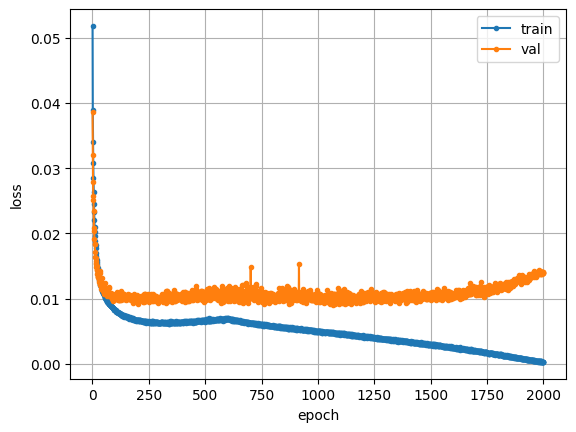

In [39]:
history_plot_train_val(history, 'loss')

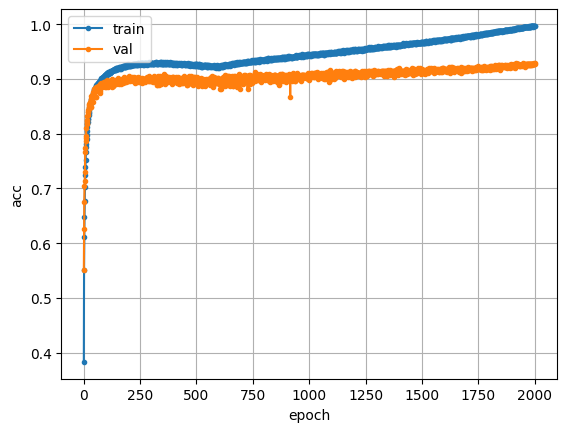

In [40]:
history_plot_train_val(history, 'acc')